In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, silhouette_score, accuracy_score, precision_score, f1_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import itertools
from scipy.stats import mannwhitneyu
from sklearn import metrics
from numpy import mean, std
#from mpl_toolkits.mplot3d import Axes3D
#import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from scipy.stats import kruskal
#from statannotations.Annotator import Annotator

In [12]:
import numpy as np
import pandas as pd
import matplotlib
import shap
import sklearn
#import xgboost
import seaborn as sns
import scipy
#import statannotations

# Display package versions
print("Package Versions:")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"shap version: {shap.__version__}")
print(f"sklearn version: {sklearn.__version__}")
#print(f"xgboost version: {xgboost.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"scipy version: {scipy.__version__}")
#print(f"statannotations version: {statannotations.__version__}")


Package Versions:
numpy version: 2.0.2
pandas version: 2.2.3
matplotlib version: 3.9.2
shap version: 0.46.0
sklearn version: 1.5.2
seaborn version: 0.13.2
scipy version: 1.14.1



------------ CV Repeat number: 0

------ Fold Number: 0
Best parameters of the model are:  {'max_depth': 7, 'n_estimators': np.int64(250)}

------ Fold Number: 1
Best parameters of the model are:  {'max_depth': None, 'n_estimators': np.int64(150)}

------ Fold Number: 2
Best parameters of the model are:  {'max_depth': 9, 'n_estimators': np.int64(250)}

------ Fold Number: 3
Best parameters of the model are:  {'max_depth': 9, 'n_estimators': np.int64(50)}

------ Fold Number: 4
Best parameters of the model are:  {'max_depth': 9, 'n_estimators': np.int64(200)}

------ Fold Number: 5
Best parameters of the model are:  {'max_depth': 9, 'n_estimators': np.int64(50)}

------ Fold Number: 6
Best parameters of the model are:  {'max_depth': None, 'n_estimators': np.int64(100)}

------ Fold Number: 7
Best parameters of the model are:  {'max_depth': 9, 'n_estimators': np.int64(200)}

------ Fold Number: 8
Best parameters of the model are:  {'max_depth': 7, 'n_estimators': np.int64(250)}

------ 

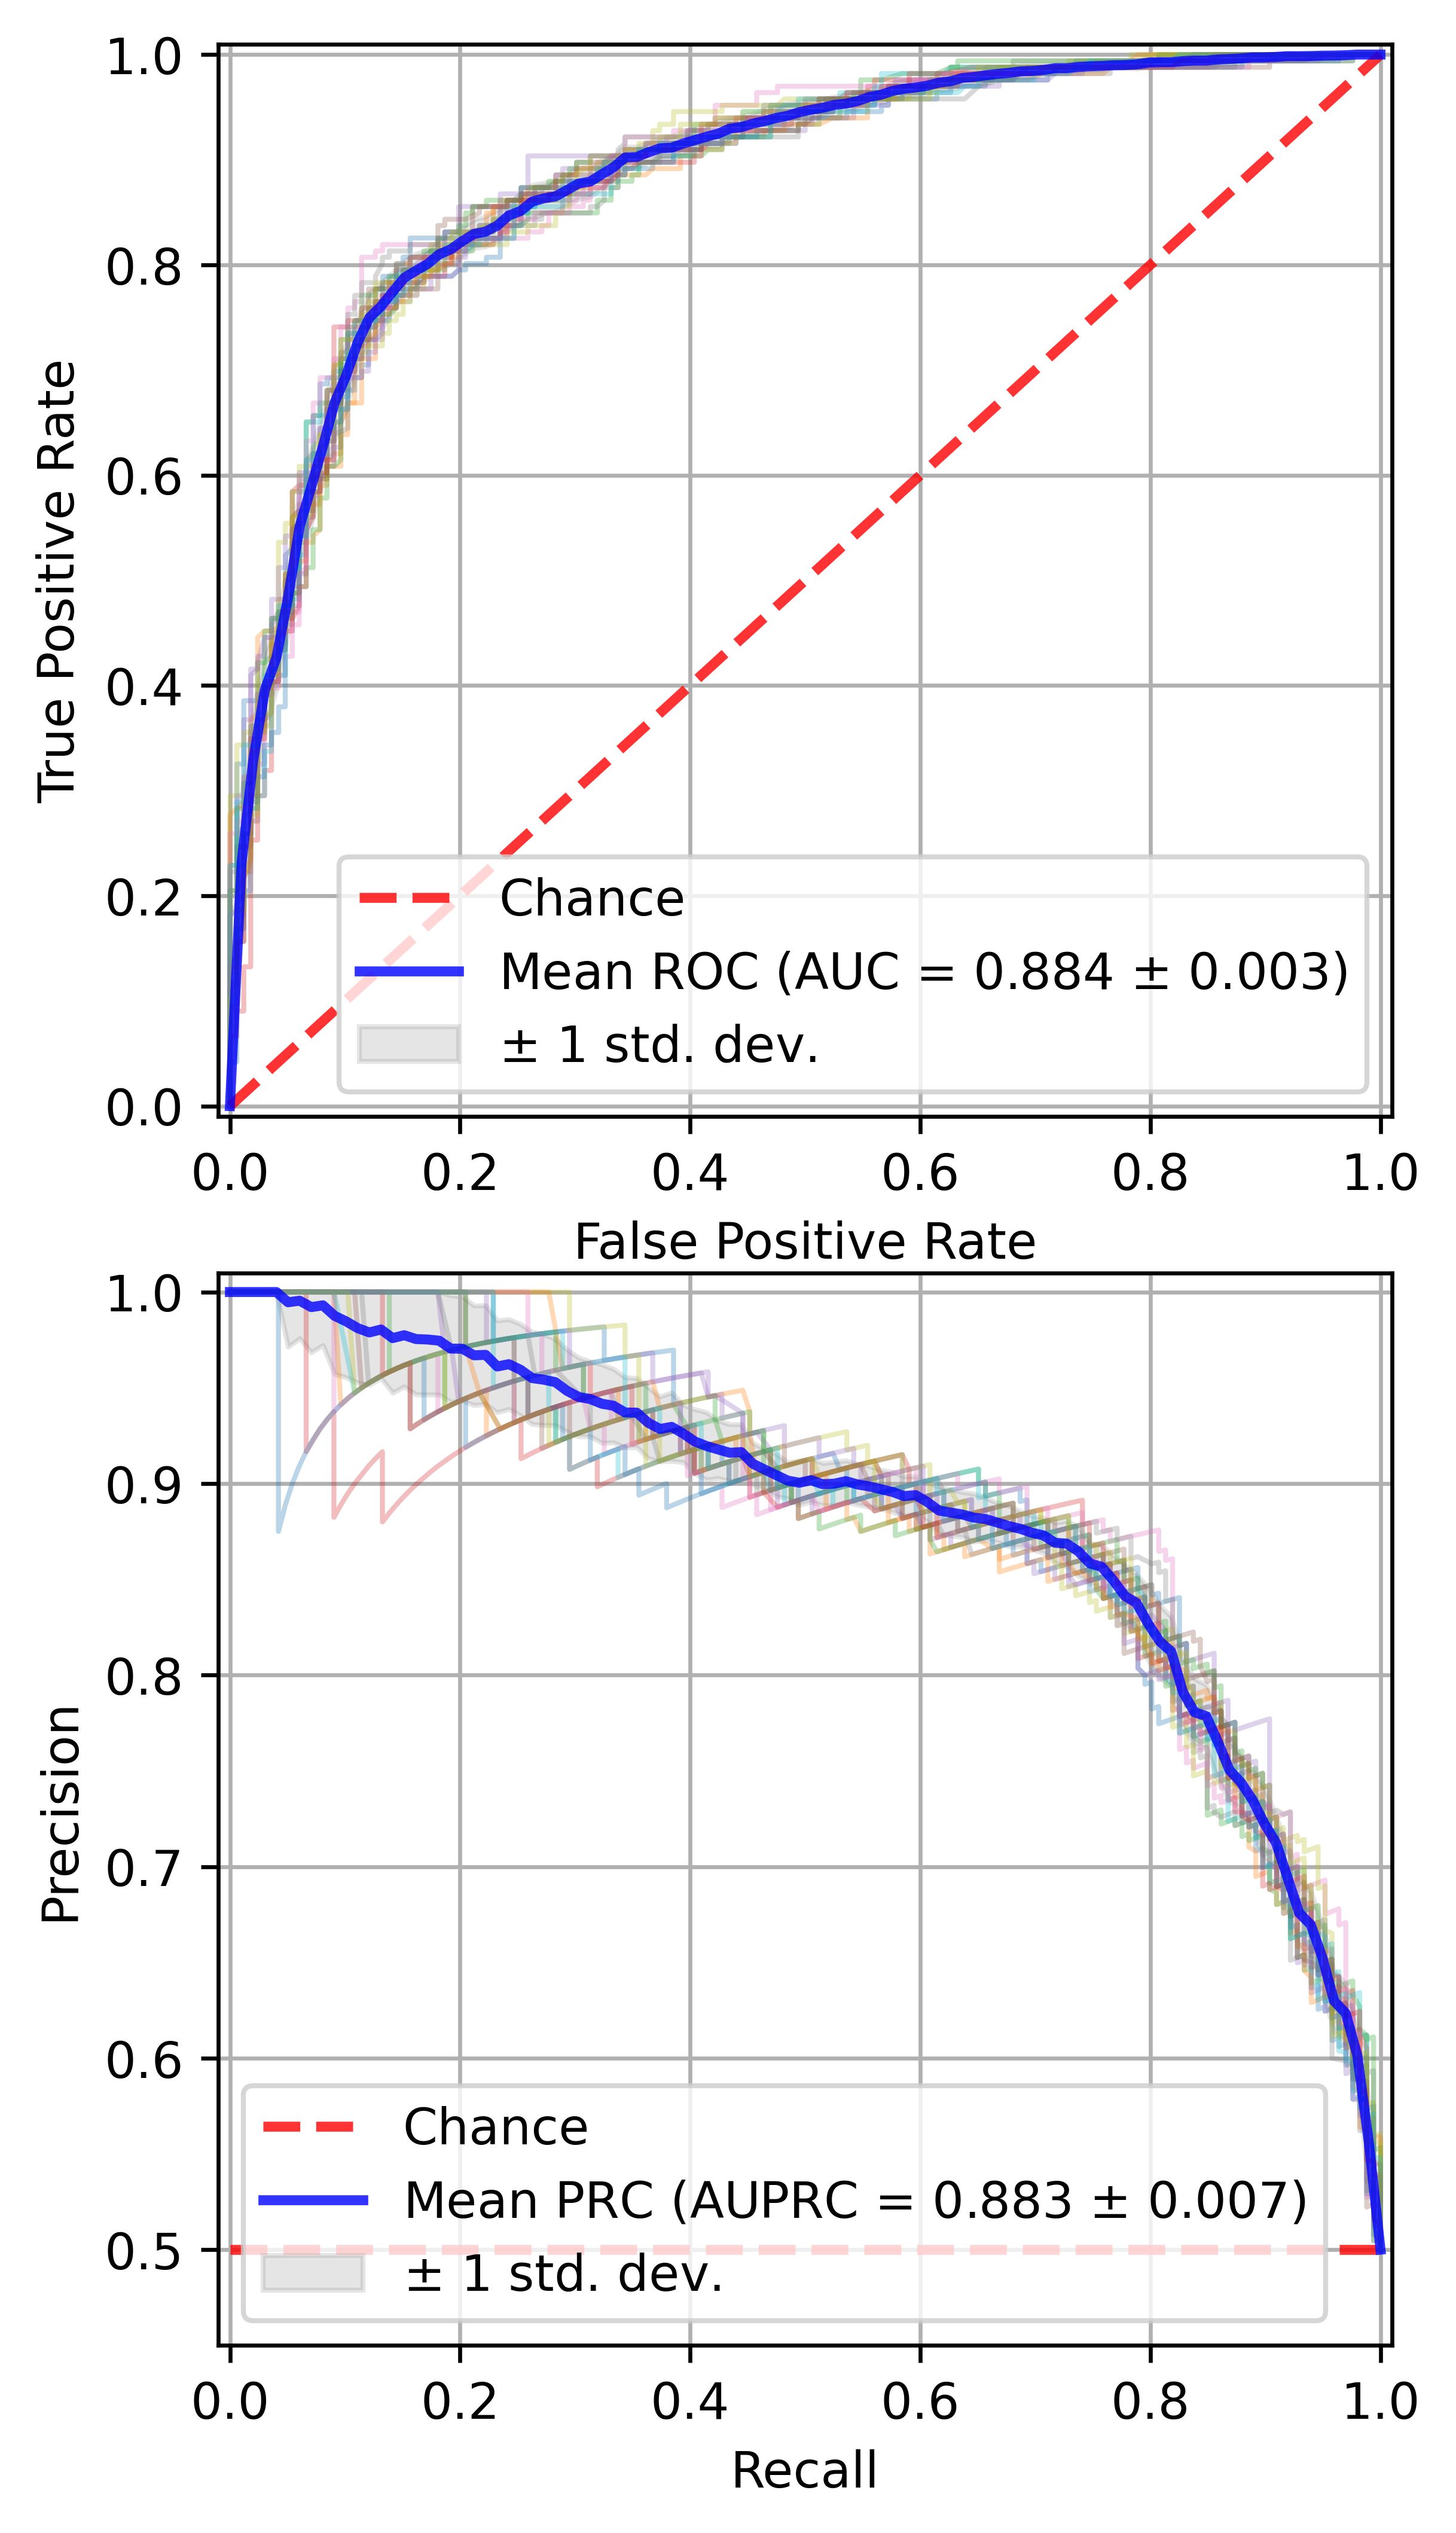

In [2]:

# Load data
Train_Cal = pd.read_excel("data.xlsx", sheet_name=0, index_col=0)
Train_Cal = Train_Cal.rename(columns={'Total_microbial_mass': 'Mean_Glucose'})

# Define a function to assign binary values
def assign_value(x):
    return 1 if x > np.percentile(Train_Cal['Q10_Basal'], 50) else 0

# Apply the function to create binary labels
Train_Cal["Q10_Basal_binary"] = Train_Cal["Q10_Basal"].apply(assign_value)

# Create datasets based on Q10_Basal percentile
df_up = Train_Cal.loc[Train_Cal['Q10_Basal'] > np.percentile(Train_Cal['Q10_Basal'], 50)]
df_low = Train_Cal.loc[Train_Cal['Q10_Basal'] < np.percentile(Train_Cal['Q10_Basal'], 50)]
df = pd.concat([df_low, df_up], axis=0)

# Prepare features and labels
y = df["Q10_Basal_binary"]
X = df.iloc[:, :-7]

# Set seed and cross-validation parameters
np.random.seed(1)
CV_repeats = 20
random_states = np.random.randint(10000, size=CV_repeats)

# Initialize dictionaries to store SHAP values and probabilities
shap_values_per_cv = {sample: {CV_repeat: {} for CV_repeat in range(CV_repeats)} for sample in X.index}
prob_per_cv = {sample: {CV_repeat: {} for CV_repeat in range(CV_repeats)} for sample in X.index}

# Set up figure for ROC and PR curves
fig, ax = plt.subplots(nrows=2, ncols=1, dpi=600, figsize=(4, 7))
fig.tight_layout()
ax1, ax2 = ax.flatten()

# Parameter grid for hyperparameter optimization
param_grid = [{'max_depth': [None, 3, 5, 7, 9], 'n_estimators': np.arange(50, 300, 50)}]

# Initialize lists to store metrics
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)
precision_array, aucs_pr = [], []
mean_recall_array = np.linspace(0, 1, 100)
importance_xgb = pd.DataFrame(columns=X.columns)
acc_xgb, prec_xgb, f1_xgb, parameters = [], [], [], []

# Cross-validation loop
for i, CV_repeat in enumerate(range(CV_repeats)):
    print('\n------------ CV Repeat number:', CV_repeat)
    CV = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_states[i])
    ix_training, ix_test = [], []
    for fold in CV.split(X, y):
        ix_training.append(fold[0])
        ix_test.append(fold[1])

    predicted, label, score = [], [], []

    for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
        print('\n------ Fold Number:', i)
        X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
        y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix]

        cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        
        scaler=StandardScaler()
        scaler.fit(X_train)
        X_train_scaled=scaler.transform(X_train)
        X_train=pd.DataFrame(X_train_scaled, index=X_train.index,columns=X_train.columns)
        X_test_scaled=scaler.transform(X_test)
        X_test=pd.DataFrame(X_test_scaled, index=X_test.index,columns=X_test.columns)
        
        model = ExtraTreesClassifier(random_state=0, class_weight='balanced')
        search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv_inner, refit=True)
        result = search.fit(X_train, y_train)

        best_model = result.best_estimator_
        best_param = result.best_params_
        parameters.append(best_param)
        print('Best parameters of the model are: ', best_param)

        best_model.fit(X_train, y_train)
        yhat = best_model.predict(X_test)
        y_score = best_model.predict_proba(X_test)[:, 1]
        
        label.append(y_test)
        predicted.append(yhat)
        score.append(y_score)
        
        # Extract output prob information per fold per sample 
        for i, test_index in enumerate(X.index[test_outer_ix]):
            prob_per_cv[test_index][CV_repeat] = y_score[i] #-#-#     

        explainer = shap.TreeExplainer(best_model, data=X_train, feature_perturbation='interventional')
        shap_values = explainer.shap_values(X_test, check_additivity=False)[:,:,1]

        for j, test_index in enumerate(X.index[test_outer_ix]):
            shap_values_per_cv[test_index][CV_repeat] = shap_values[j]

    acc_sc = accuracy_score(np.hstack(label), np.hstack(predicted))
    acc_xgb.append(acc_sc)
    prec_sc = precision_score(np.hstack(label), np.hstack(predicted), pos_label=1)
    prec_xgb.append(prec_sc)
    f1_sc = f1_score(np.hstack(label), np.hstack(predicted))
    f1_xgb.append(f1_sc)

    fpr, tpr, threshold = roc_curve(np.hstack(label), np.hstack(score))
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    ax1.plot(fpr, tpr, lw=1, alpha=0.3)

    precision_fold, recall_fold, _ = precision_recall_curve(np.hstack(label), np.hstack(score))
    precision_fold, recall_fold = precision_fold[::-1], recall_fold[::-1]
    prec_array = np.interp(mean_recall_array, recall_fold, precision_fold)
    precision_array.append(prec_array)
    precision_array[-1][0] = 1
    pr_auc = metrics.auc(recall_fold, precision_fold)
    aucs_pr.append(pr_auc)
    ax2.plot(recall_fold, precision_fold, alpha=0.3, lw=1)

# Plot ROC curve
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax1.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")
ax1.grid()

# Plot PR curve
no_skill = len((np.hstack(label))[(np.hstack(label)) == 1]) / len((np.hstack(label)))
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', lw=2, label='Chance', alpha=0.8, color='r')
mean_precision_array = np.mean(precision_array, axis=0)
mean_auc_pr = metrics.auc(mean_recall_array, mean_precision_array)
std_auc_pr = np.std(aucs_pr)
ax2.plot(mean_recall_array, mean_precision_array, color='b', label=r'Mean PRC (AUPRC = %0.3f $\pm$ %0.3f)' % (mean_auc_pr, std_auc_pr), lw=2, alpha=0.8)
std_precision_array = np.std(precision_array, axis=0)
precision_array_upper = np.minimum(mean_precision_array + std_precision_array, 1)
precision_array_lower = np.maximum(mean_precision_array - std_precision_array, 0)
ax2.fill_between(mean_recall_array, precision_array_lower, precision_array_upper, color='grey', alpha=0.2, label=r'$\pm$ 1 std. dev.')
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([no_skill - 0.05, 1.01])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='lower left')
ax2.grid()
plt.show()

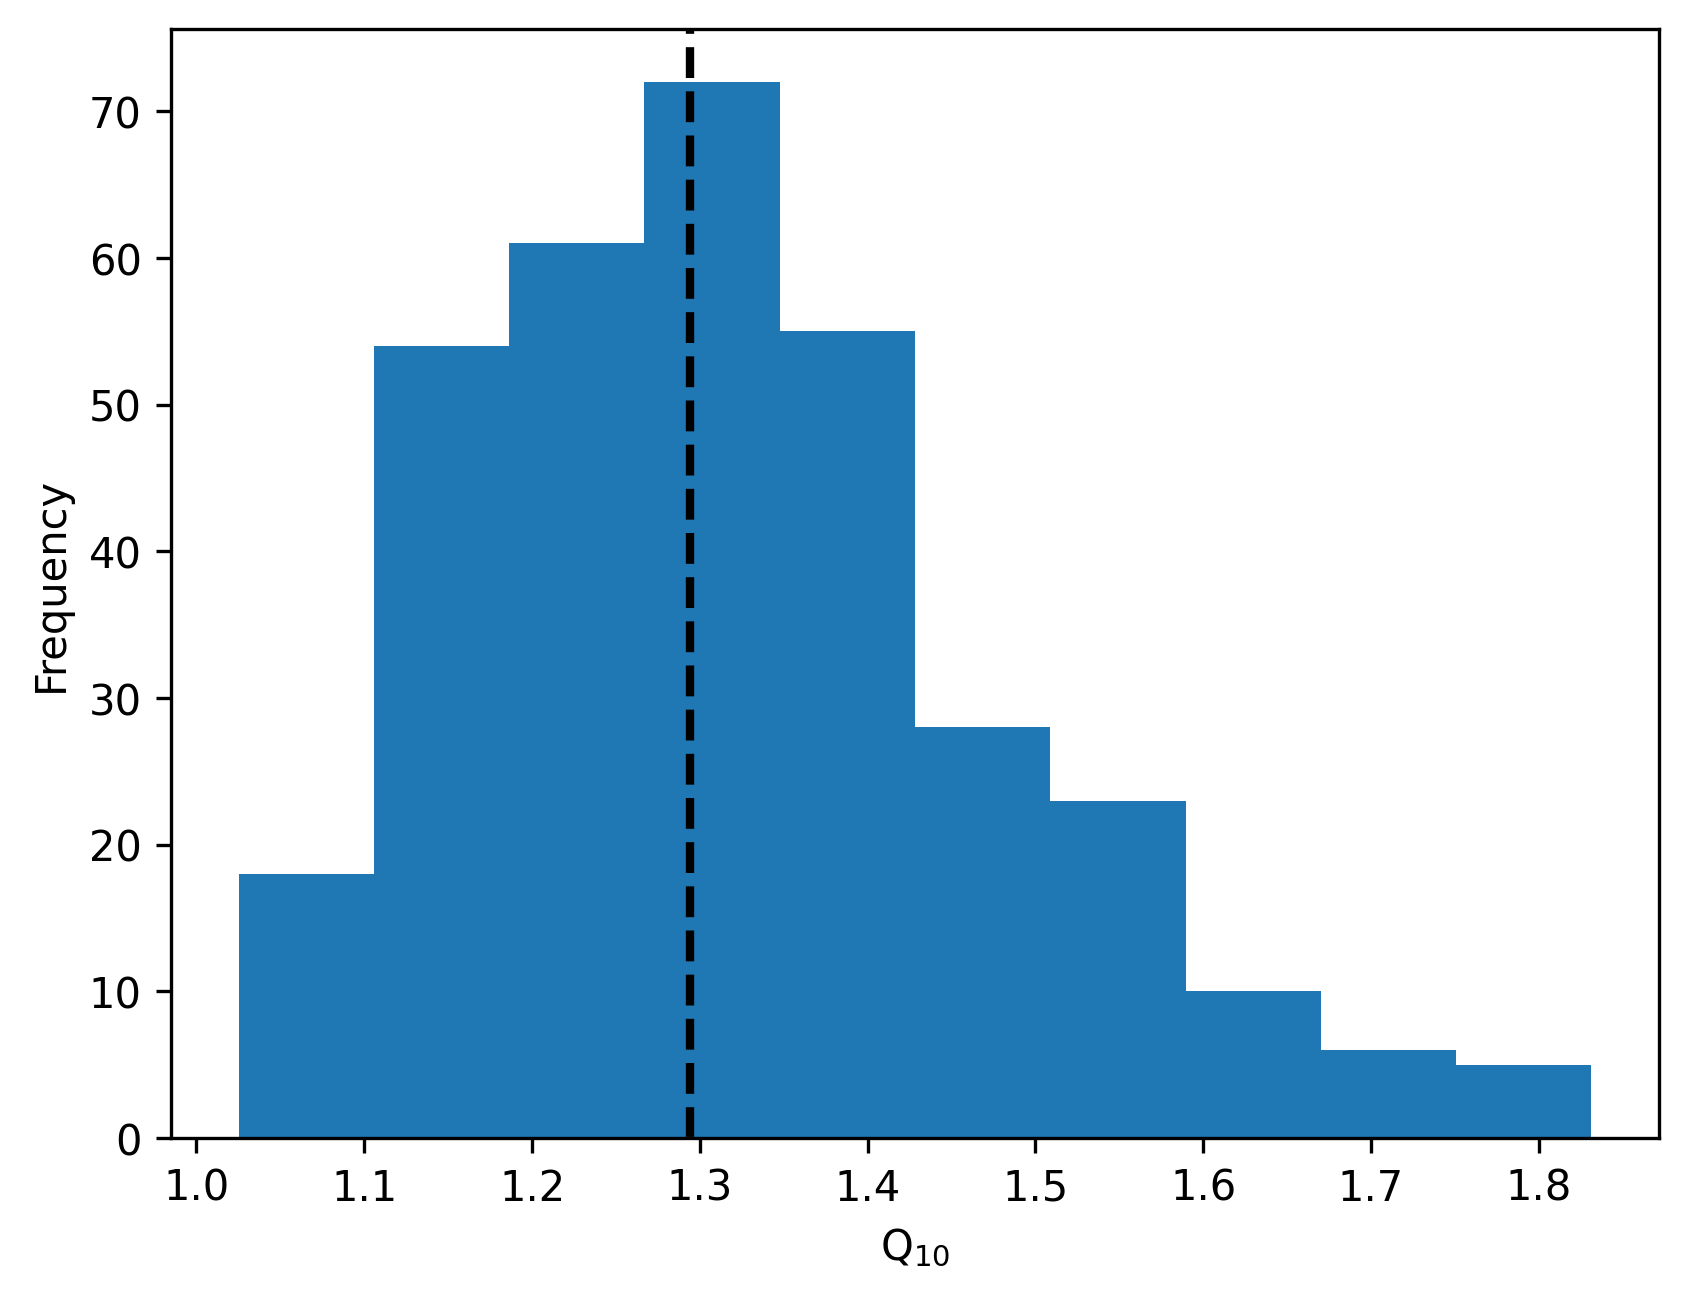

In [3]:
plt.figure(dpi=300)
plt.hist(Train_Cal['Q10_Basal'])
plt.axvline(np.median(Train_Cal['Q10_Basal']), color='k', linestyle='dashed', linewidth=2)
plt.xlabel("Q$_{10}$")
plt.ylabel("Frequency")
plt.show()


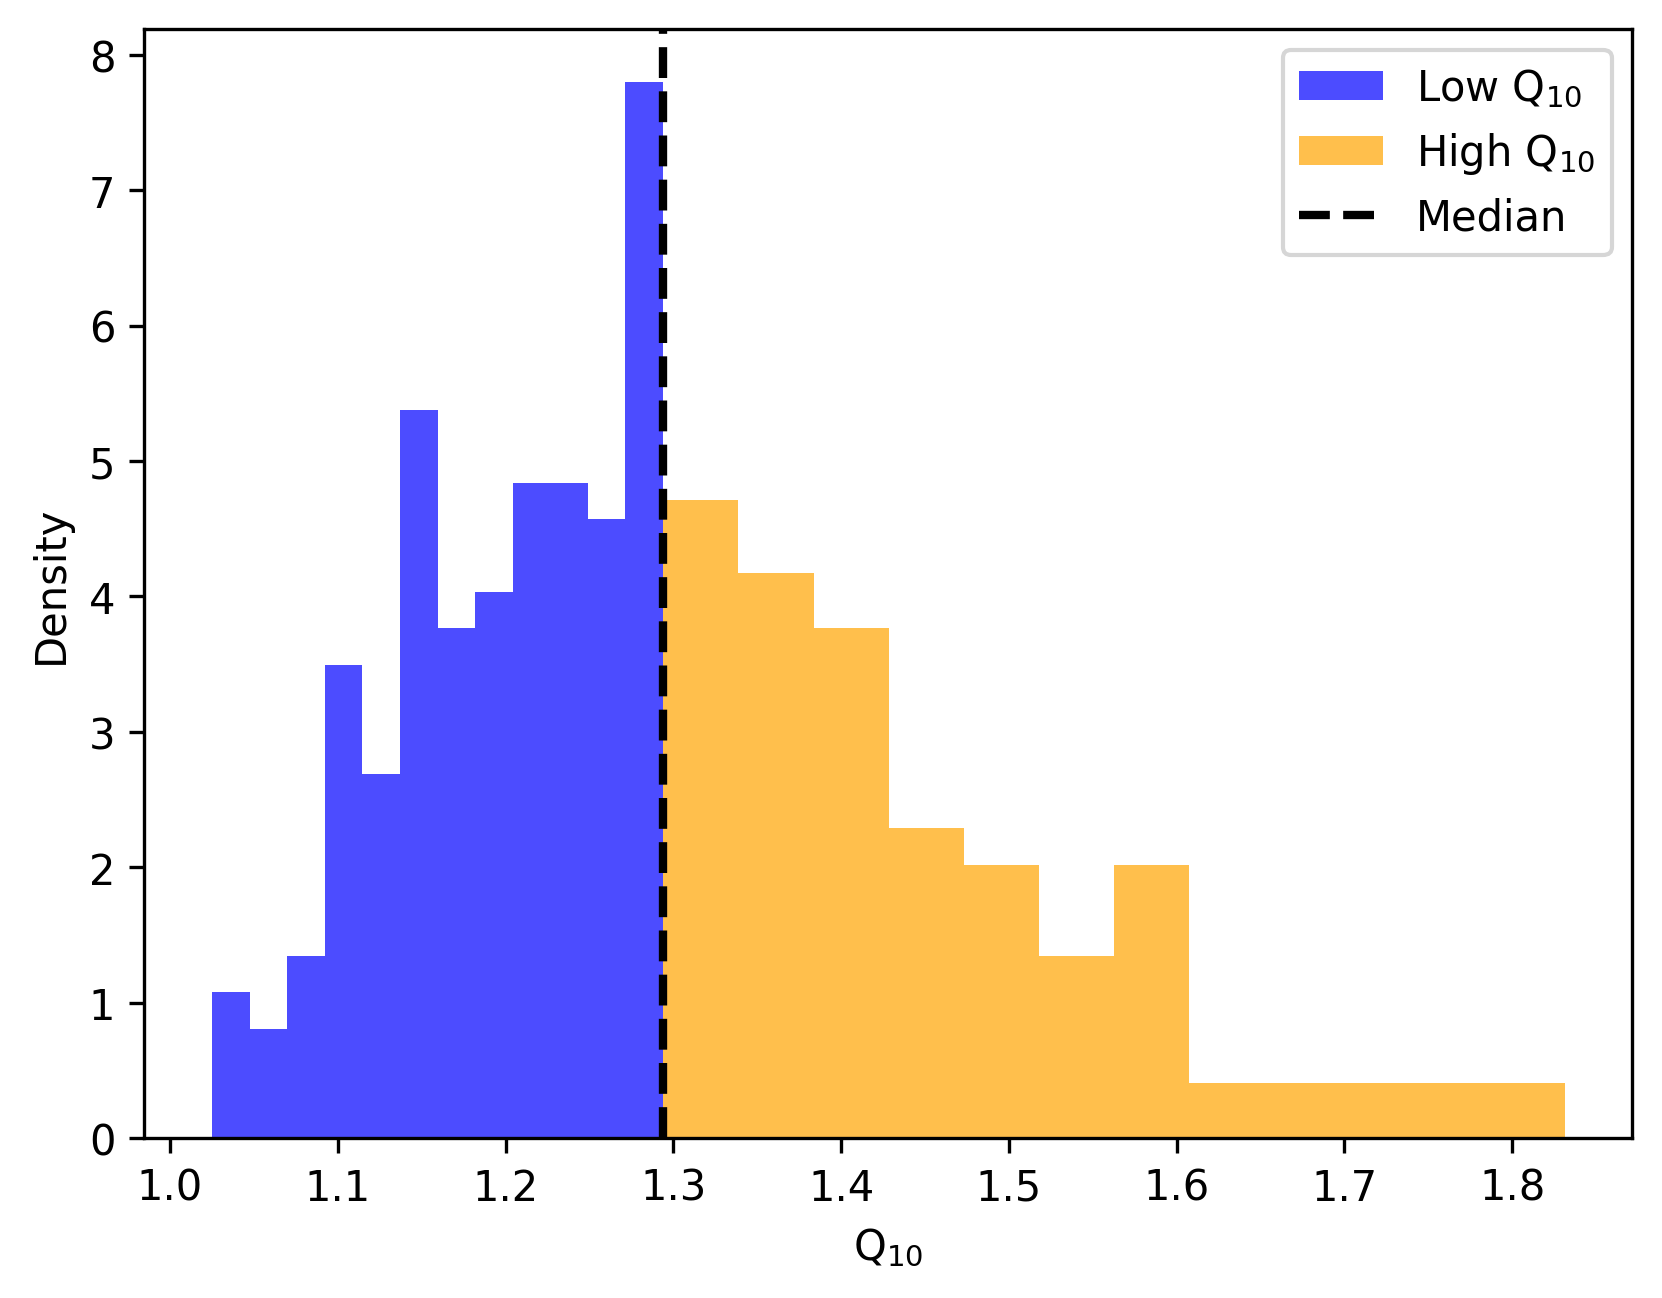

In [4]:
# Sample data (replace with your actual data)
data = Train_Cal['Q10_Basal']
median_value = np.median(data)

# Define the number of bins
bins = 12  # or choose a specific bin count

# Plot histogram for the left side of the median
plt.figure(dpi=300)
plt.hist(data[data <= median_value], bins=bins, color='blue', alpha=0.7, label='Low Q$_{10}$', density=True)

# Plot histogram for the right side of the median
plt.hist(data[data > median_value], bins=bins, color='orange', alpha=0.7, label='High Q$_{10}$', density=True)

# Plot the median line
plt.axvline(median_value, color='k', linestyle='dashed', linewidth=2, label='Median')

# Adding labels and legend
plt.xlabel("Q$_{10}$")
plt.ylabel("Density")
plt.legend()
plt.show()

In [5]:
print('ACC: %.3f (%.3f)' % (mean(acc_xgb), std(acc_xgb)))
print('Precision: %.3f (%.3f)' % (mean(prec_xgb), std(prec_xgb)))
print('AuROC: %.3f (%.3f)' % (mean_auc, std_auc))
print('F1: %.3f (%.3f)' % (mean(f1_xgb), std(f1_xgb)))
print('AuPRC: %.3f (%.3f)' % (mean_auc_pr, std_auc_pr))

ACC: 0.813 (0.007)
Precision: 0.812 (0.008)
AuROC: 0.884 (0.003)
F1: 0.813 (0.008)
AuPRC: 0.883 (0.007)


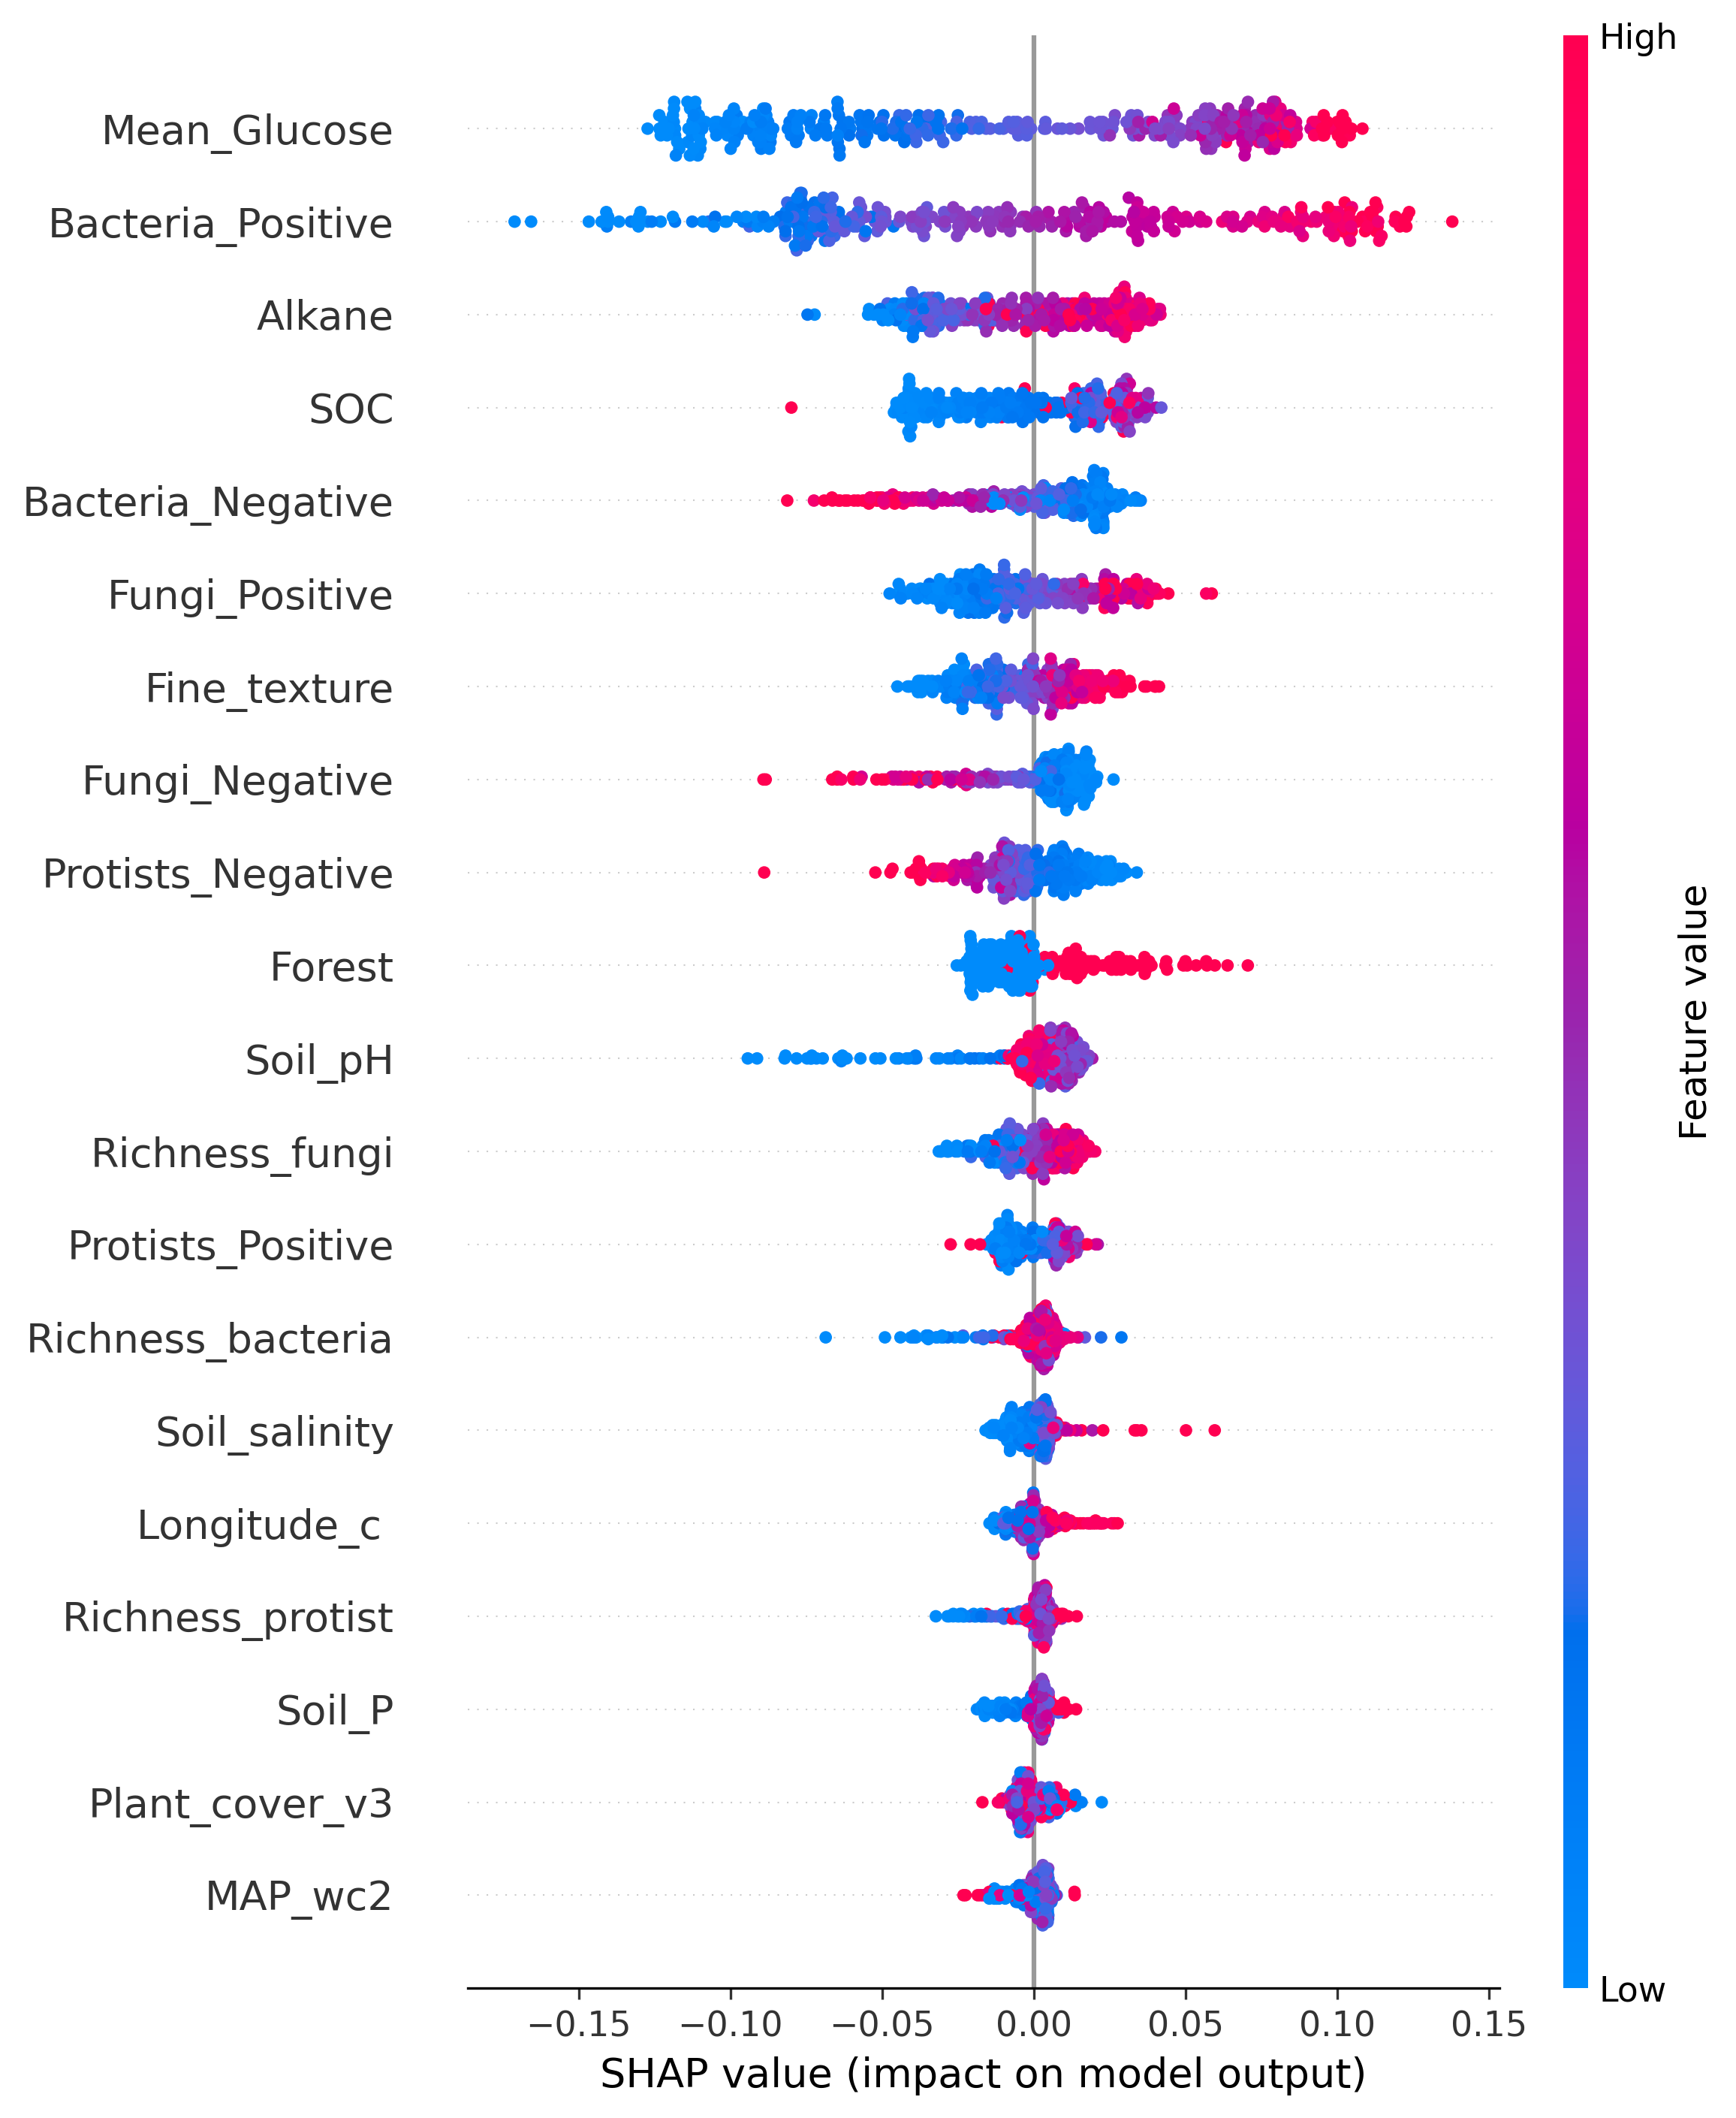

In [6]:
# SHAP summary plots for classes 0 and 1
average_shap_values = []
for i in X.index:
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i])
    average_shap_values.append(df_per_obs.mean(axis=1).values)
    
plt.figure(dpi=300)
shap.summary_plot(np.array(average_shap_values), X, max_display=20)

In [7]:
# Establish lists to keep average prob values, their Stds, and their min and max
average_prob, prob_stds, prob_ranges = [],[],[]

for i in X.index:
    df_per_obs = pd.DataFrame([prob_per_cv[i]]) # Get all prob  values for sample number i
    # Get relevant statistics for every sample 
    average_prob.append(df_per_obs.mean(axis=1).values) 
    #prob_stds.append(df_per_obs.std(axis=1).values)
    #prob_ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)
average_prob=np.hstack(average_prob)

# subgroup analysis

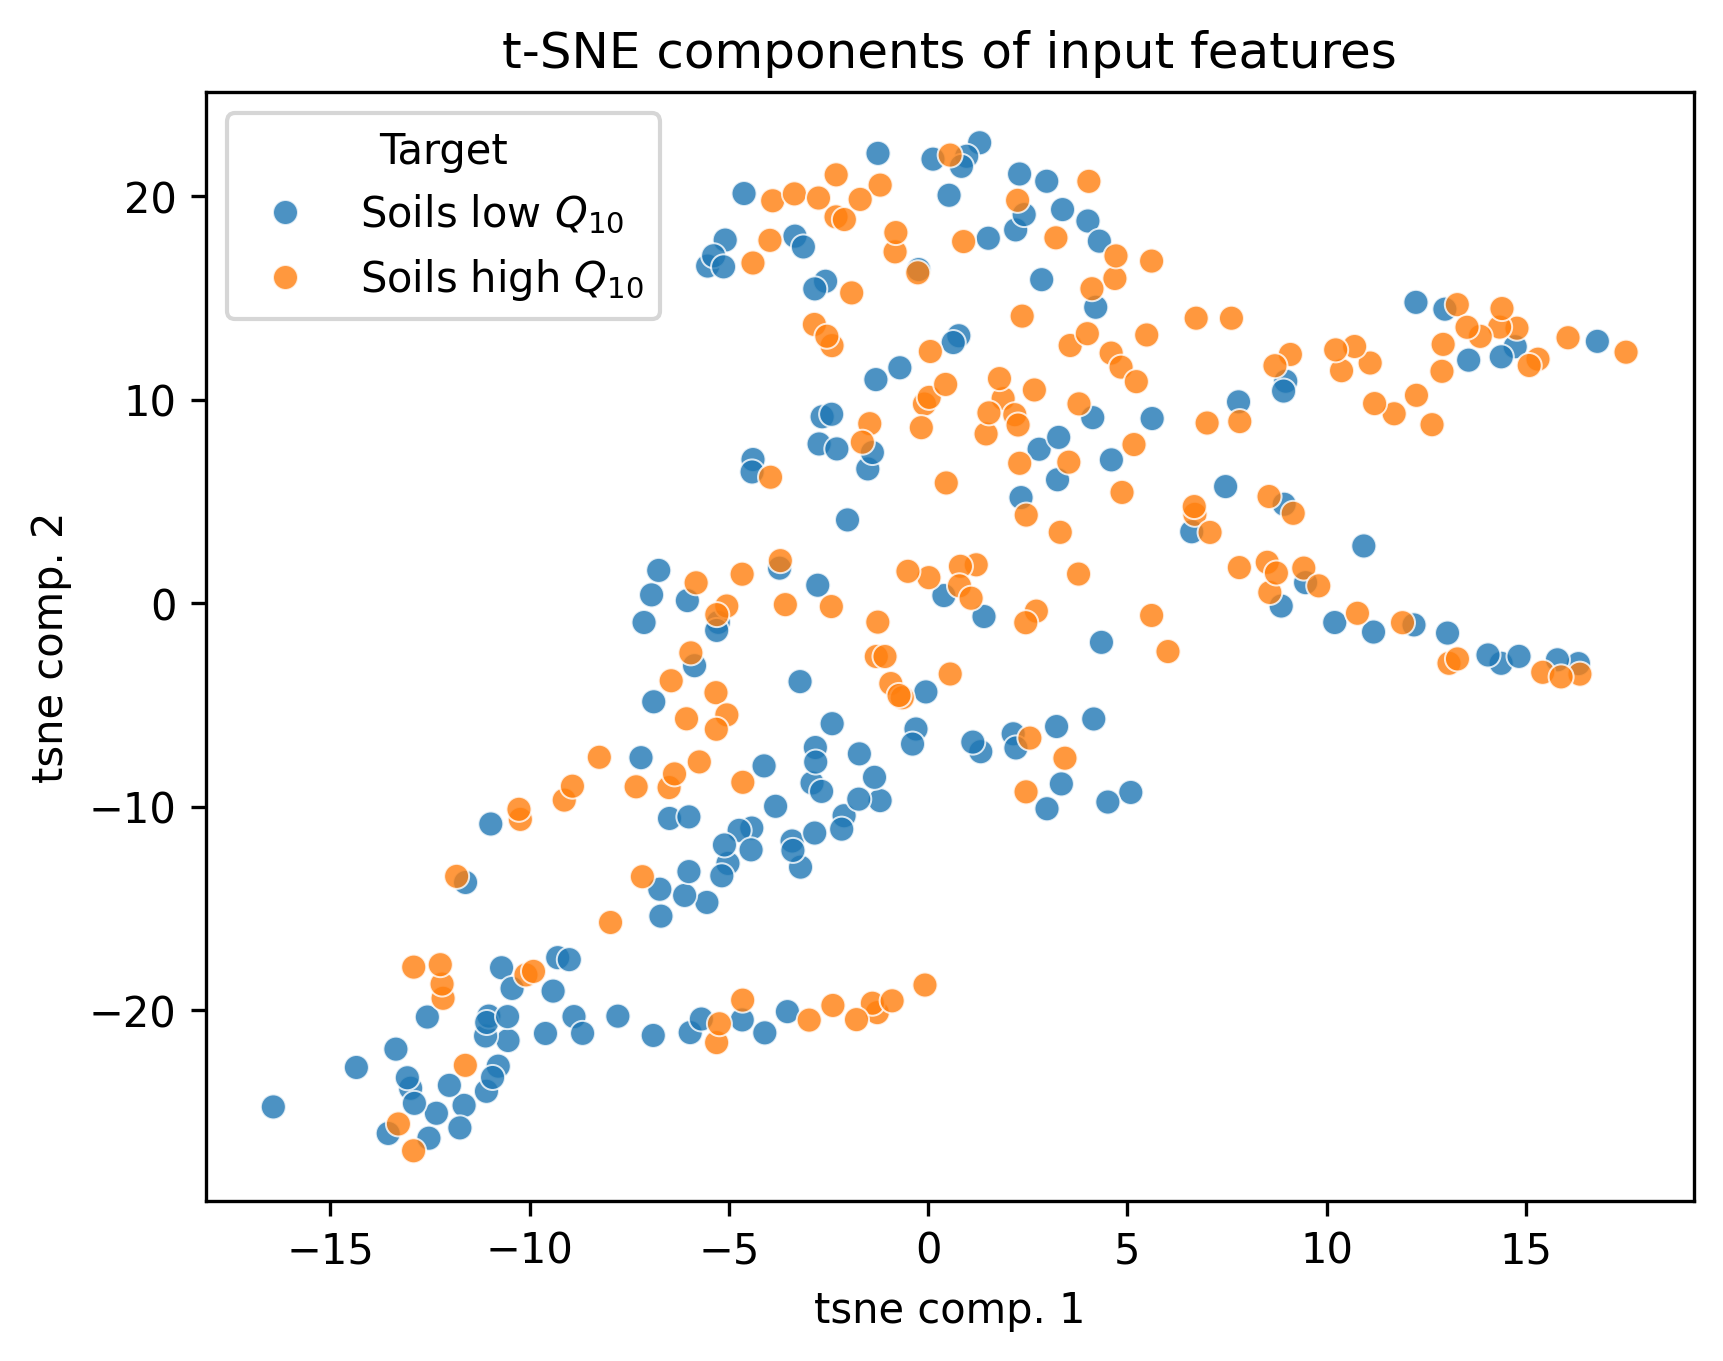

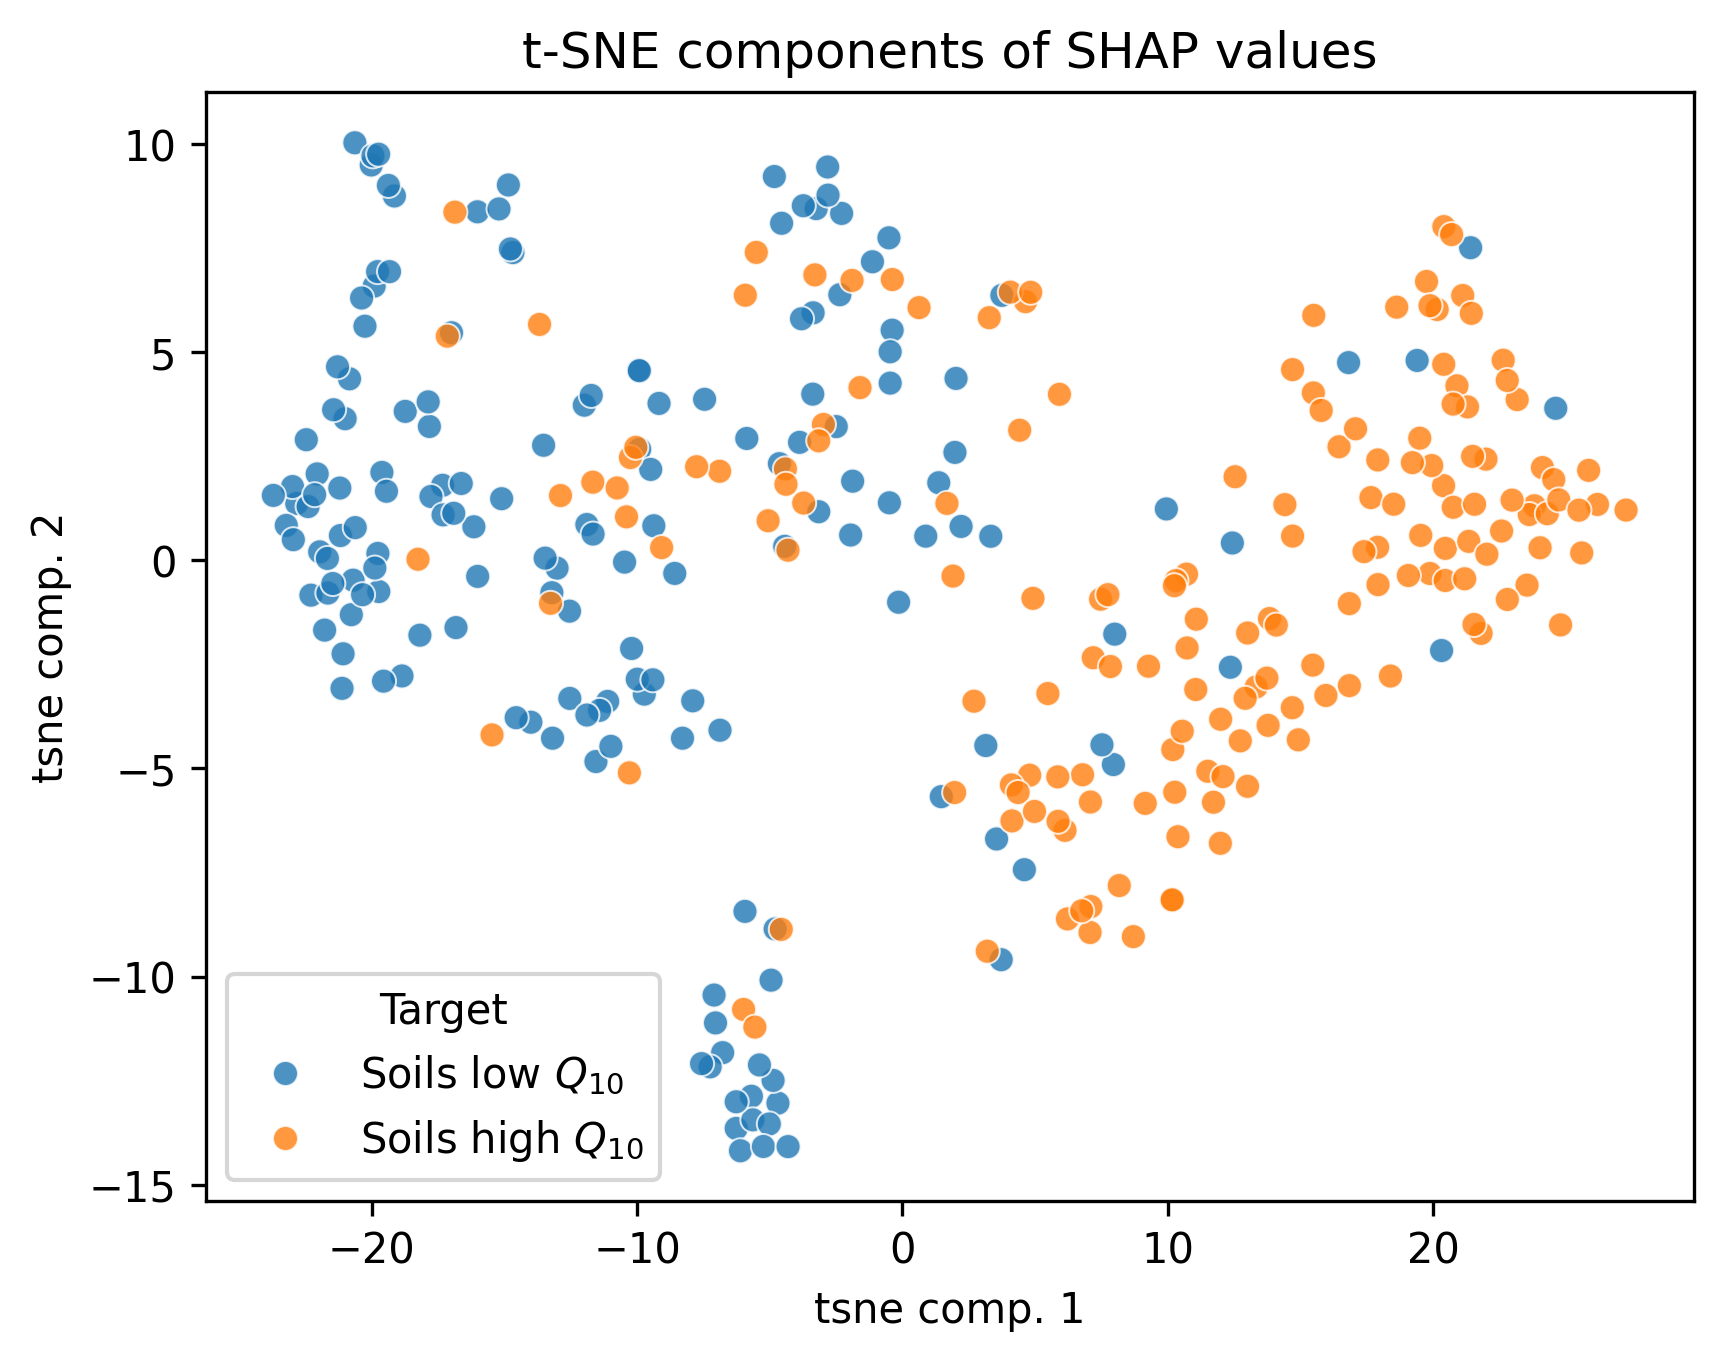

In [8]:
# t-SNE plot for original features
tsne = TSNE(n_components=2, random_state=20)
projections = tsne.fit_transform(df.iloc[:, :-7].values)
df_tsne = pd.DataFrame(projections, columns=['tsne comp. 1', 'tsne comp. 2'], index=df.index)

# Replace Target values with custom labels
df_tsne['Target'] = y.replace({0: 'Soils low $Q_{10}$', 1: 'Soils high $Q_{10}$'})

plt.figure(dpi=300)
sns.scatterplot(data=df_tsne, x='tsne comp. 1', y='tsne comp. 2', hue="Target", alpha=0.8)
plt.title('t-SNE components of input features')
plt.show()

# t-SNE plot for SHAP values
projections_shap = tsne.fit_transform(np.array(average_shap_values))
df_tsne_shap = pd.DataFrame(projections_shap, columns=['tsne comp. 1', 'tsne comp. 2'], index=df.index)

# Replace Target values with custom labels
df_tsne_shap['Target'] = y.replace({0: 'Soils low $Q_{10}$', 1: 'Soils high $Q_{10}$'})
df_tsne_shap['Probability'] = average_prob.astype(float)

plt.figure(dpi=300)
sns.scatterplot(data=df_tsne_shap, x='tsne comp. 1', y='tsne comp. 2', hue="Target", alpha=0.8)
plt.title('t-SNE components of SHAP values')
plt.show()

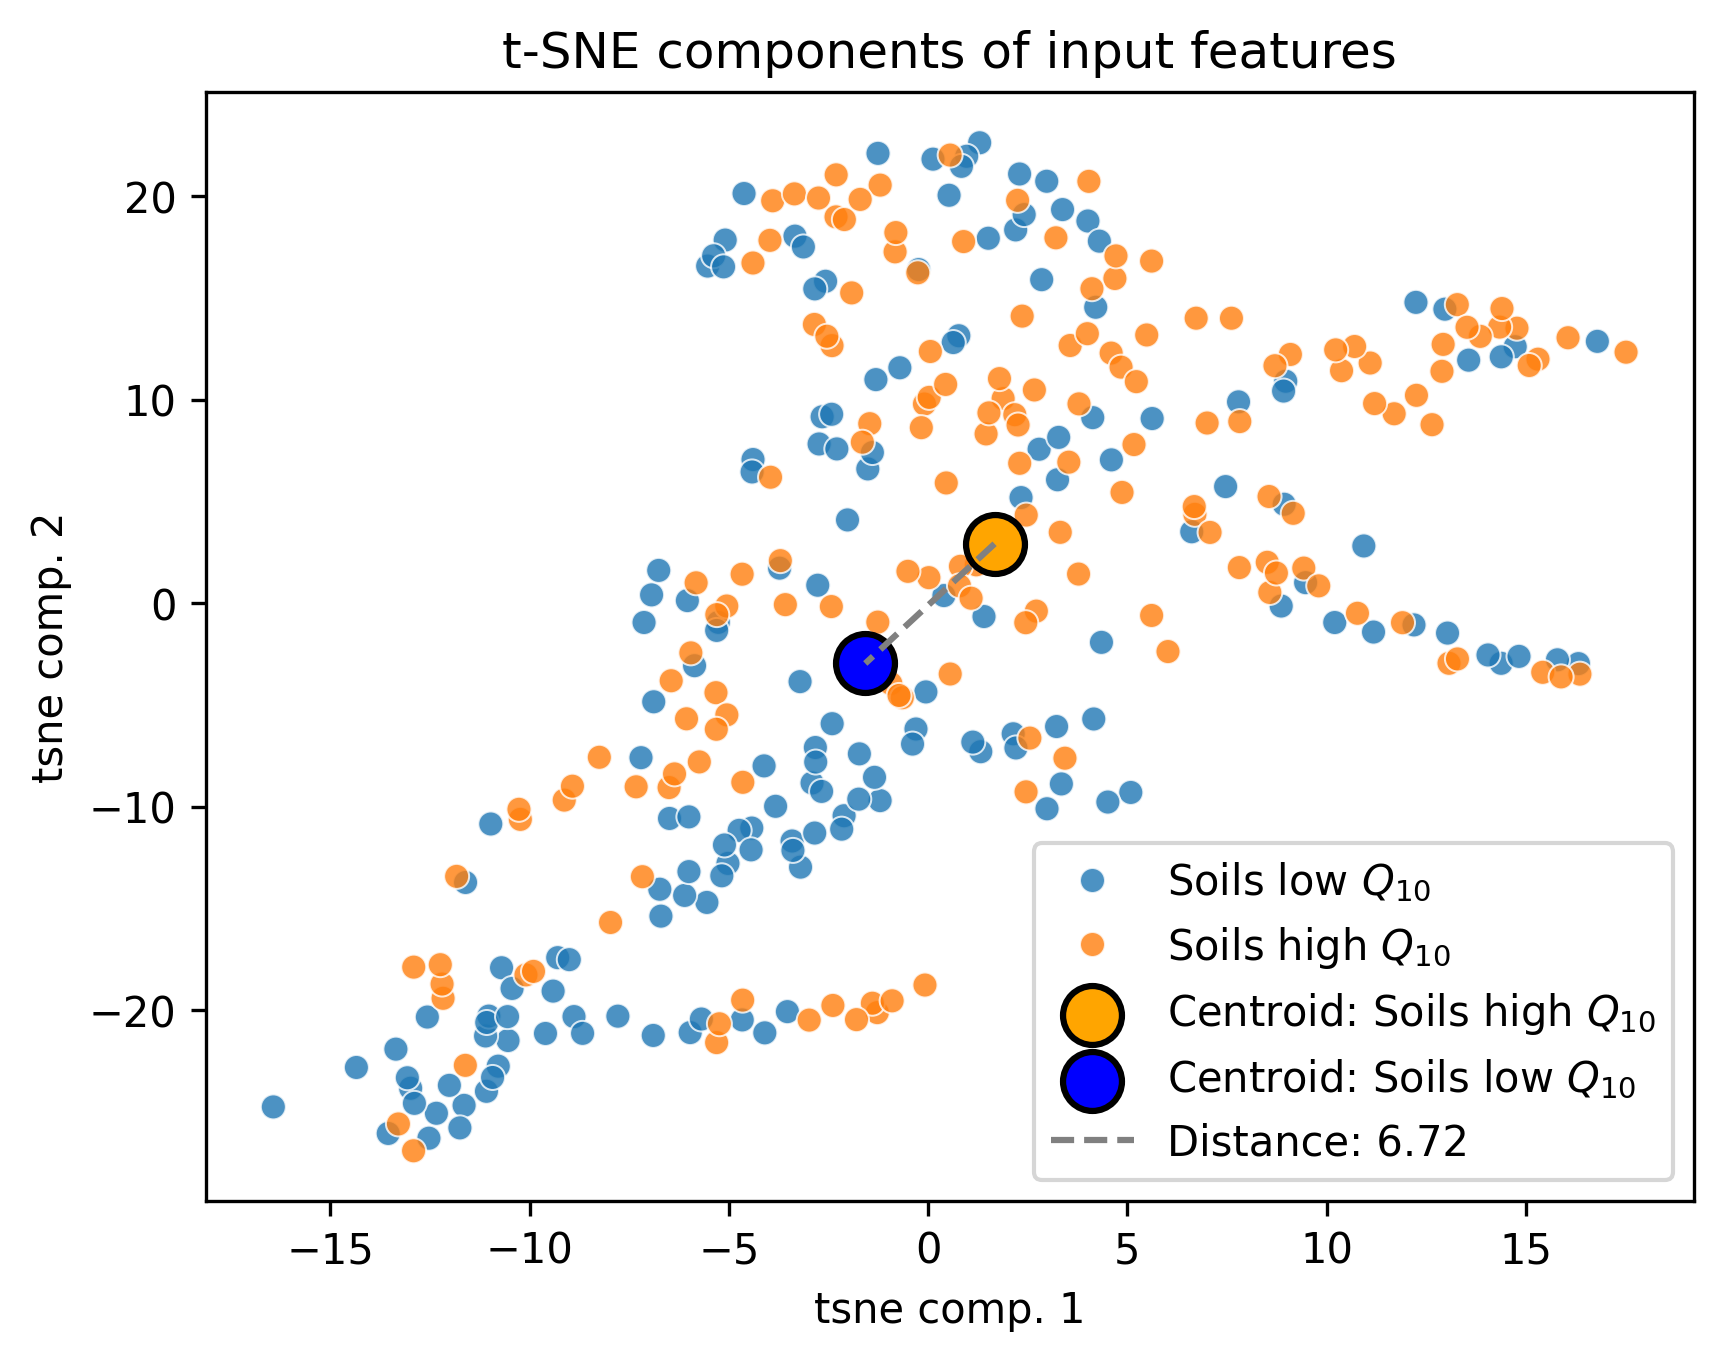

Distance between centroids (input features): 6.72


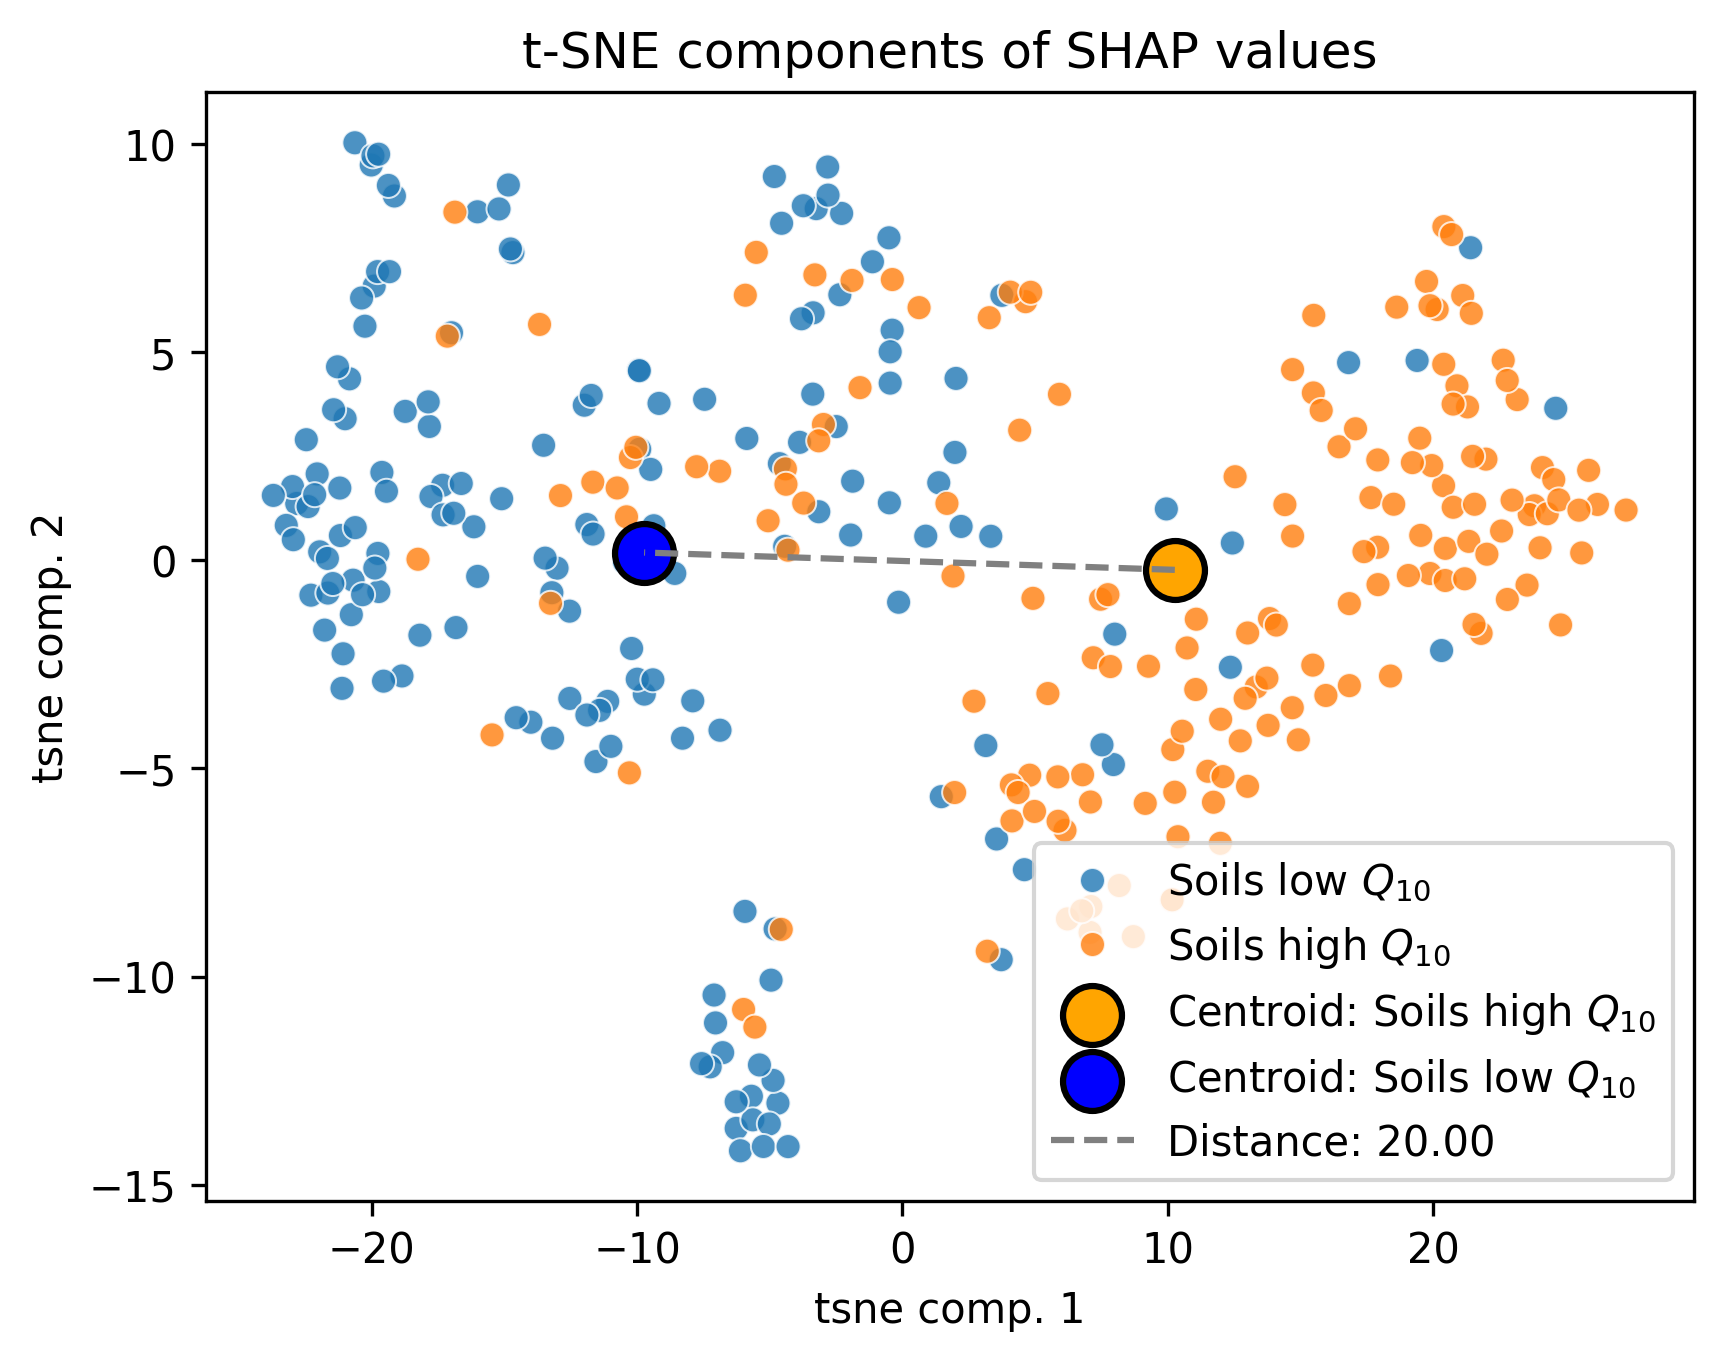

Distance between centroids (SHAP values): 20.00


In [20]:
# Function to calculate centroids and plot them with distance
def plot_tsne_with_centroids(df_tsne, title):
    # Calculate centroids for each class
    centroids = df_tsne.groupby('Target')[['tsne comp. 1', 'tsne comp. 2']].mean()
    
    # Compute Euclidean distance between centroids
    centroid_coords = centroids.values
    distance = np.linalg.norm(centroid_coords[0] - centroid_coords[1])
    
    # Define custom colors for centroids
    centroid_colors = {'Soils low $Q_{10}$': 'blue', 'Soils high $Q_{10}$': 'orange'}
    
    # Plot t-SNE points
    plt.figure(dpi=300)
    sns.scatterplot(data=df_tsne, x='tsne comp. 1', y='tsne comp. 2', hue="Target", alpha=0.8)
    
    # Plot centroids
    for label, row in centroids.iterrows():
        plt.scatter(
            row['tsne comp. 1'], row['tsne comp. 2'], 
            s=200, color=centroid_colors[label], 
            label=f'Centroid: {label}', edgecolor='black', linewidth=1.5
        )
    
    # Annotate distance on the plot
    plt.plot(
        [centroid_coords[0, 0], centroid_coords[1, 0]],
        [centroid_coords[0, 1], centroid_coords[1, 1]],
        linestyle='--', color='gray', label=f'Distance: {distance:.2f}'
    )
    plt.title(title)
    plt.legend()
    plt.show()
    
    return distance

# Plot for input features
distance_input = plot_tsne_with_centroids(df_tsne, 't-SNE components of input features')
print(f'Distance between centroids (input features): {distance_input:.2f}')

# Plot for SHAP values
distance_shap = plot_tsne_with_centroids(df_tsne_shap, 't-SNE components of SHAP values')
print(f'Distance between centroids (SHAP values): {distance_shap:.2f}')



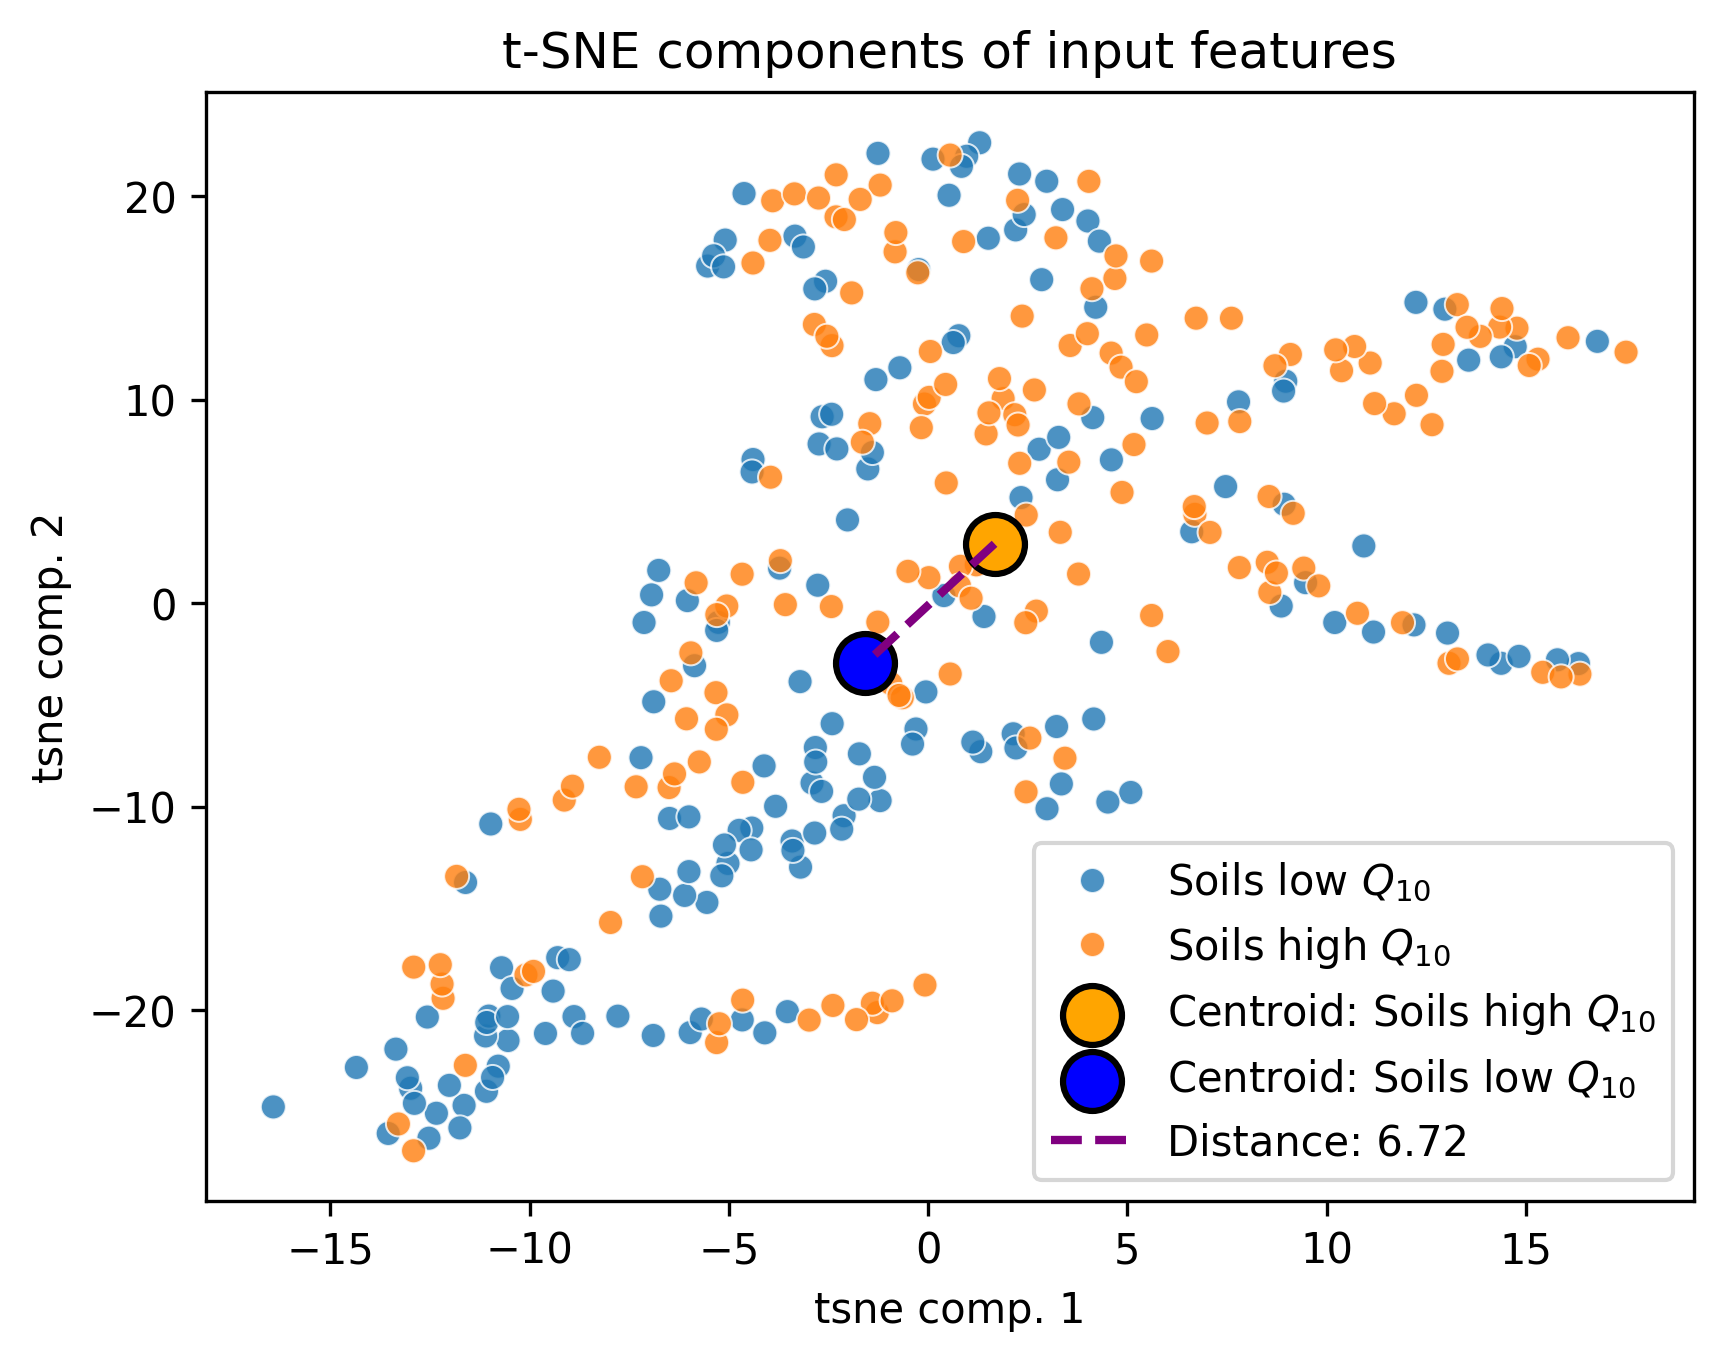

Distance between centroids (input features): 6.72


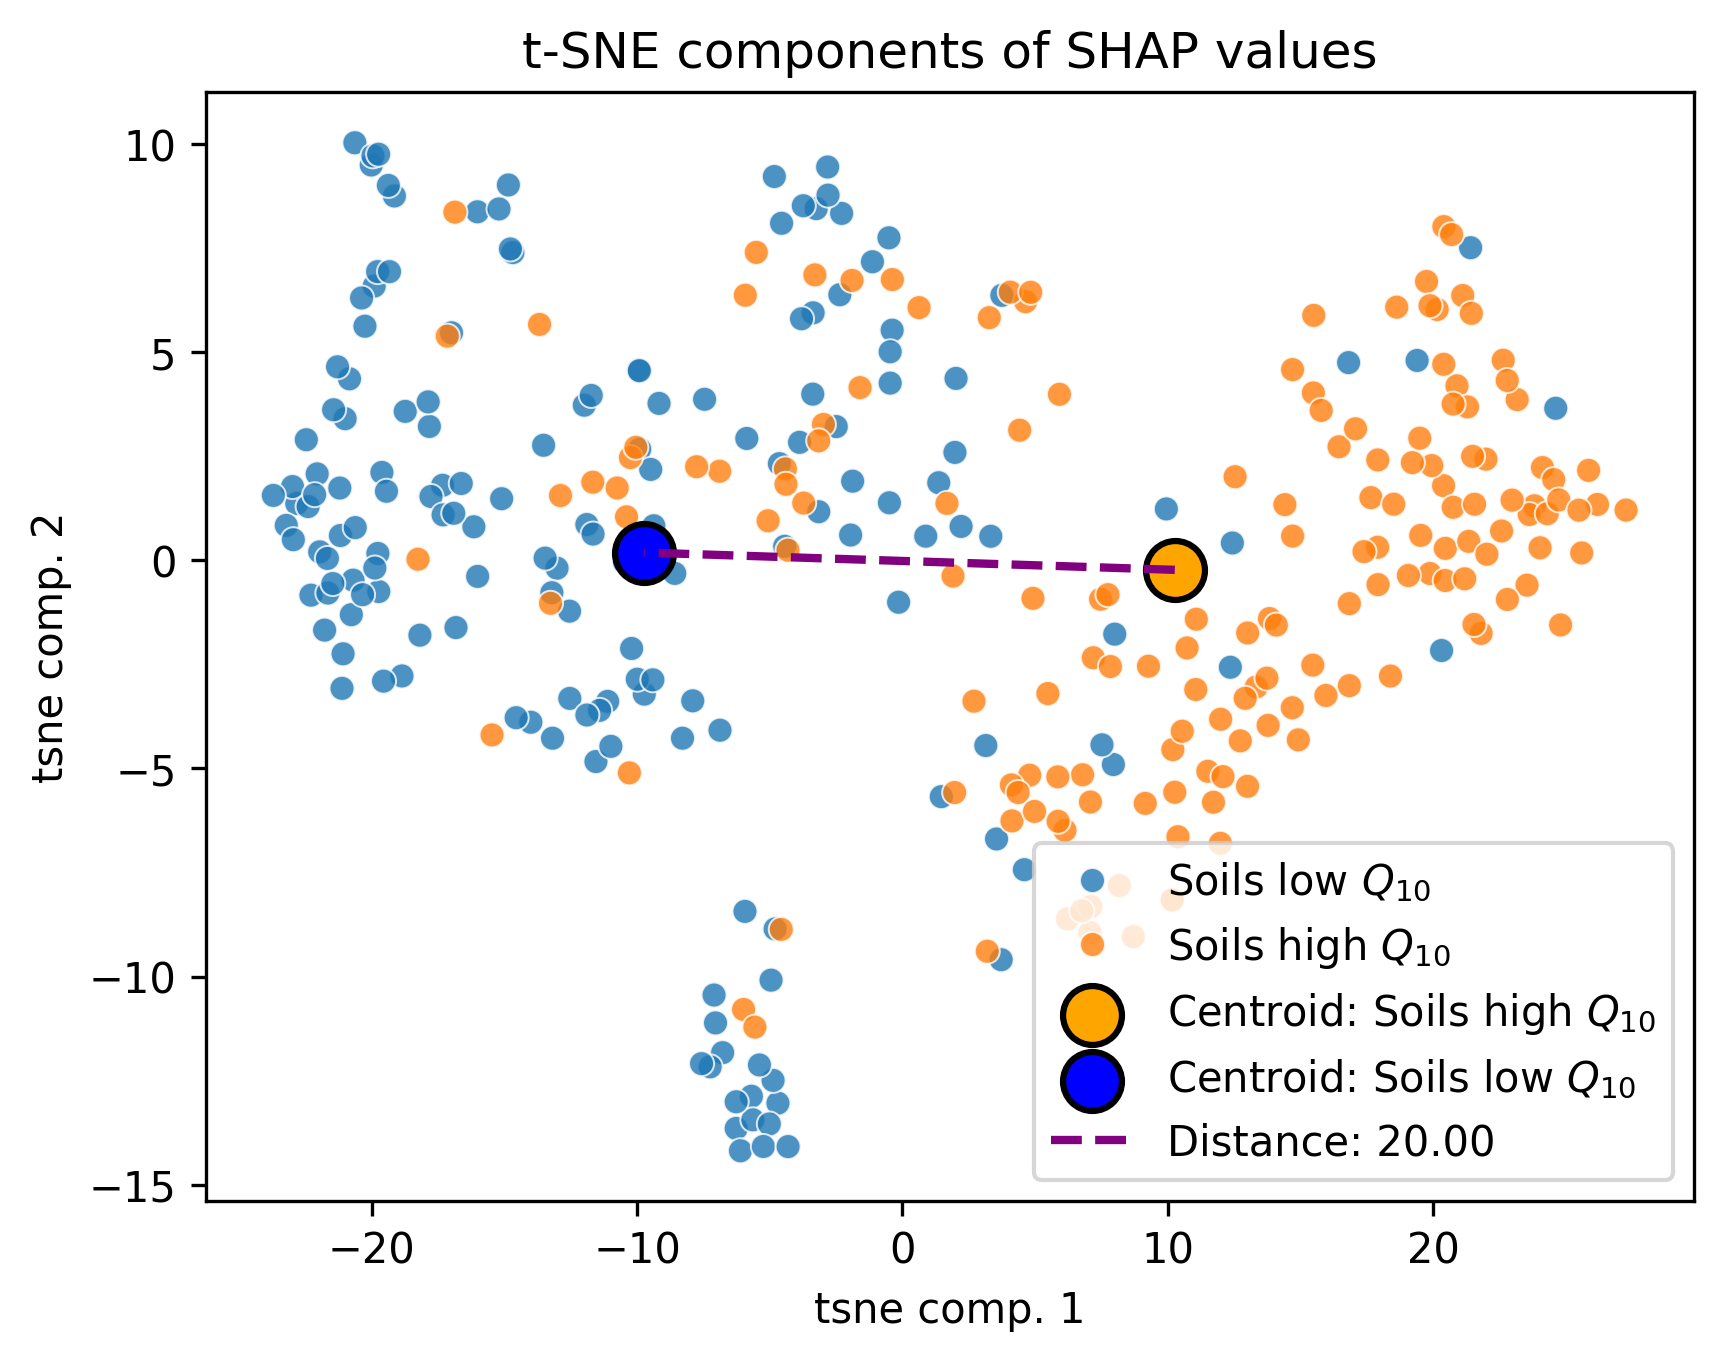

Distance between centroids (SHAP values): 20.00


In [23]:
# Function to calculate centroids and plot them with distance
def plot_tsne_with_centroids(df_tsne, title):
    # Calculate centroids for each class
    centroids = df_tsne.groupby('Target')[['tsne comp. 1', 'tsne comp. 2']].mean()
    
    # Compute Euclidean distance between centroids
    centroid_coords = centroids.values
    distance = np.linalg.norm(centroid_coords[0] - centroid_coords[1])
    
    # Define custom colors for centroids
    centroid_colors = {'Soils low $Q_{10}$': 'blue', 'Soils high $Q_{10}$': 'orange'}
    
    # Plot t-SNE points
    plt.figure(dpi=300)
    sns.scatterplot(data=df_tsne, x='tsne comp. 1', y='tsne comp. 2', hue="Target", alpha=0.8)
    
    # Plot centroids
    for label, row in centroids.iterrows():
        plt.scatter(
            row['tsne comp. 1'], row['tsne comp. 2'], 
            s=200, color=centroid_colors[label], 
            label=f'Centroid: {label}', edgecolor='black', linewidth=1.5
        )
    
    # Annotate distance on the plot with a custom color for the line
    plt.plot(
        [centroid_coords[0, 0], centroid_coords[1, 0]],
        [centroid_coords[0, 1], centroid_coords[1, 1]],
        linestyle='--', color='#800080', linewidth=2, label=f'Distance: {distance:.2f}'
    )
    
    # Add title and legend
    plt.title(title)
    plt.legend()
    plt.show()
    
    return distance

# Plot for input features
distance_input = plot_tsne_with_centroids(df_tsne, 't-SNE components of input features')
print(f'Distance between centroids (input features): {distance_input:.2f}')

# Plot for SHAP values
distance_shap = plot_tsne_with_centroids(df_tsne_shap, 't-SNE components of SHAP values')
print(f'Distance between centroids (SHAP values): {distance_shap:.2f}')


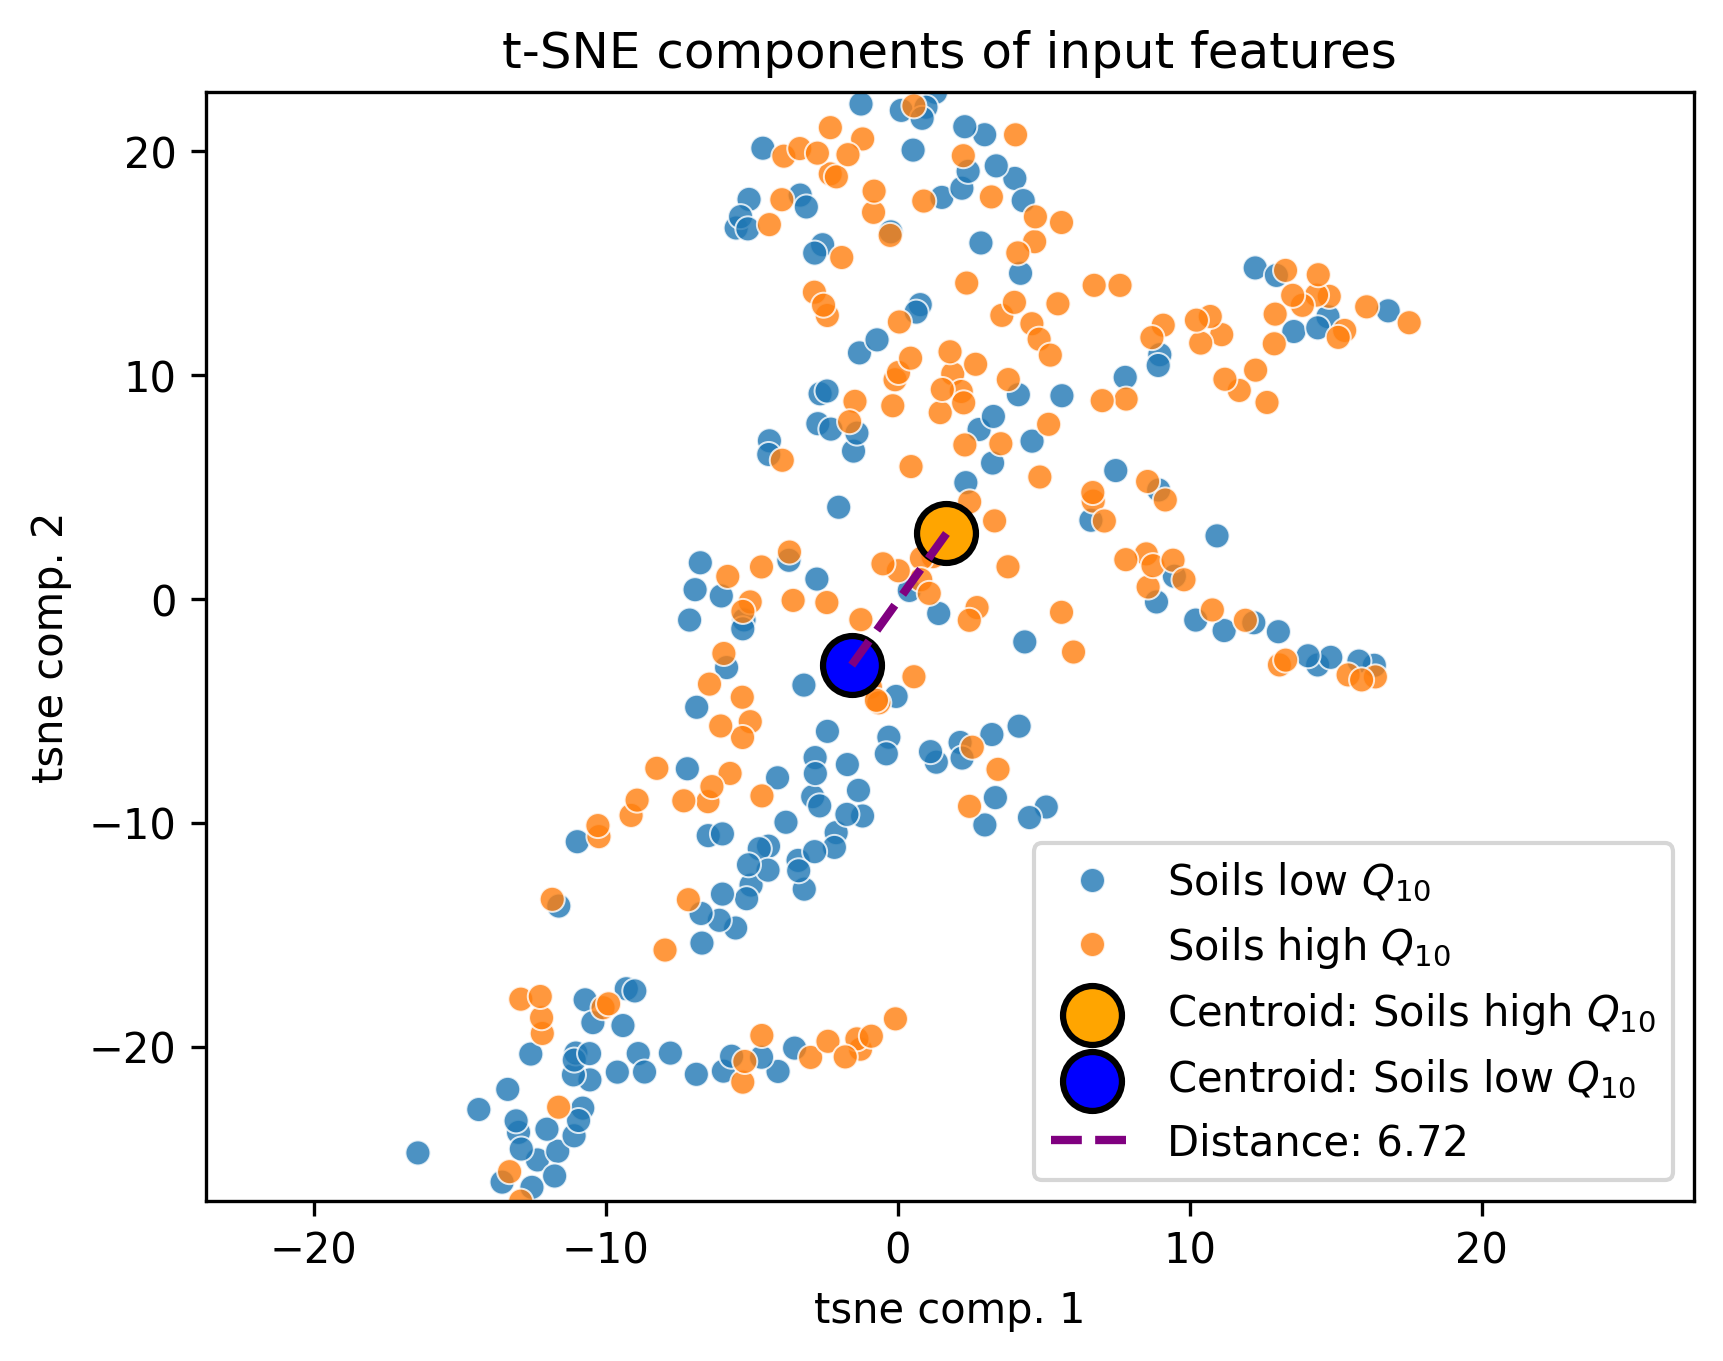

Distance between centroids (input features): 6.72


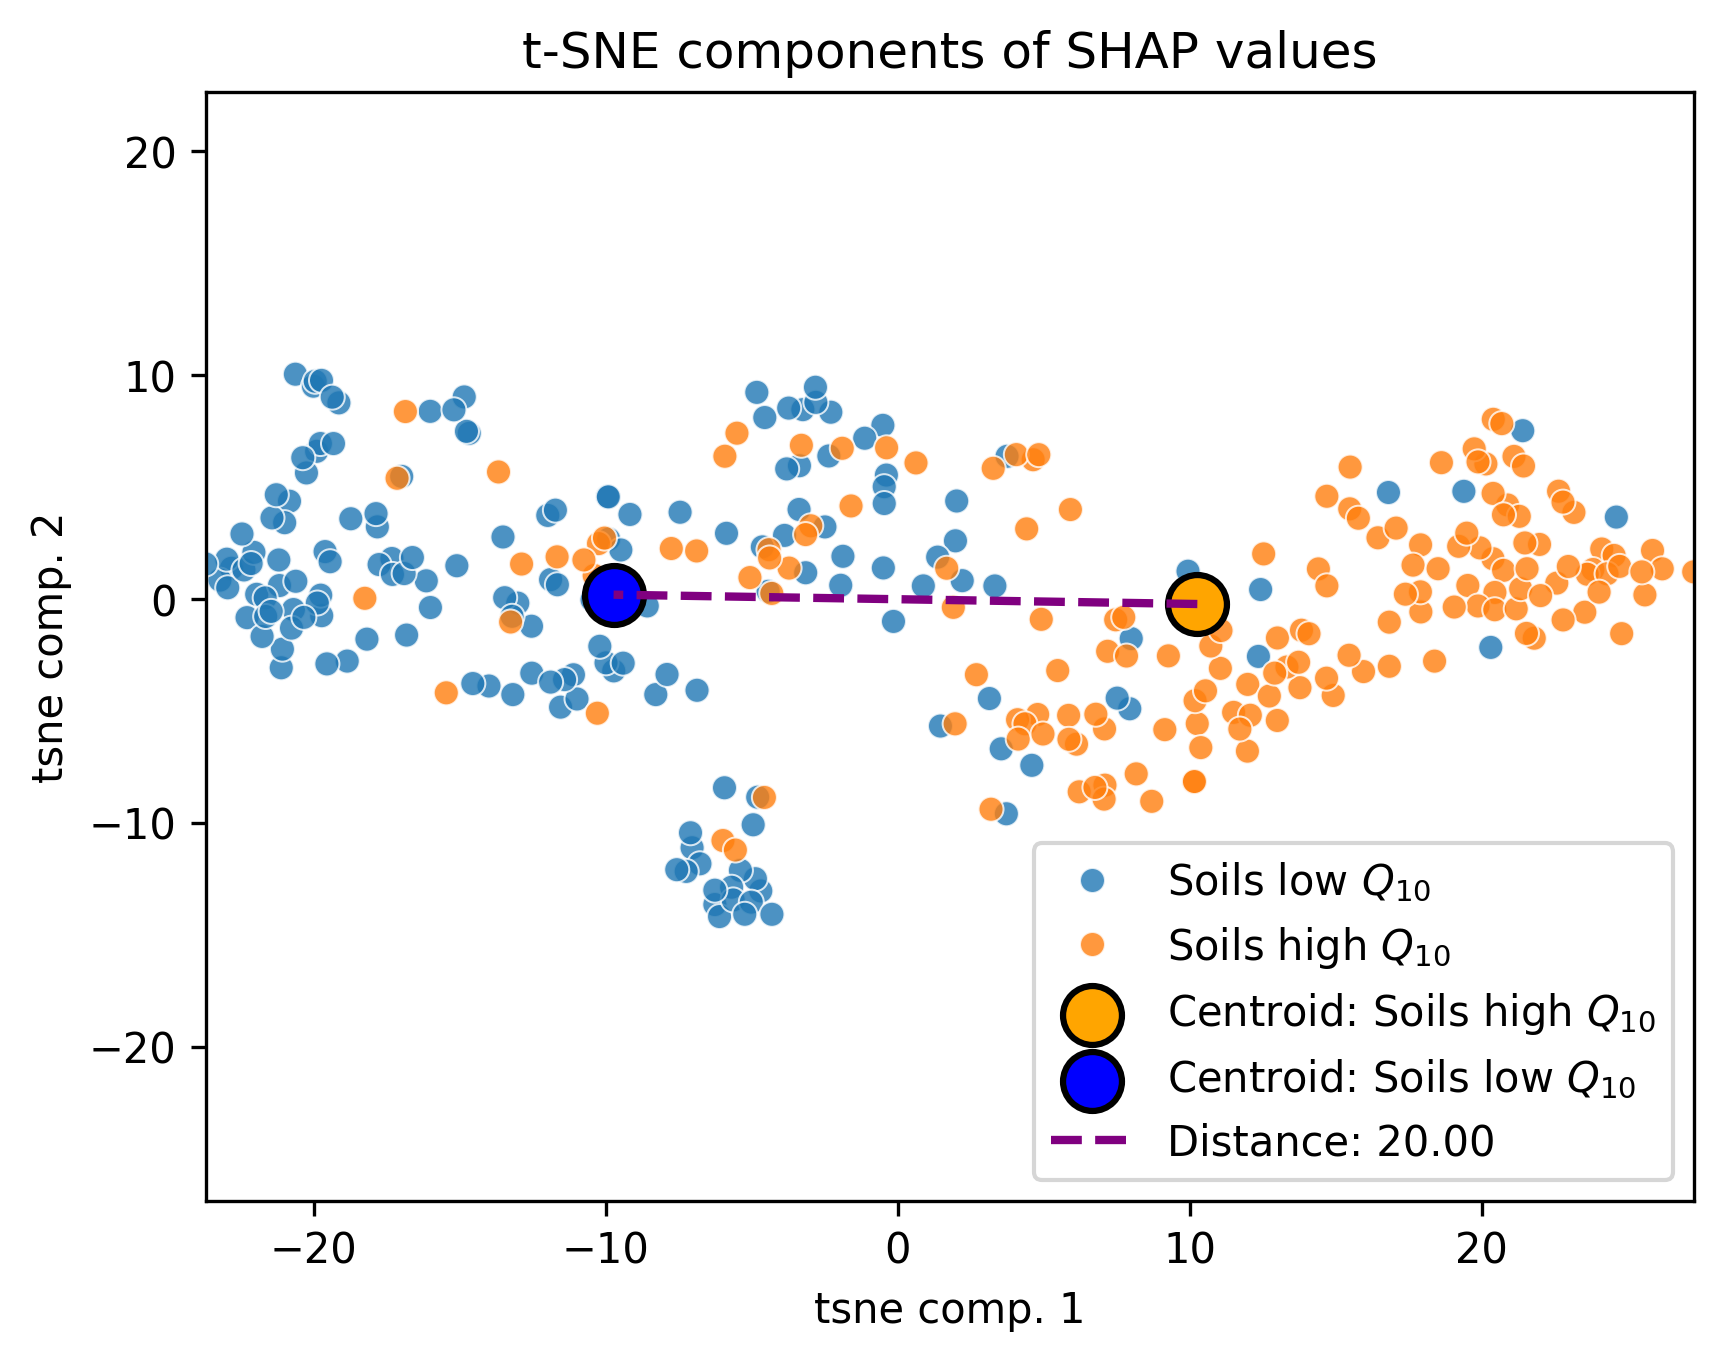

Distance between centroids (SHAP values): 20.00


In [28]:
# Function to calculate centroids and plot them with distance
def plot_tsne_with_centroids(df_tsne, title, x_limits=None, y_limits=None):
    # Calculate centroids for each class
    centroids = df_tsne.groupby('Target')[['tsne comp. 1', 'tsne comp. 2']].mean()
    
    # Compute Euclidean distance between centroids
    centroid_coords = centroids.values
    distance = np.linalg.norm(centroid_coords[0] - centroid_coords[1])
    
    # Define custom colors for centroids
    centroid_colors = {'Soils low $Q_{10}$': 'blue', 'Soils high $Q_{10}$': 'orange'}
    
    # Plot t-SNE points
    plt.figure(dpi=300)
    sns.scatterplot(data=df_tsne, x='tsne comp. 1', y='tsne comp. 2', hue="Target", alpha=0.8)
    
    # Plot centroids
    for label, row in centroids.iterrows():
        plt.scatter(
            row['tsne comp. 1'], row['tsne comp. 2'], 
            s=200, color=centroid_colors[label], 
            label=f'Centroid: {label}', edgecolor='black', linewidth=1.5
        )
    
    # Annotate distance on the plot with a custom color for the line
    plt.plot(
        [centroid_coords[0, 0], centroid_coords[1, 0]],
        [centroid_coords[0, 1], centroid_coords[1, 1]],
        linestyle='--', color='purple', linewidth=2, label=f'Distance: {distance:.2f}'
    )
    
    # Set the same scale for x and y axes if provided
    if x_limits:
        plt.xlim(x_limits)
    if y_limits:
        plt.ylim(y_limits)
    
    # Add title and legend
    plt.title(title)
    plt.legend()
    plt.show()
    
    return distance

# Determine the global axis limits
x_min = min(df_tsne['tsne comp. 1'].min(), df_tsne_shap['tsne comp. 1'].min())
x_max = max(df_tsne['tsne comp. 1'].max(), df_tsne_shap['tsne comp. 1'].max())
y_min = min(df_tsne['tsne comp. 2'].min(), df_tsne_shap['tsne comp. 2'].min())
y_max = max(df_tsne['tsne comp. 2'].max(), df_tsne_shap['tsne comp. 2'].max())

# Define axis limits
x_limits = (x_min, x_max)
y_limits = (y_min, y_max)

# Plot for input features
distance_input = plot_tsne_with_centroids(df_tsne, 't-SNE components of input features', x_limits, y_limits)
print(f'Distance between centroids (input features): {distance_input:.2f}')

# Plot for SHAP values
distance_shap = plot_tsne_with_centroids(df_tsne_shap, 't-SNE components of SHAP values', x_limits, y_limits)
print(f'Distance between centroids (SHAP values): {distance_shap:.2f}')


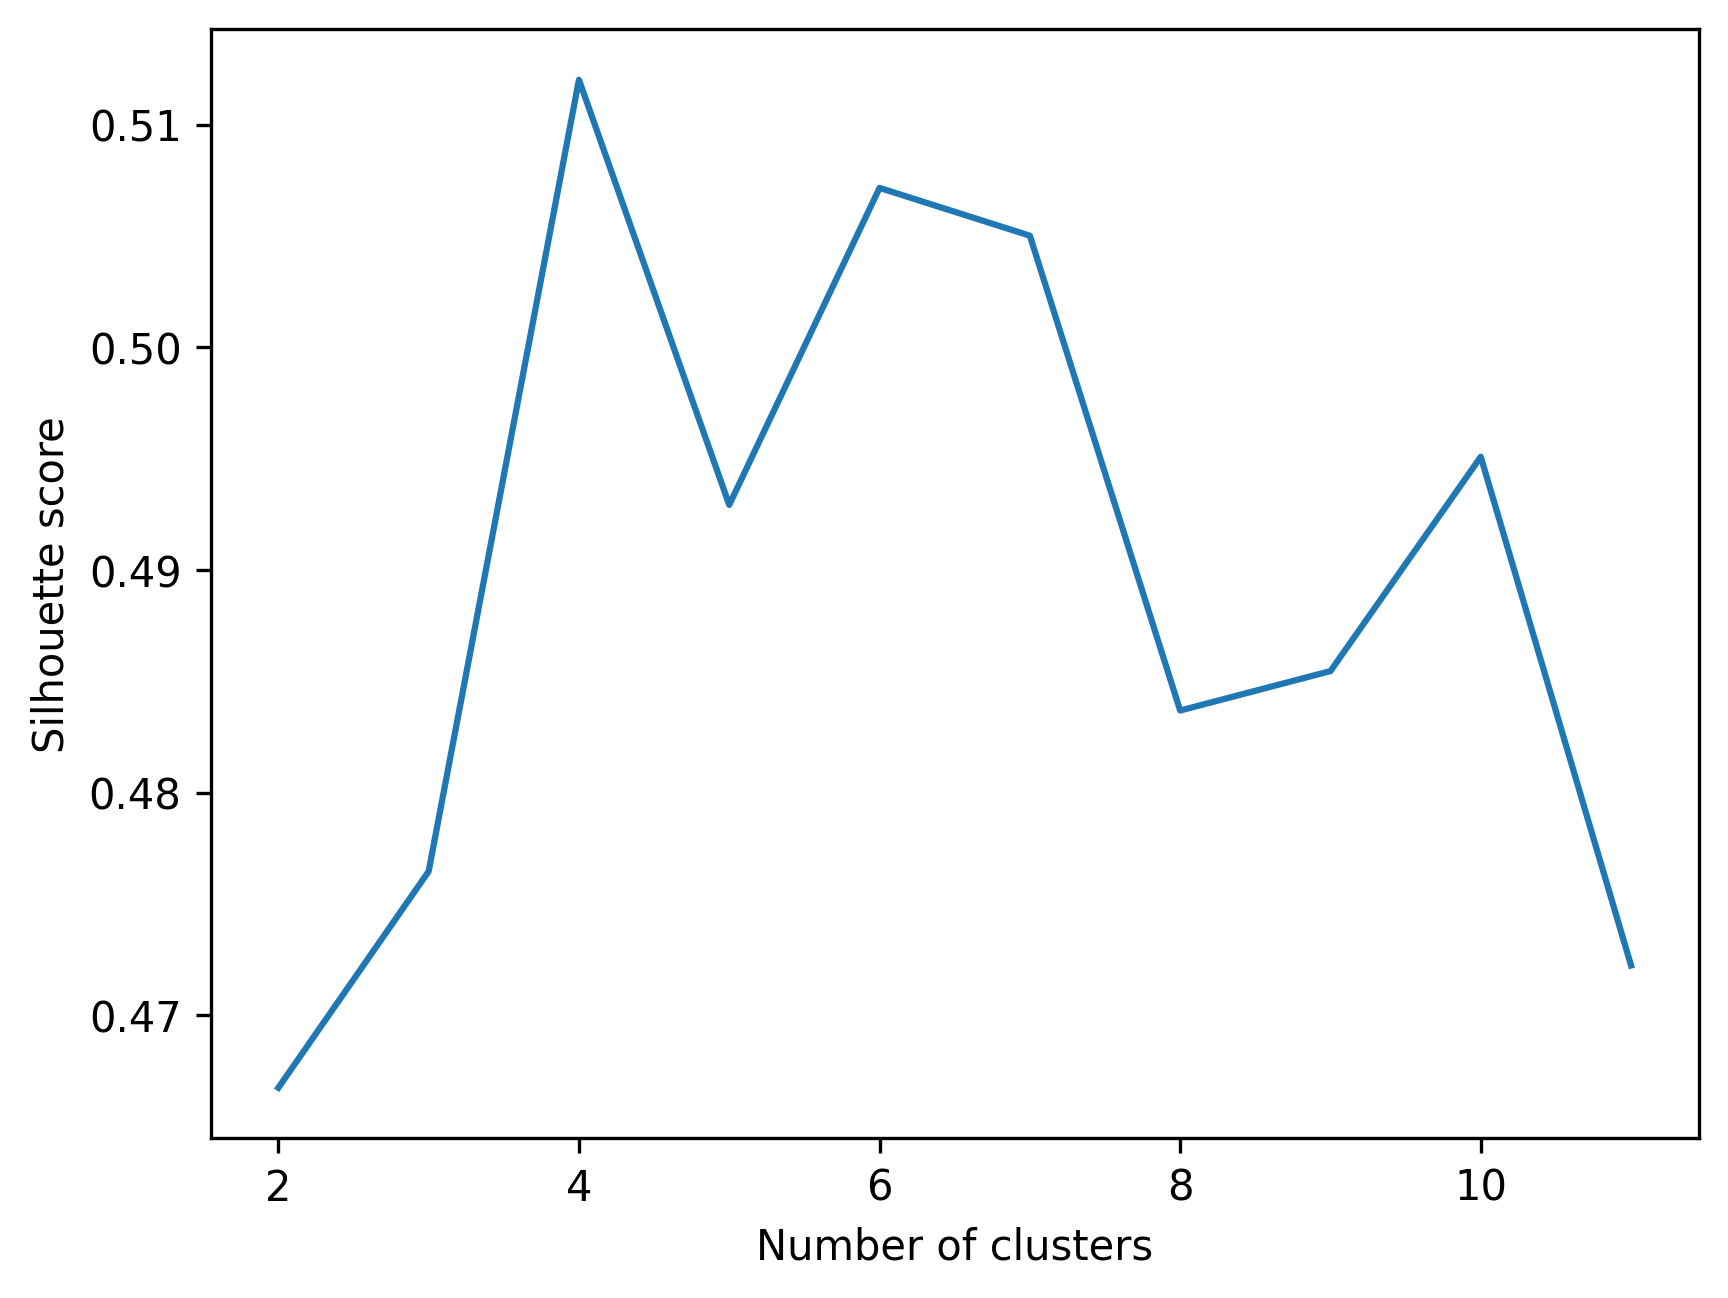

/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_34146/1805093705.py:31: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(data=X_k_2d, x=X_k_2d.iloc[:, 0], y=X_k_2d.iloc[:, 1], hue=y_km_2d + 1, palette=custom_palette, legend='full')


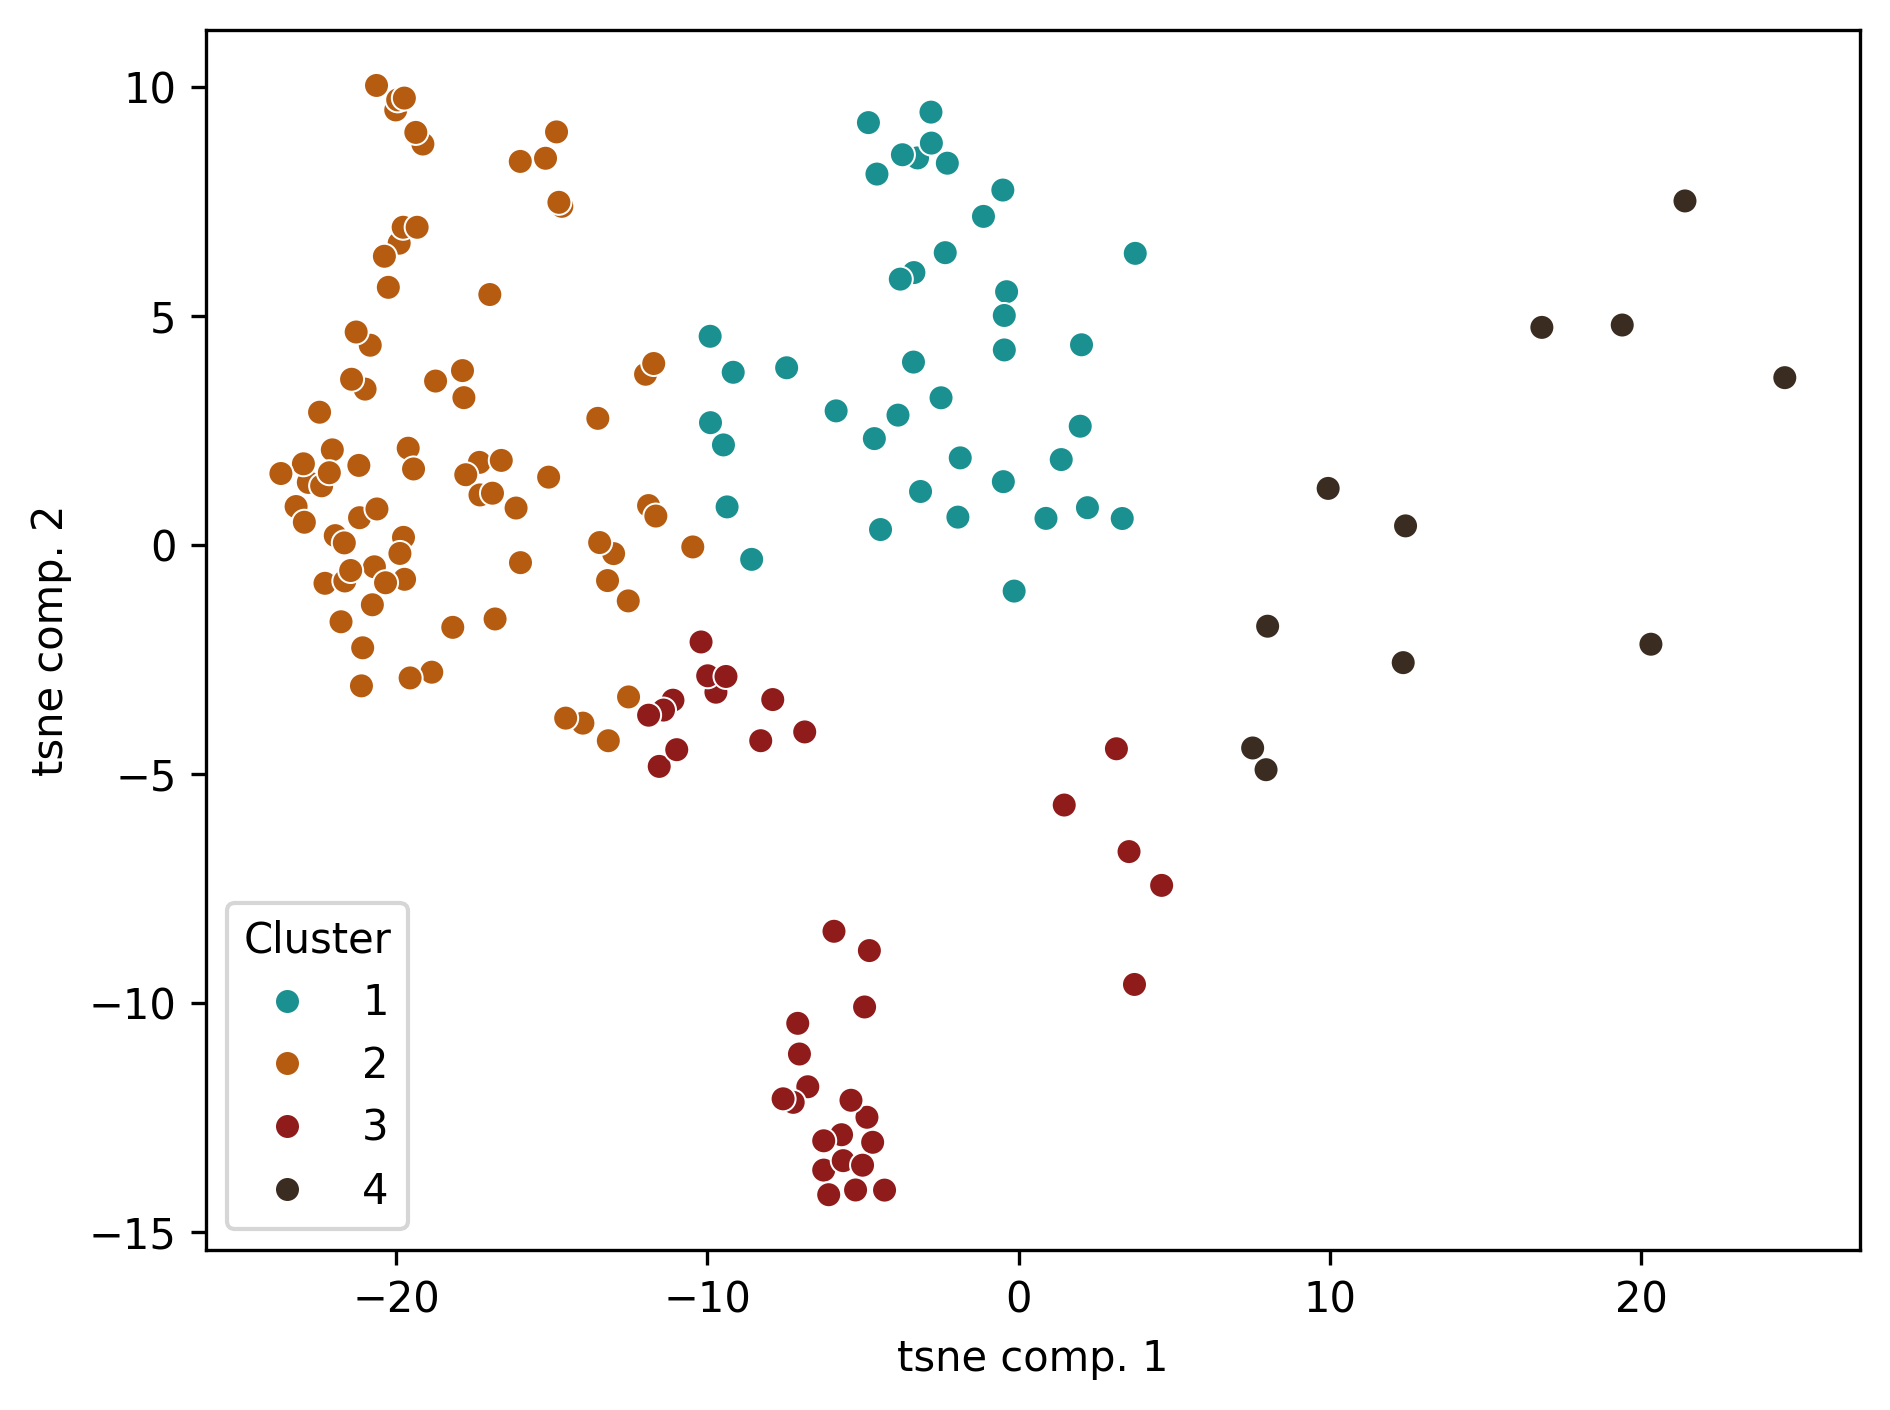

/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_34146/1805093705.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_kmeans, x="Clusters", y="Probability", order=sorted_clusters, palette=sorted_palette)


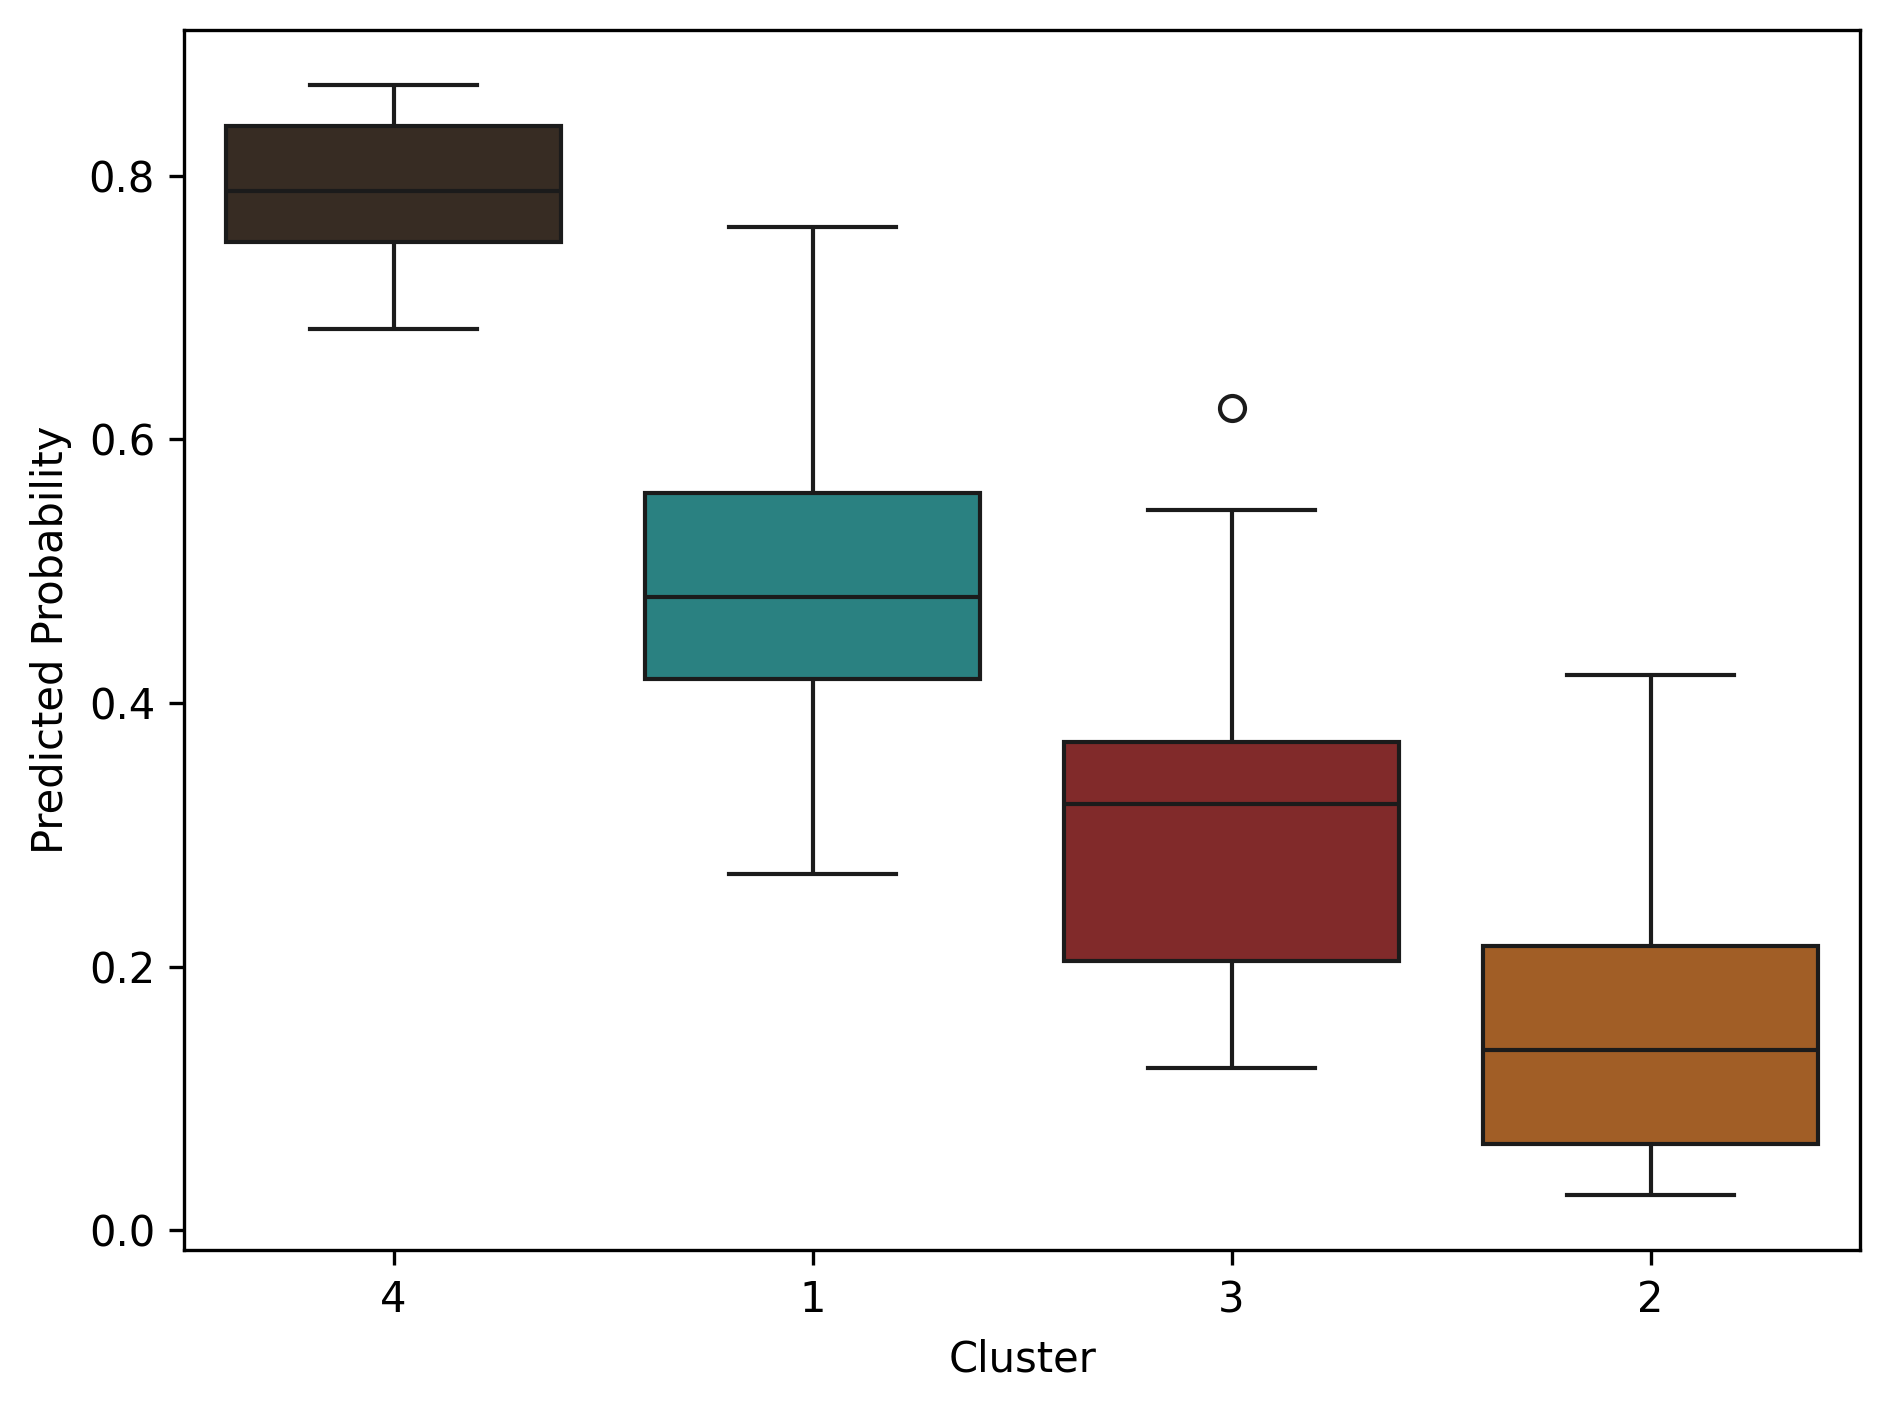

In [24]:
# K-means clustering on tsne components of SHAP values for class 1
X_k_2d = df_tsne_shap[df_tsne_shap['Target'] == 'Soils low $Q_{10}$'].iloc[:, :2]
probabilities = df_tsne_shap[df_tsne_shap['Target'] == 'Soils low $Q_{10}$']['Probability']

# Clustering on 2D tsne components
silhouettes_2d = []
kmin, kmax = 2, 11

for k in range(kmin, kmax + 1):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X_k_2d)
    labels_2d = km.labels_
    silhouettes_2d.append(silhouette_score(X_k_2d, labels_2d, metric='euclidean'))

plt.figure(dpi=300)
plt.plot(range(kmin, kmax + 1), silhouettes_2d)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# Choosing the best k based on the highest silhouette score
best_k_2d = silhouettes_2d.index(max(silhouettes_2d)) + kmin
km_2d = KMeans(n_clusters=best_k_2d, init='k-means++', n_init=10, max_iter=300, random_state=0)
y_km_2d = km_2d.fit_predict(X_k_2d)

# Define custom colors for the clusters
custom_palette = sns.color_palette(['#1b9090', "#b65c11", '#901b1b', "#3a2c20", '#719842', '#e7a504'])

# Scatterplot for t-SNE components with clusters (ensure color consistency)
plt.figure(dpi=300)
sns.scatterplot(data=X_k_2d, x=X_k_2d.iloc[:, 0], y=X_k_2d.iloc[:, 1], hue=y_km_2d + 1, palette=custom_palette, legend='full')
plt.xlabel("tsne comp. 1")
plt.ylabel("tsne comp. 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Prepare the DataFrame for the box plot
X_kmeans = X_k_2d 
X_kmeans['Probability'] = probabilities.values
X_kmeans['Clusters'] =y_km_2d + 1
# Ensure that cluster labels in X_kmeans are integers for consistency
X_kmeans['Clusters'] = X_kmeans['Clusters'].astype(int)

# Compute the median probability for each cluster and sort clusters by median
cluster_medians = X_kmeans.groupby('Clusters')['Probability'].median().sort_values(ascending=False)
sorted_clusters = cluster_medians.index.tolist()  # List of clusters sorted by median

# Create a color mapping based on sorted clusters
sorted_palette = [custom_palette[cluster - 1] for cluster in sorted_clusters]  # Adjust to zero-based index

# Plot the box plot, ordered by median, with consistent colors
plt.figure(dpi=300)
sns.boxplot(data=X_kmeans, x="Clusters", y="Probability", order=sorted_clusters, palette=sorted_palette)
plt.xlabel('Cluster')
plt.ylabel('Predicted Probability')
plt.tight_layout()
plt.show()

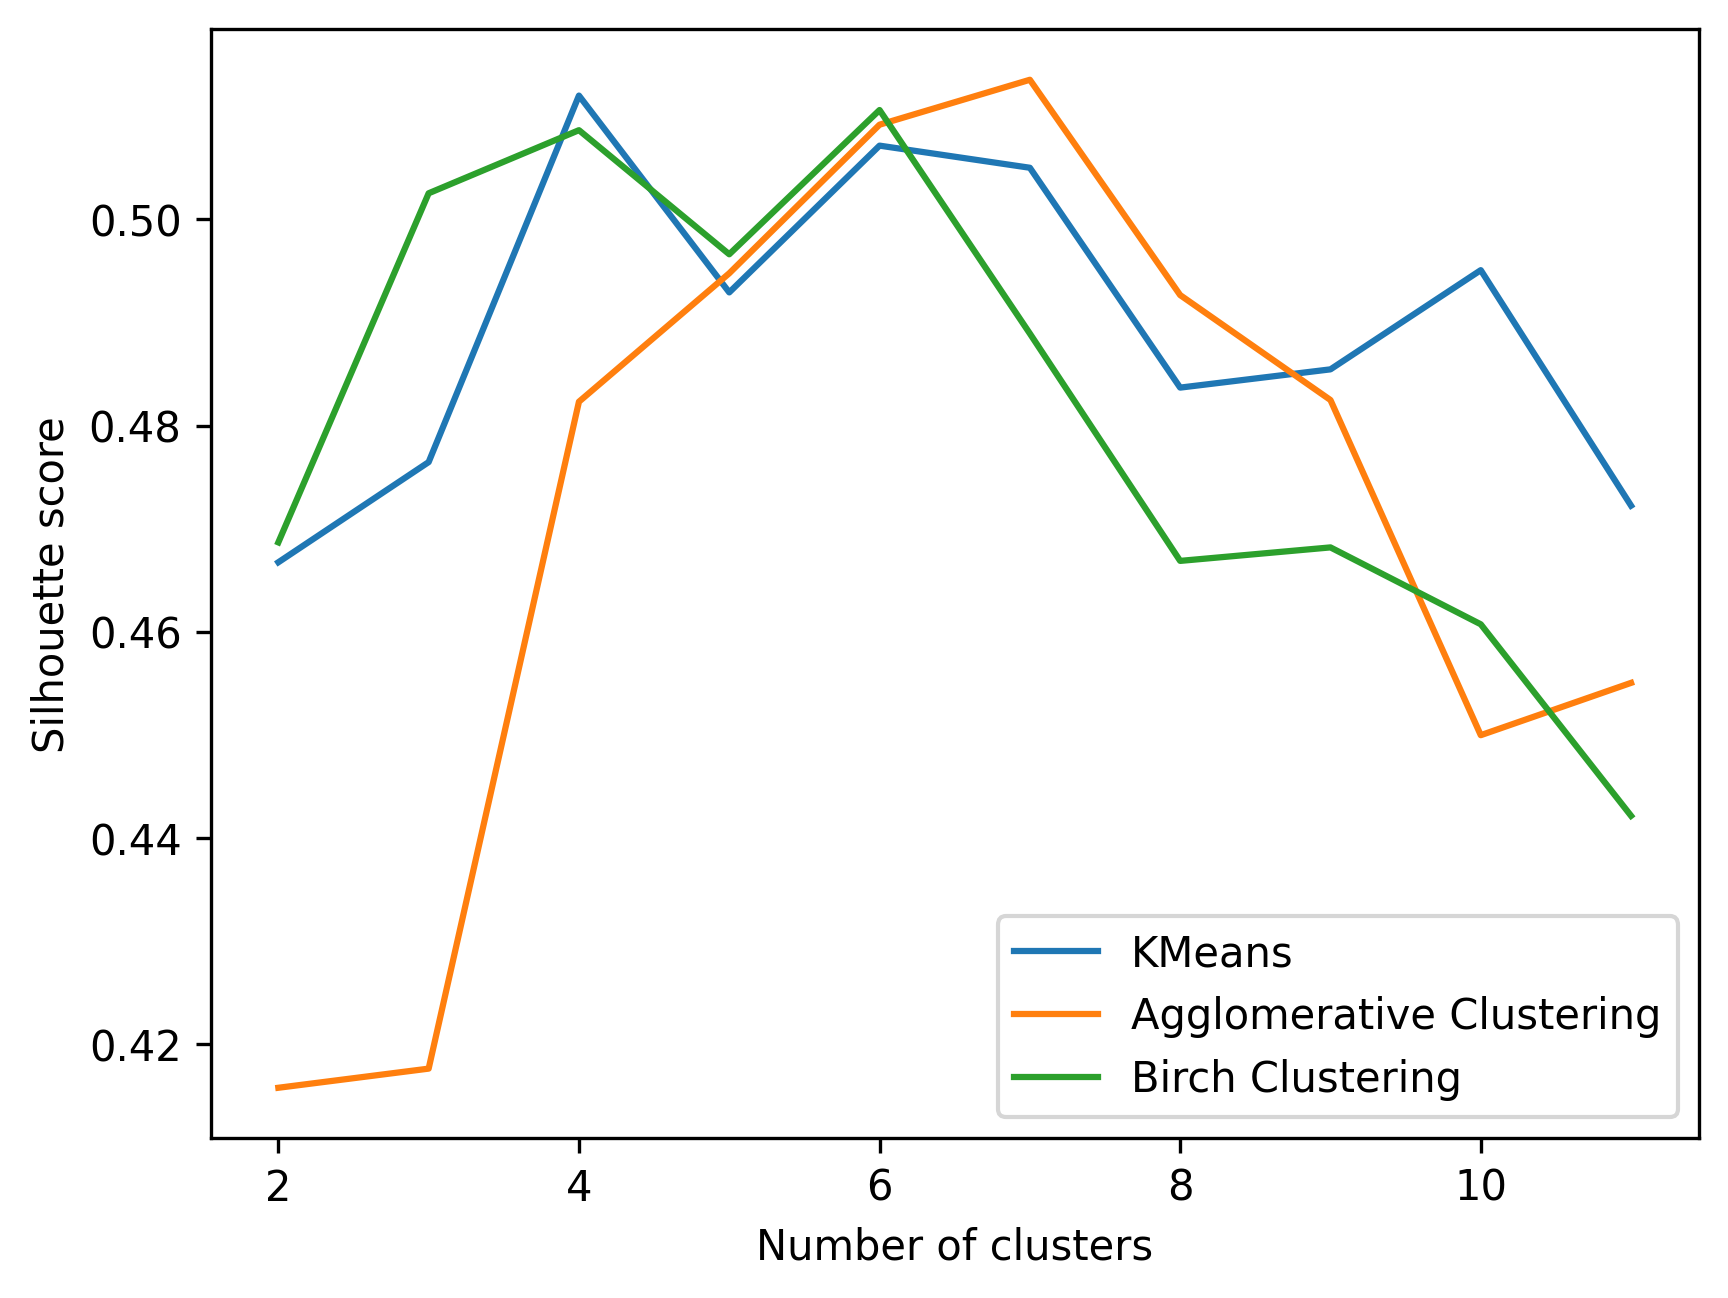

In [25]:
# K-means clustering on t-SNE components of SHAP values for class 1
X_k = df_tsne_shap[df_tsne_shap['Target'] == 'Soils low $Q_{10}$'].iloc[:, :2]
probabilities = df_tsne_shap[df_tsne_shap['Target'] == 'Soils low $Q_{10}$']['Probability']

# Initialize silhouette scores for different methods
silhouettes_kmeans = []
silhouettes_agg = []
silhouettes_birch = []

kmin, kmax = 2, 11

# KMeans clustering
for k in range(kmin, kmax + 1):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X_k)
    labels = km.labels_
    silhouettes_kmeans.append(silhouette_score(X_k, labels, metric='euclidean'))

# Agglomerative Clustering
for k in range(kmin, kmax + 1):
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_k)
    silhouettes_agg.append(silhouette_score(X_k, labels, metric='euclidean'))

# Birch Clustering
for k in range(kmin, kmax + 1):
    birch = Birch(n_clusters=k)
    labels = birch.fit_predict(X_k)
    silhouettes_birch.append(silhouette_score(X_k, labels, metric='euclidean'))

# Define a color palette
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Combined plot for all methods
plt.figure(dpi=300)
plt.plot(range(kmin, kmax + 1), silhouettes_kmeans, label='KMeans', color=colors[0])
plt.plot(range(kmin, kmax + 1), silhouettes_agg, label='Agglomerative Clustering', color=colors[1])
plt.plot(range(kmin, kmax + 1), silhouettes_birch, label='Birch Clustering', color=colors[2])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.legend()
plt.show()


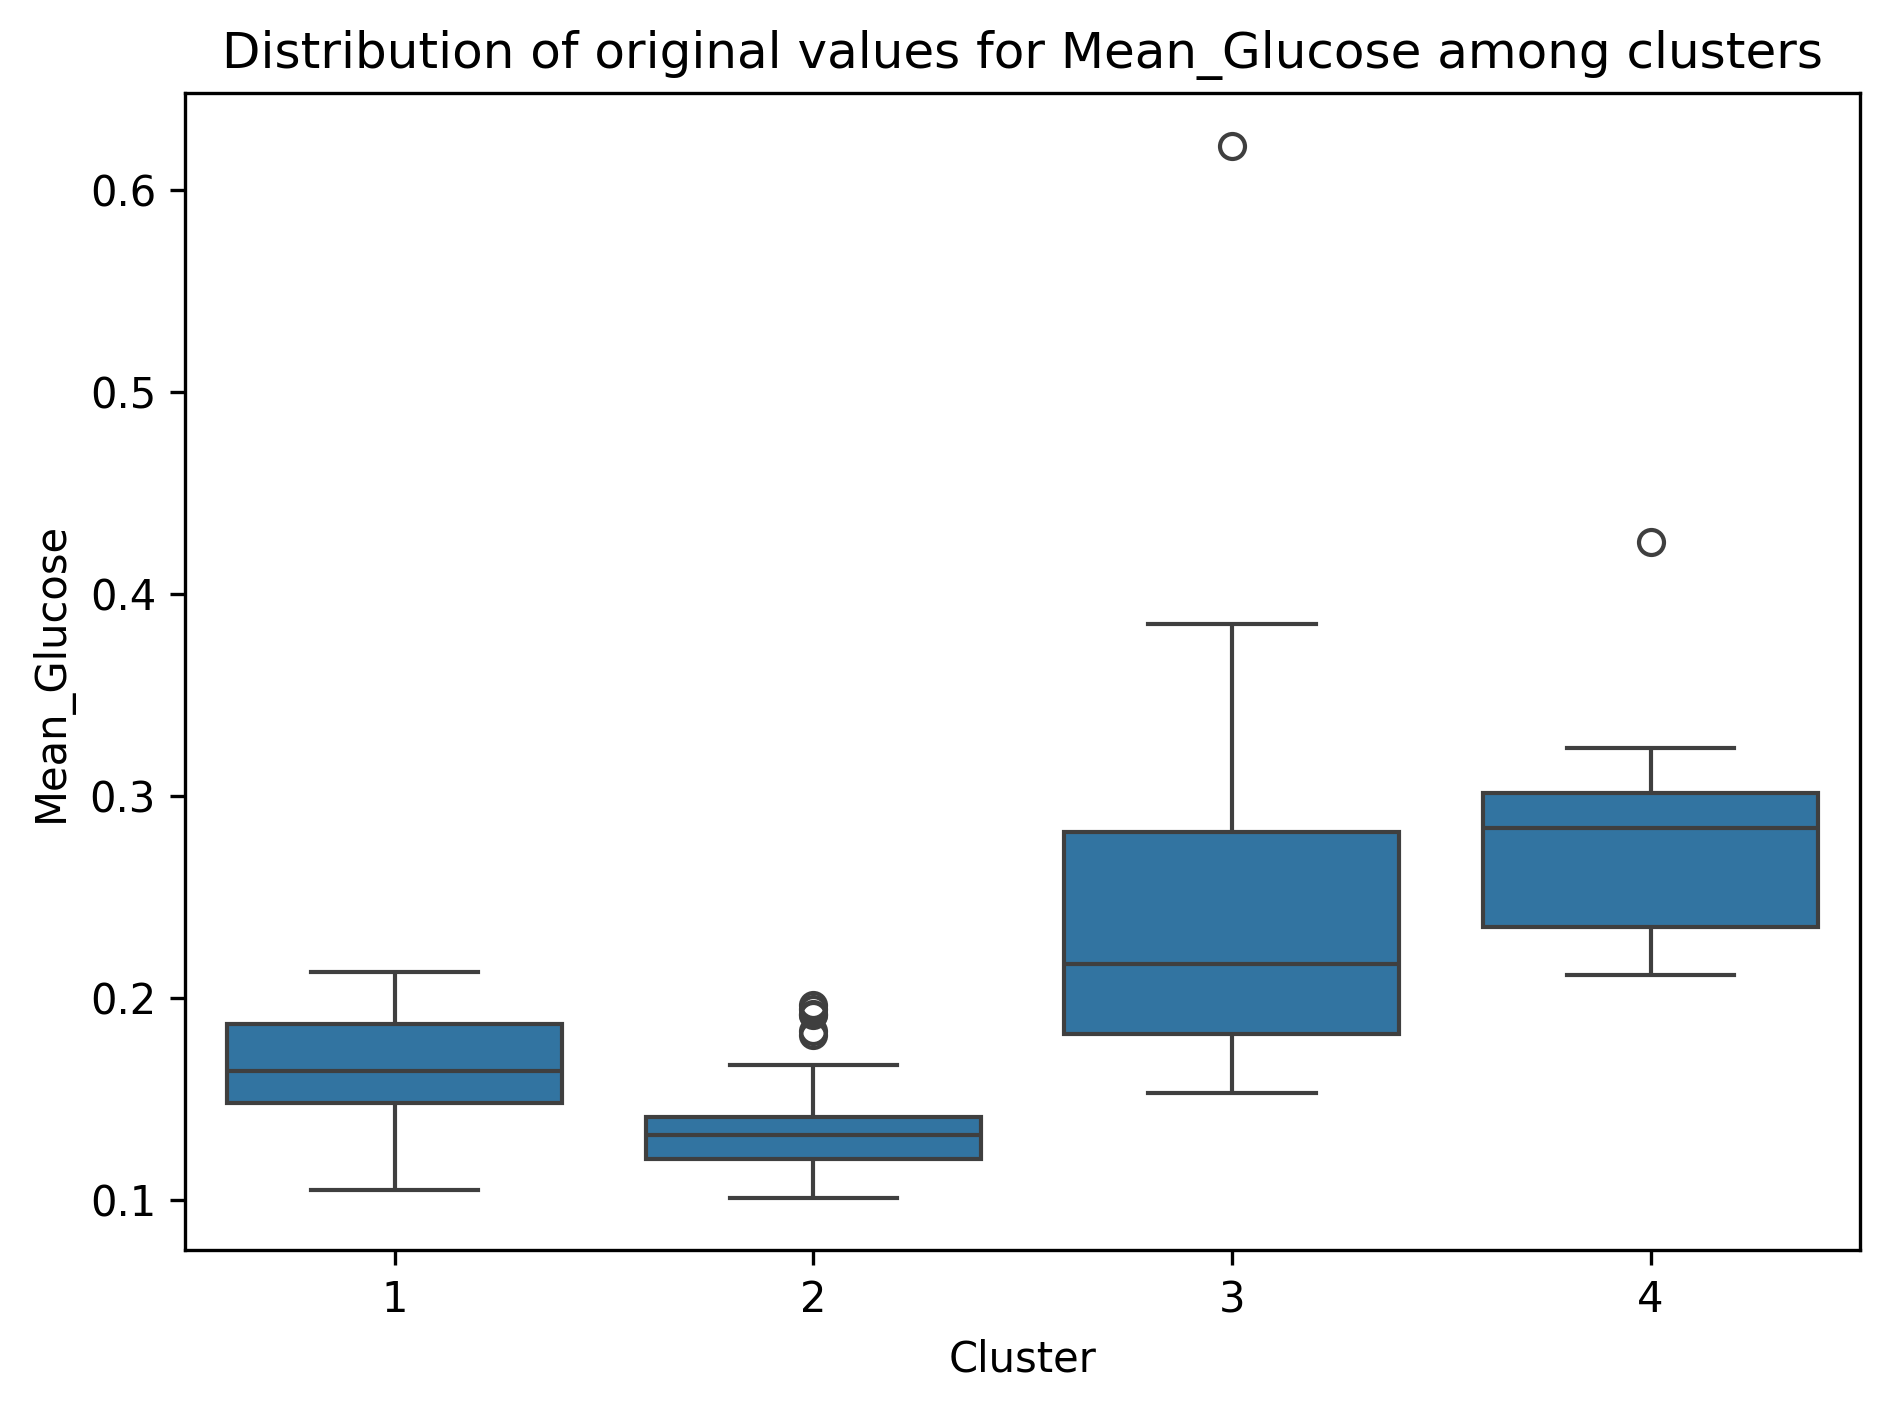

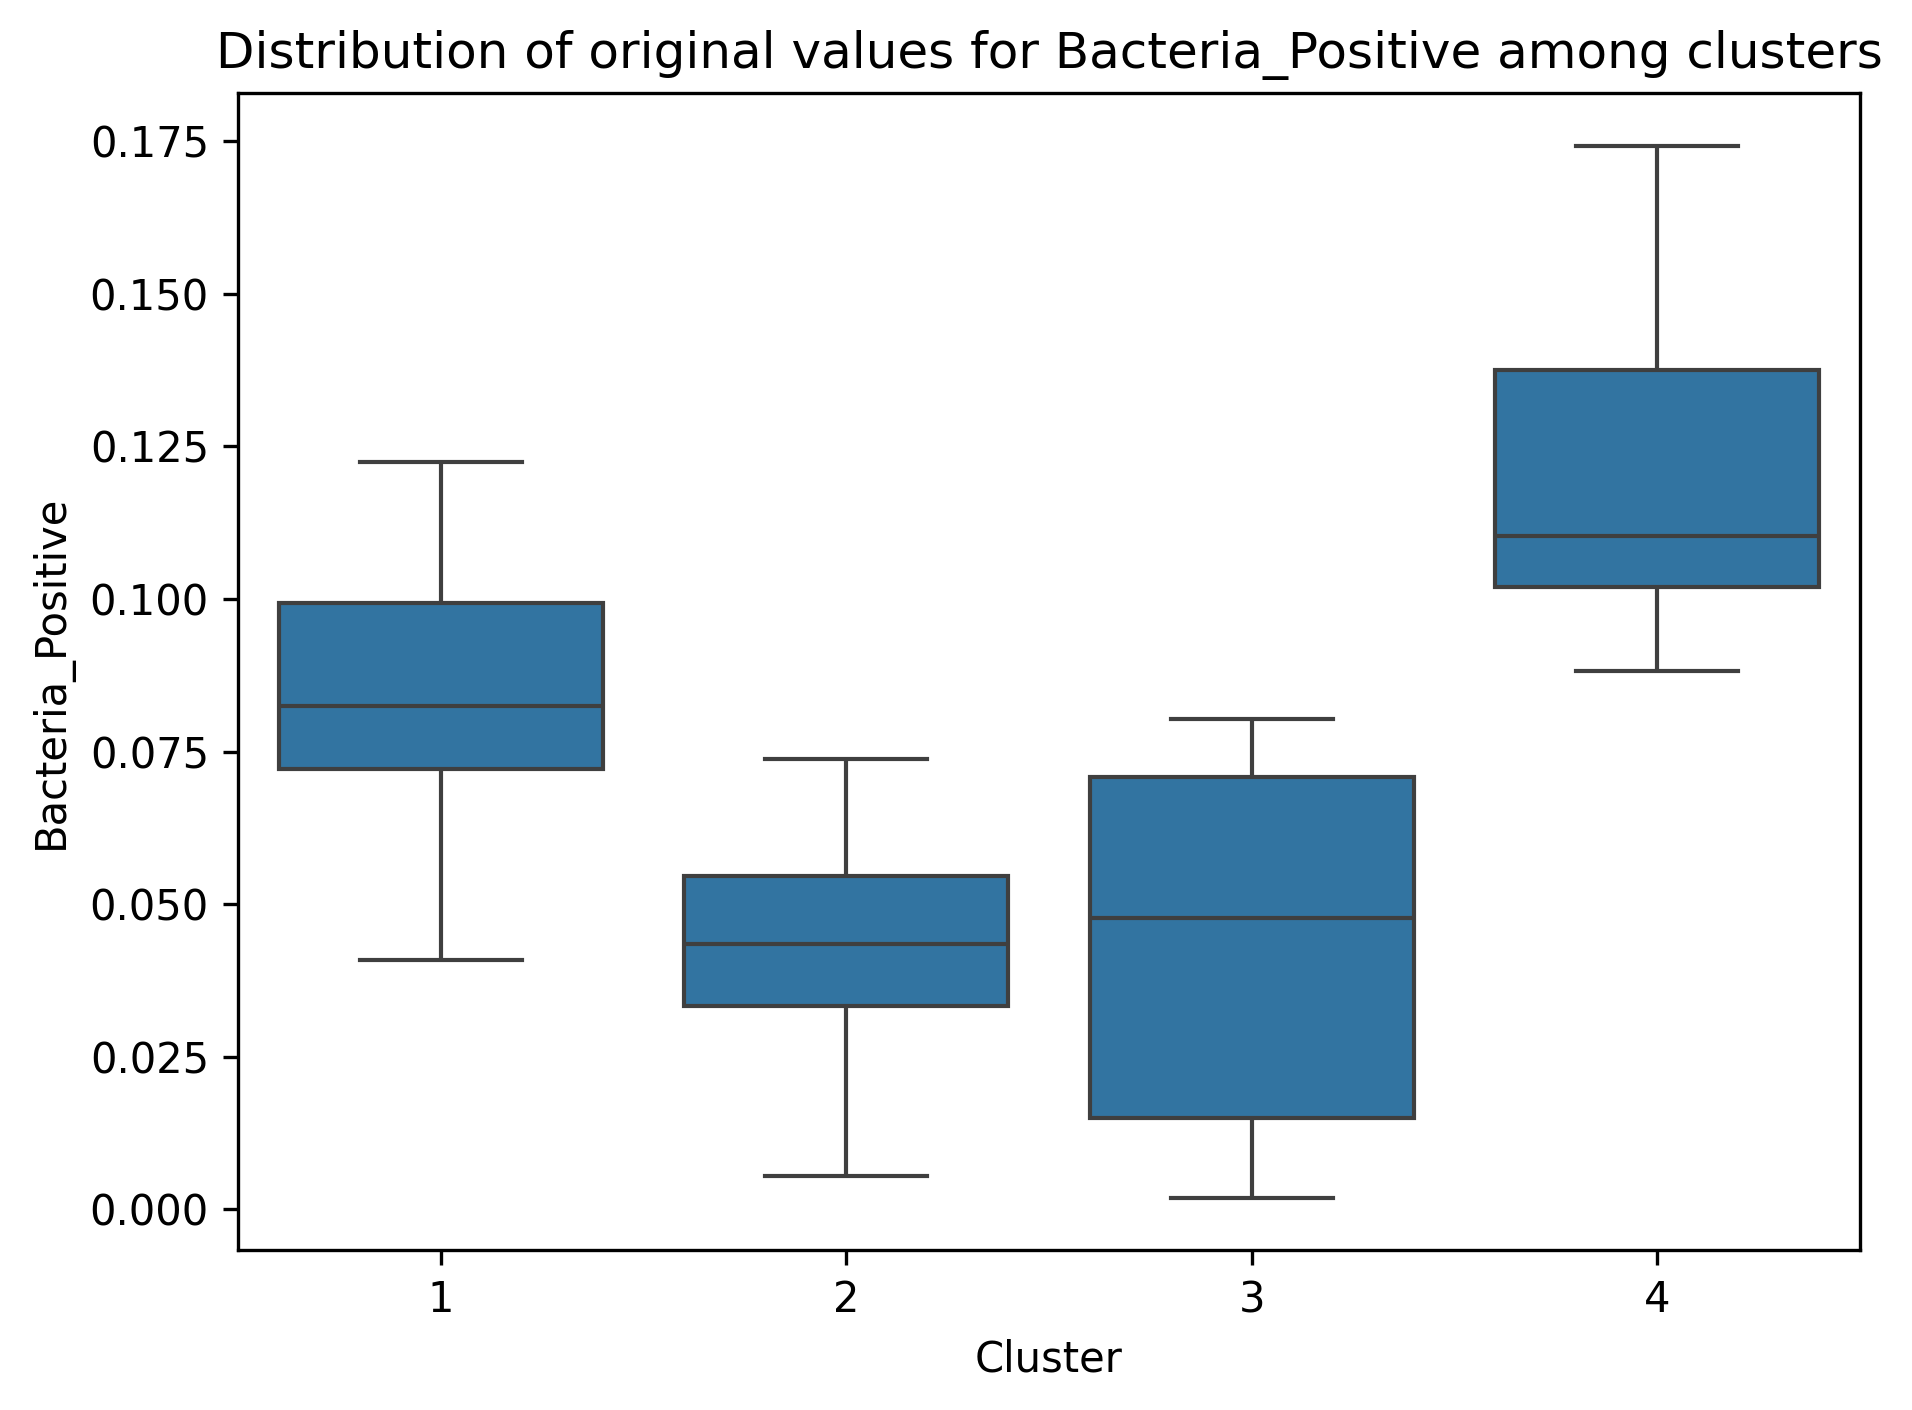

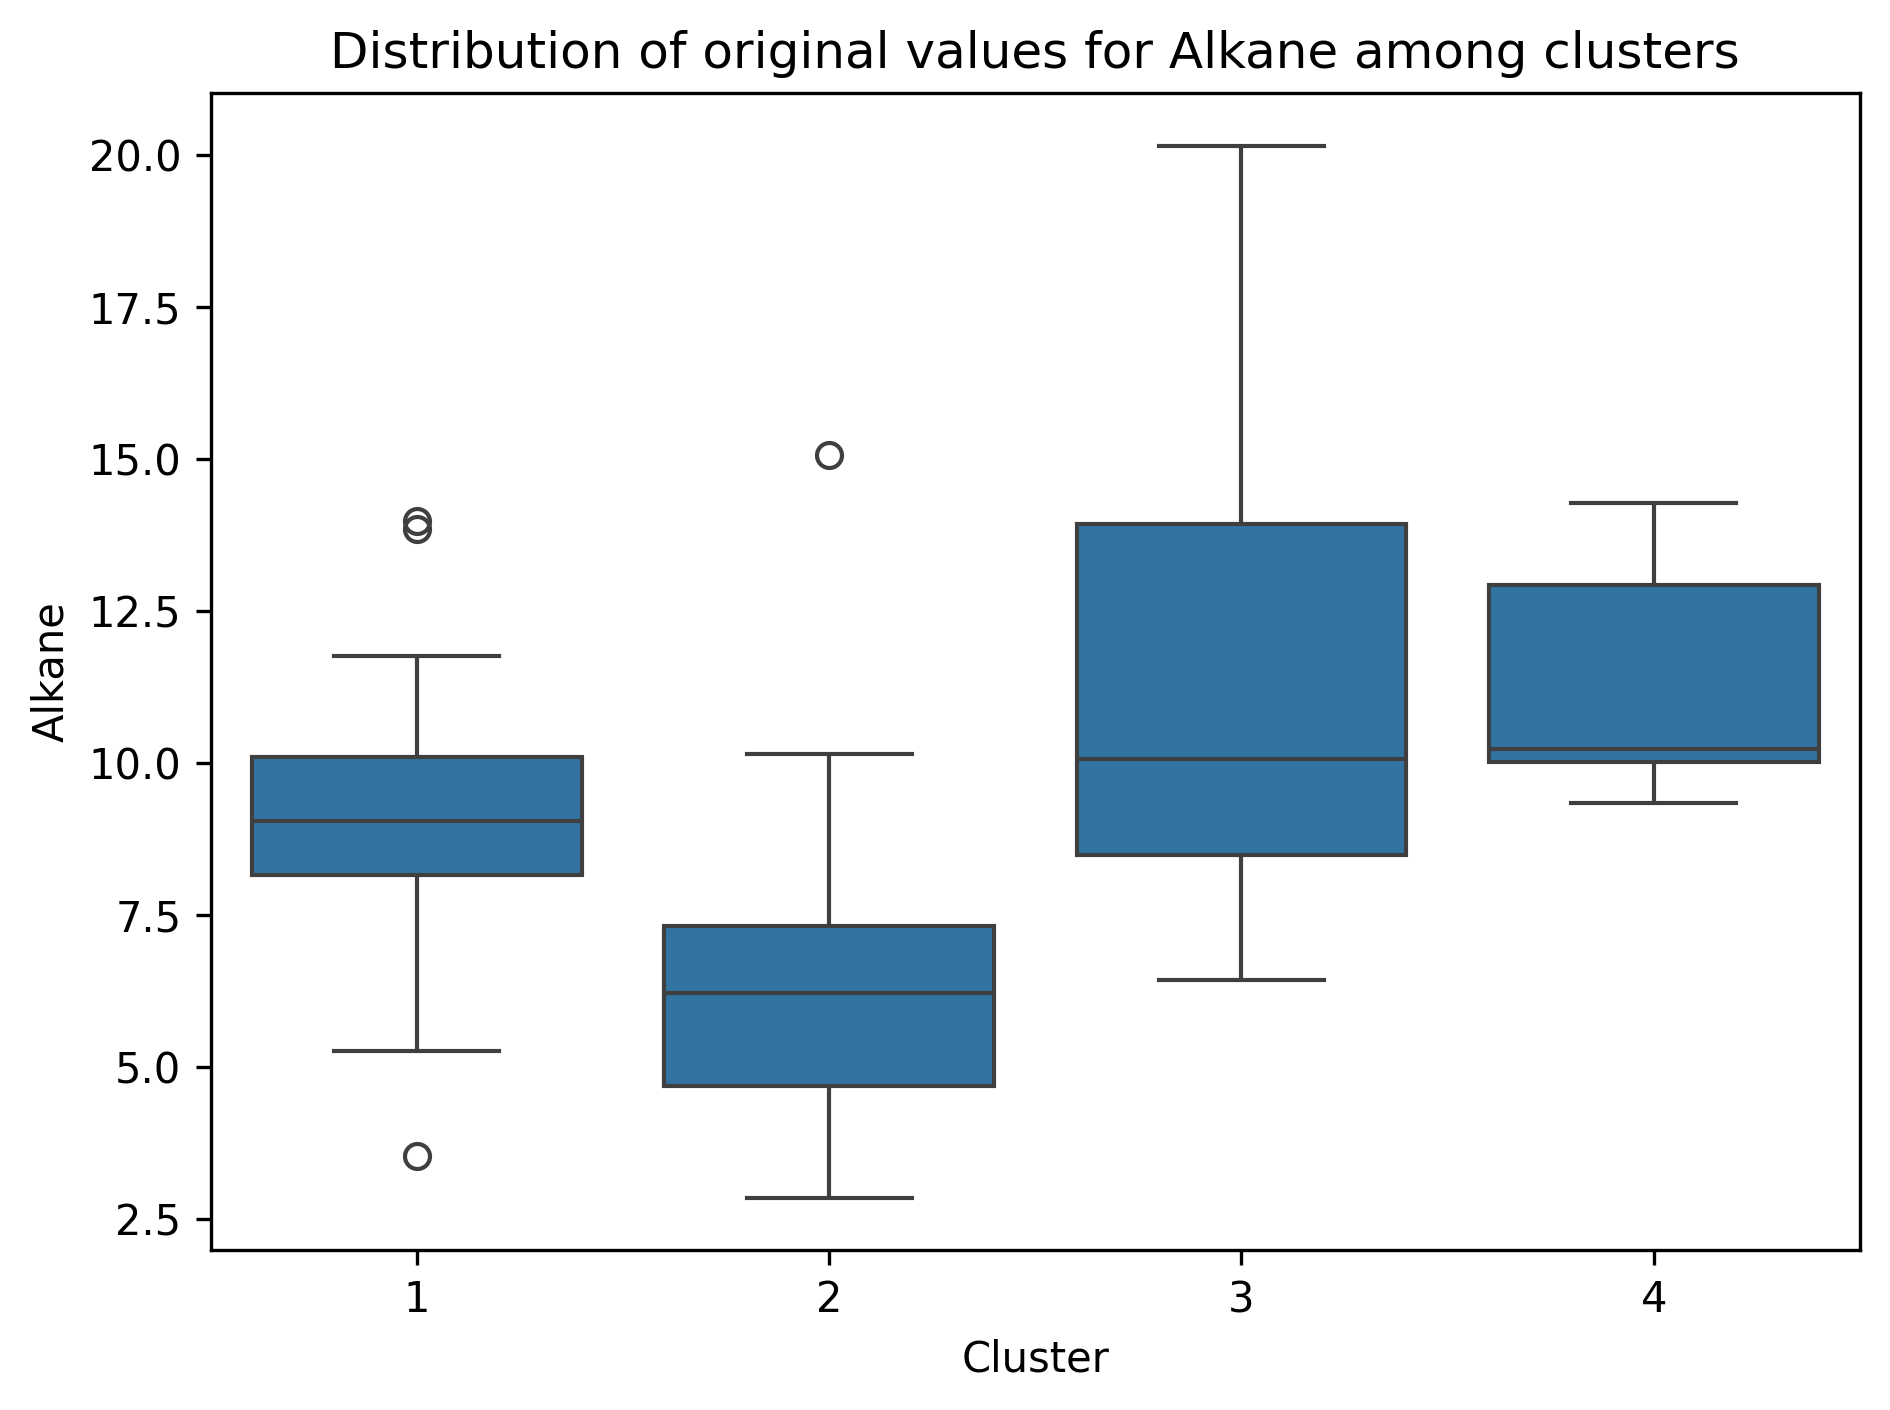

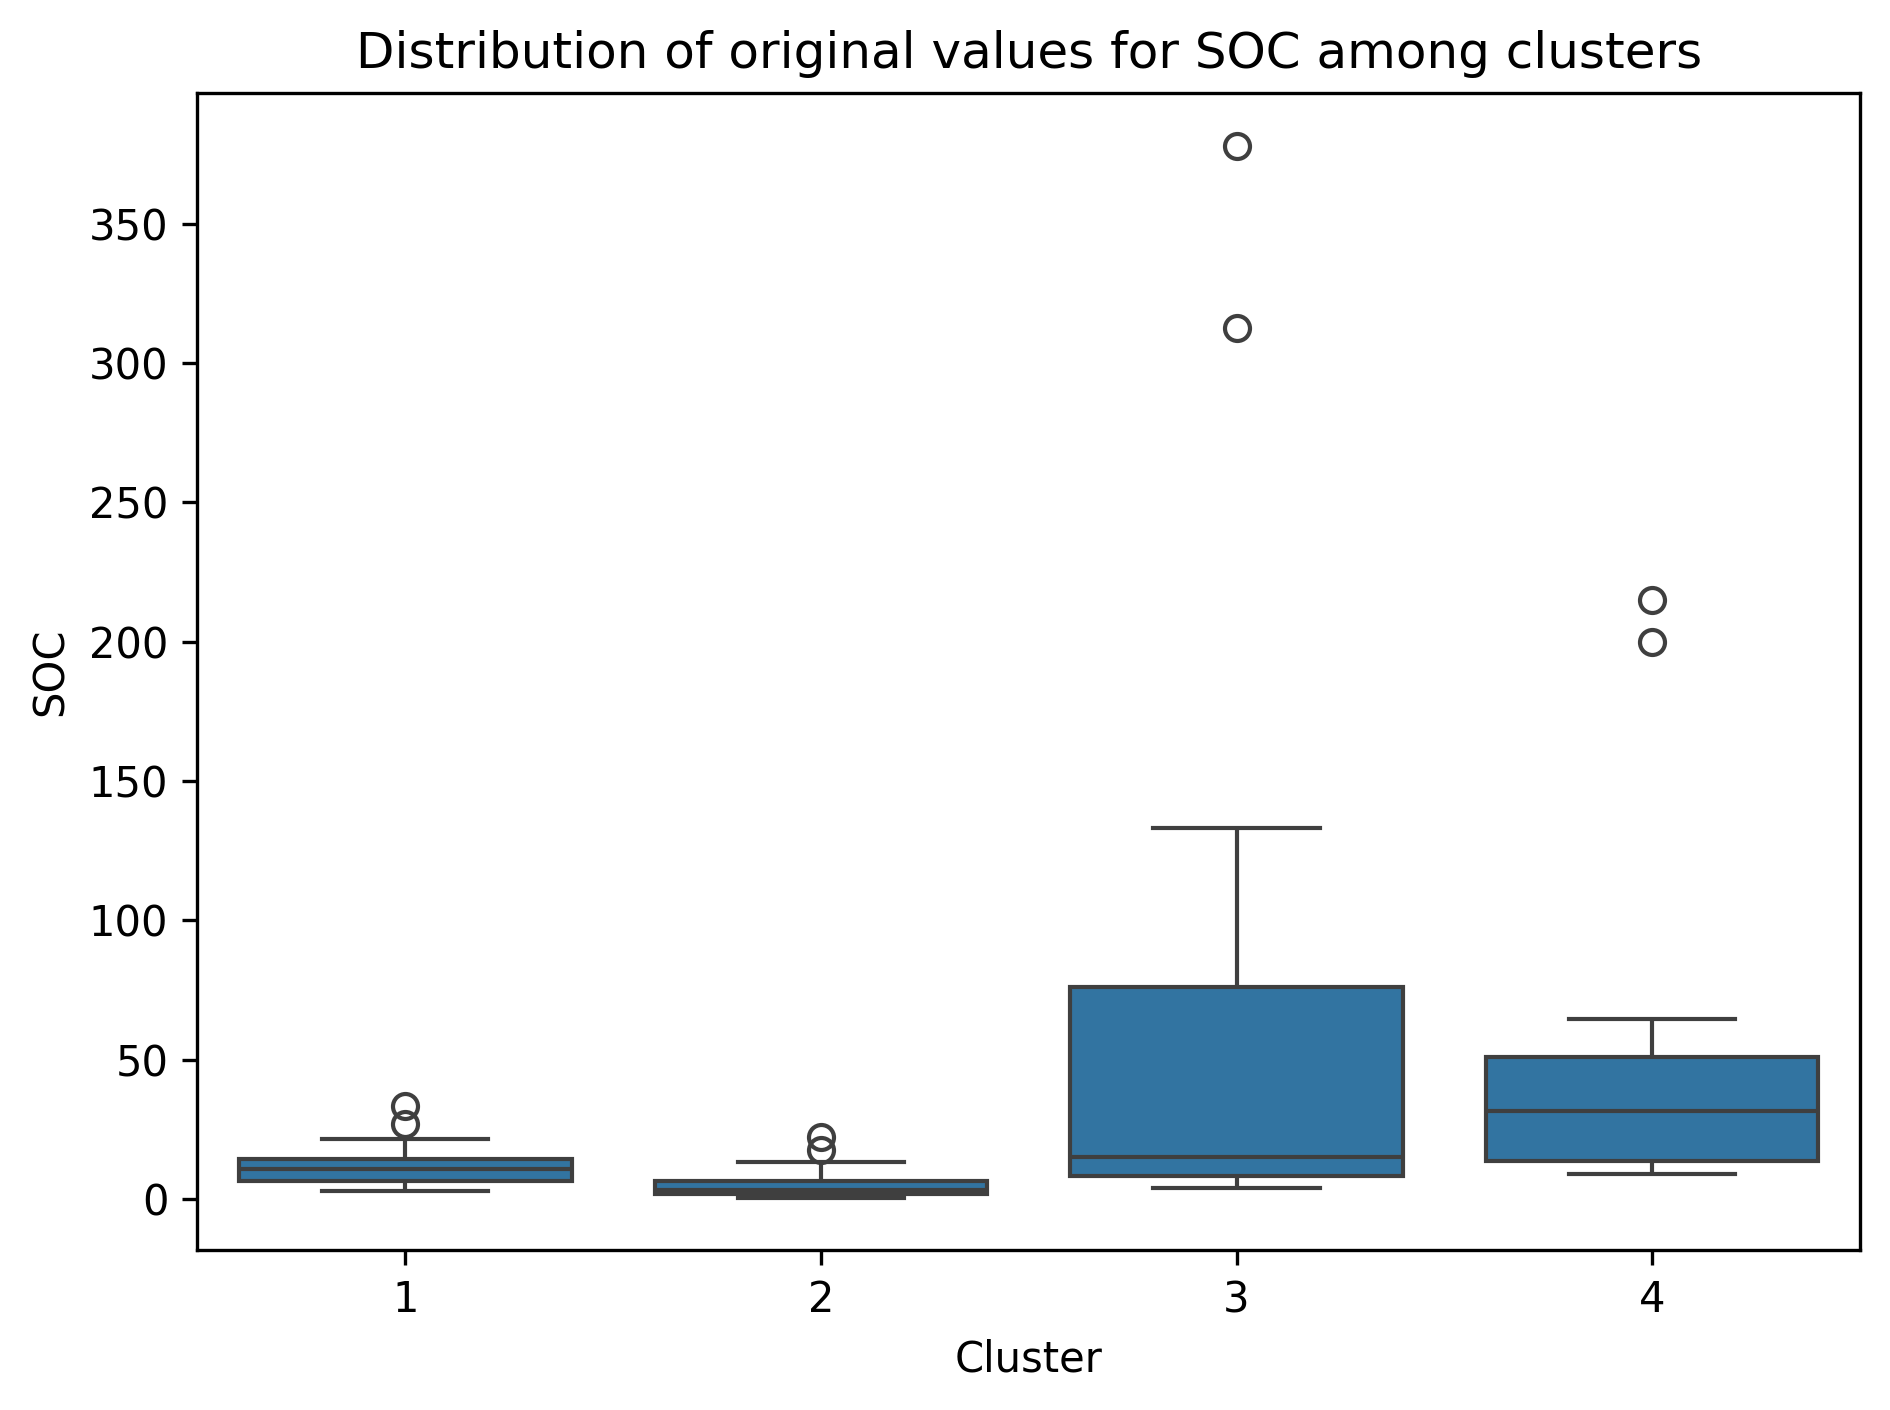

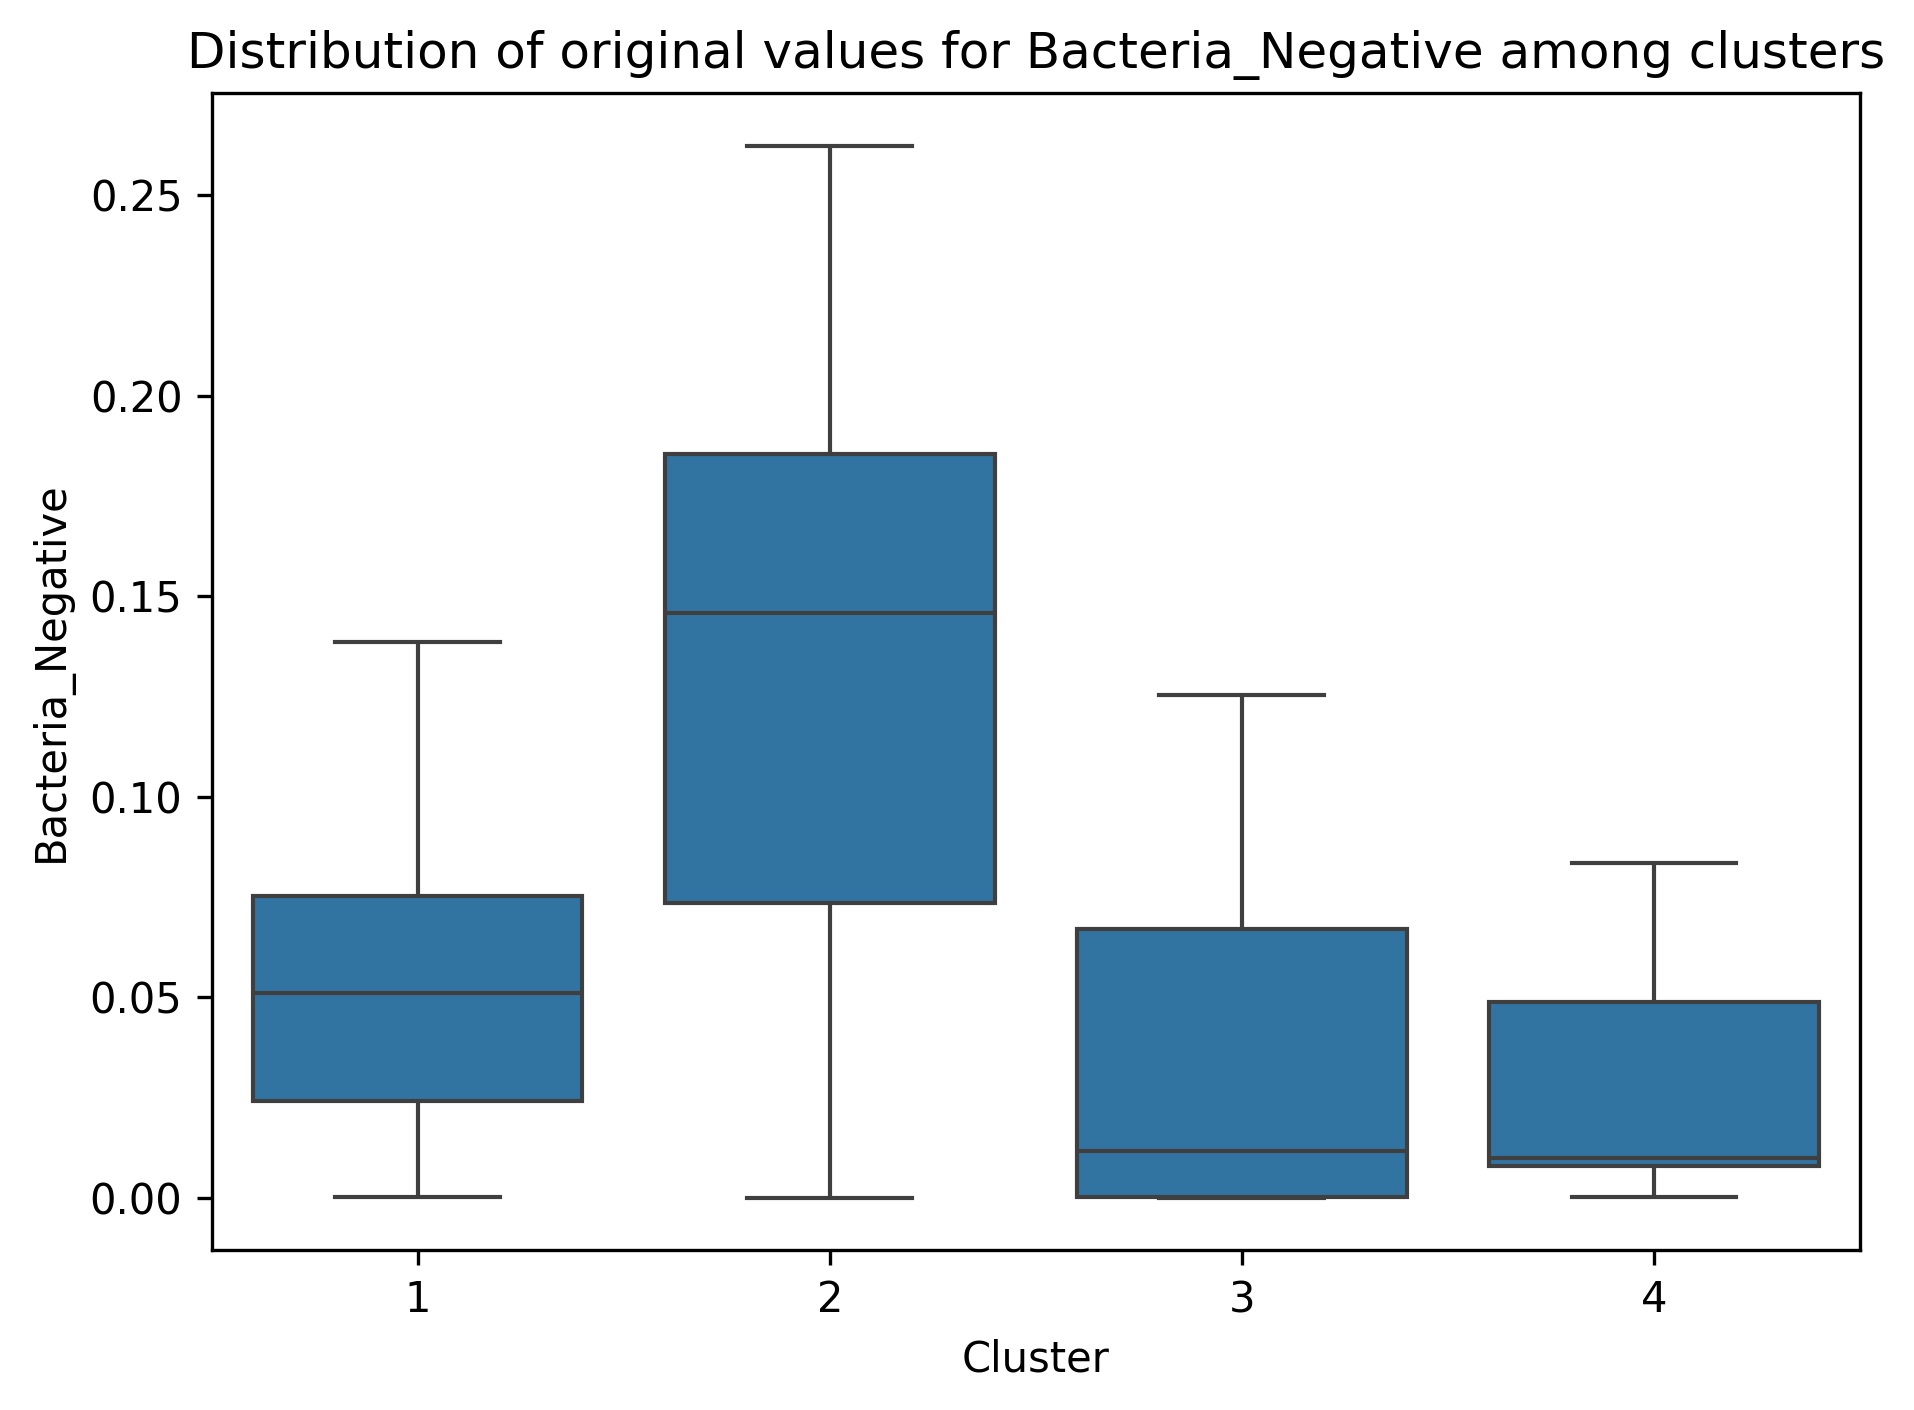

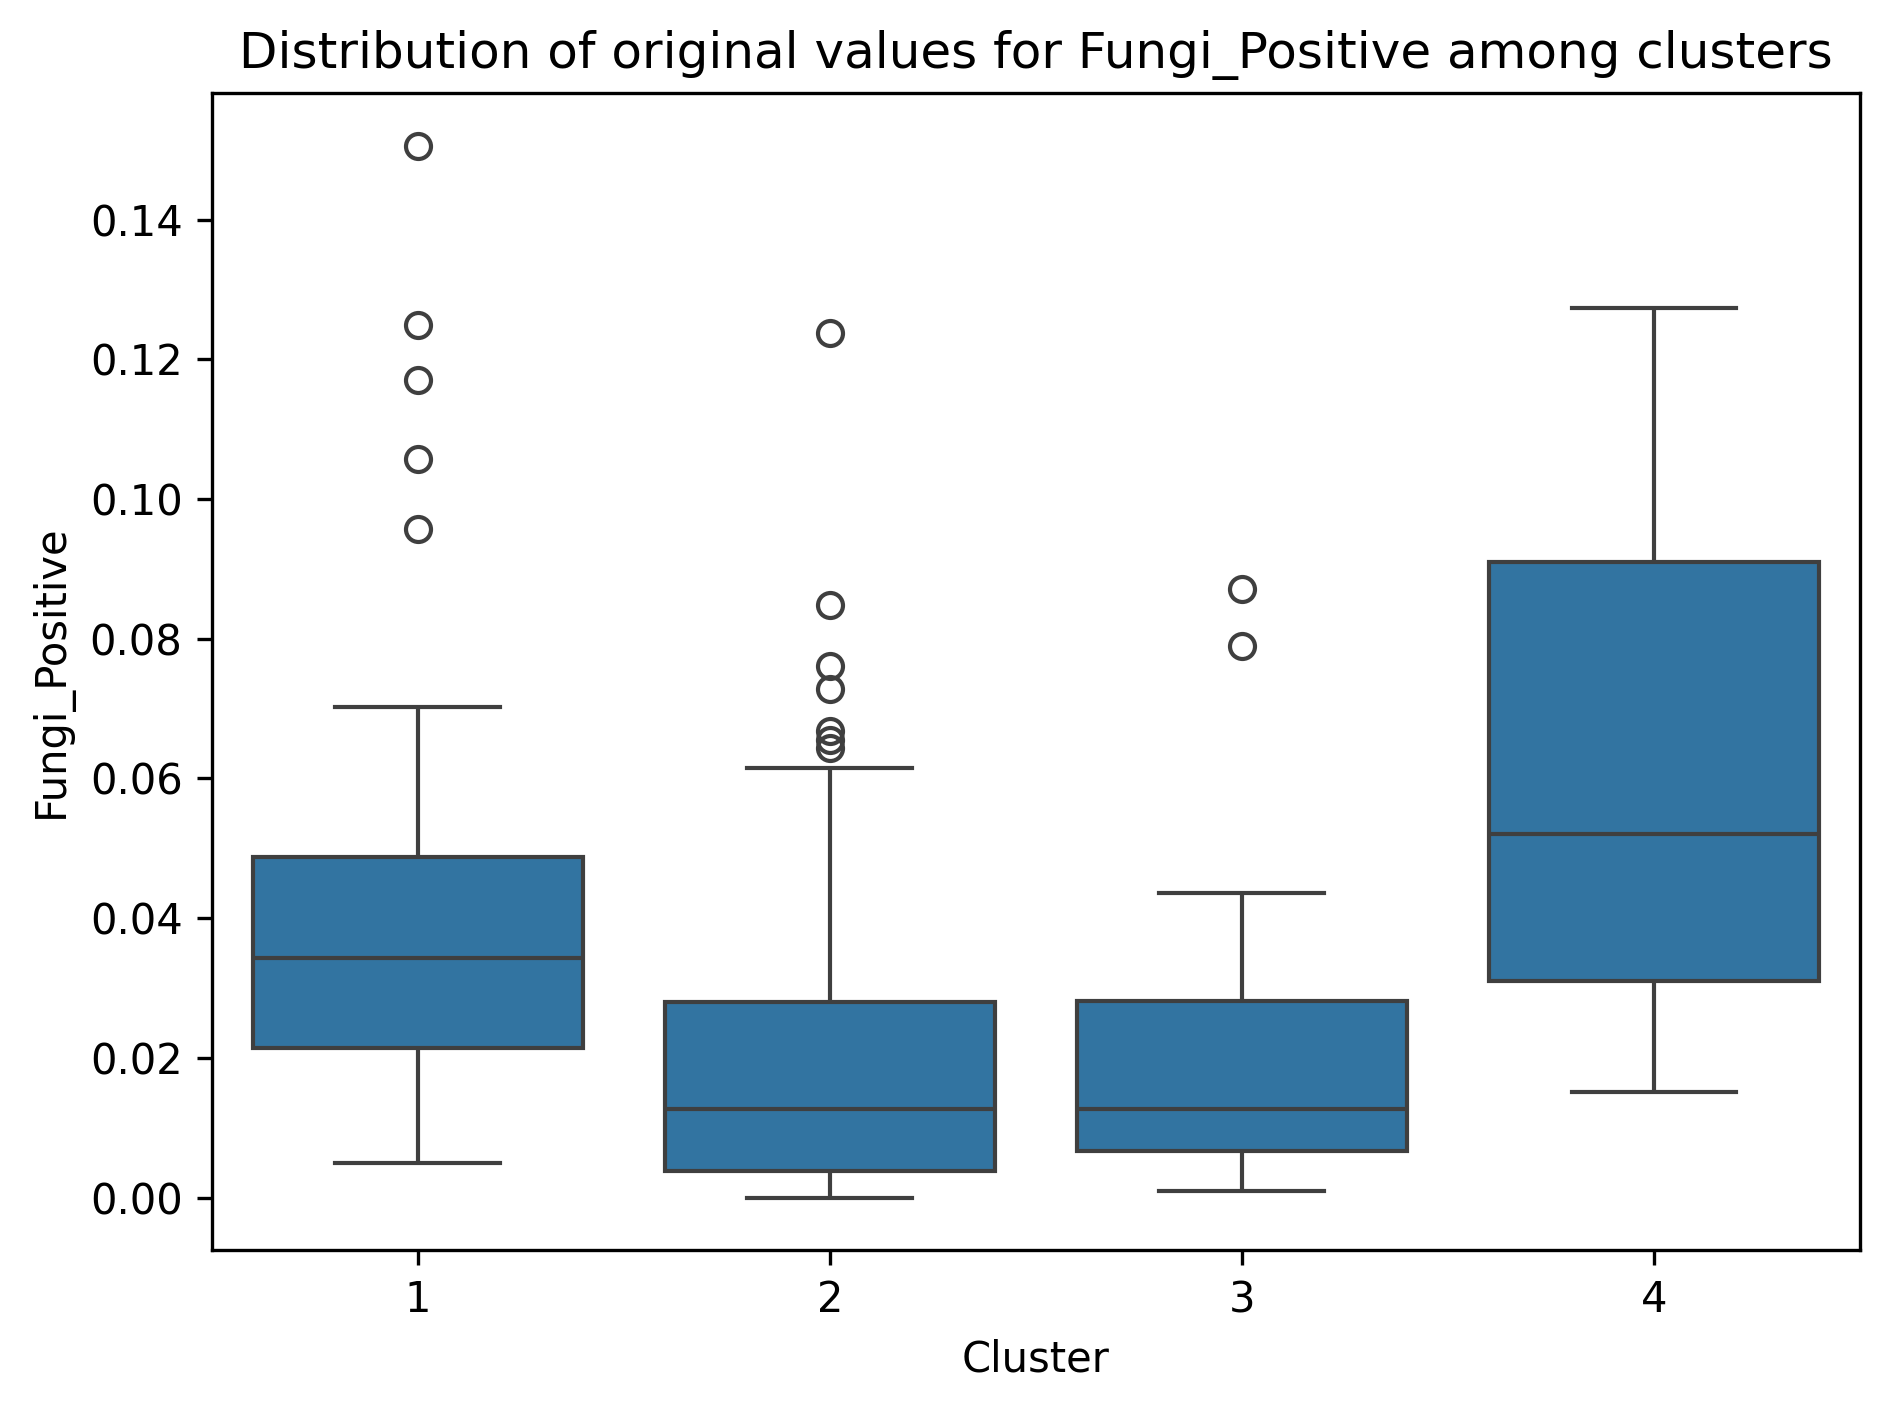

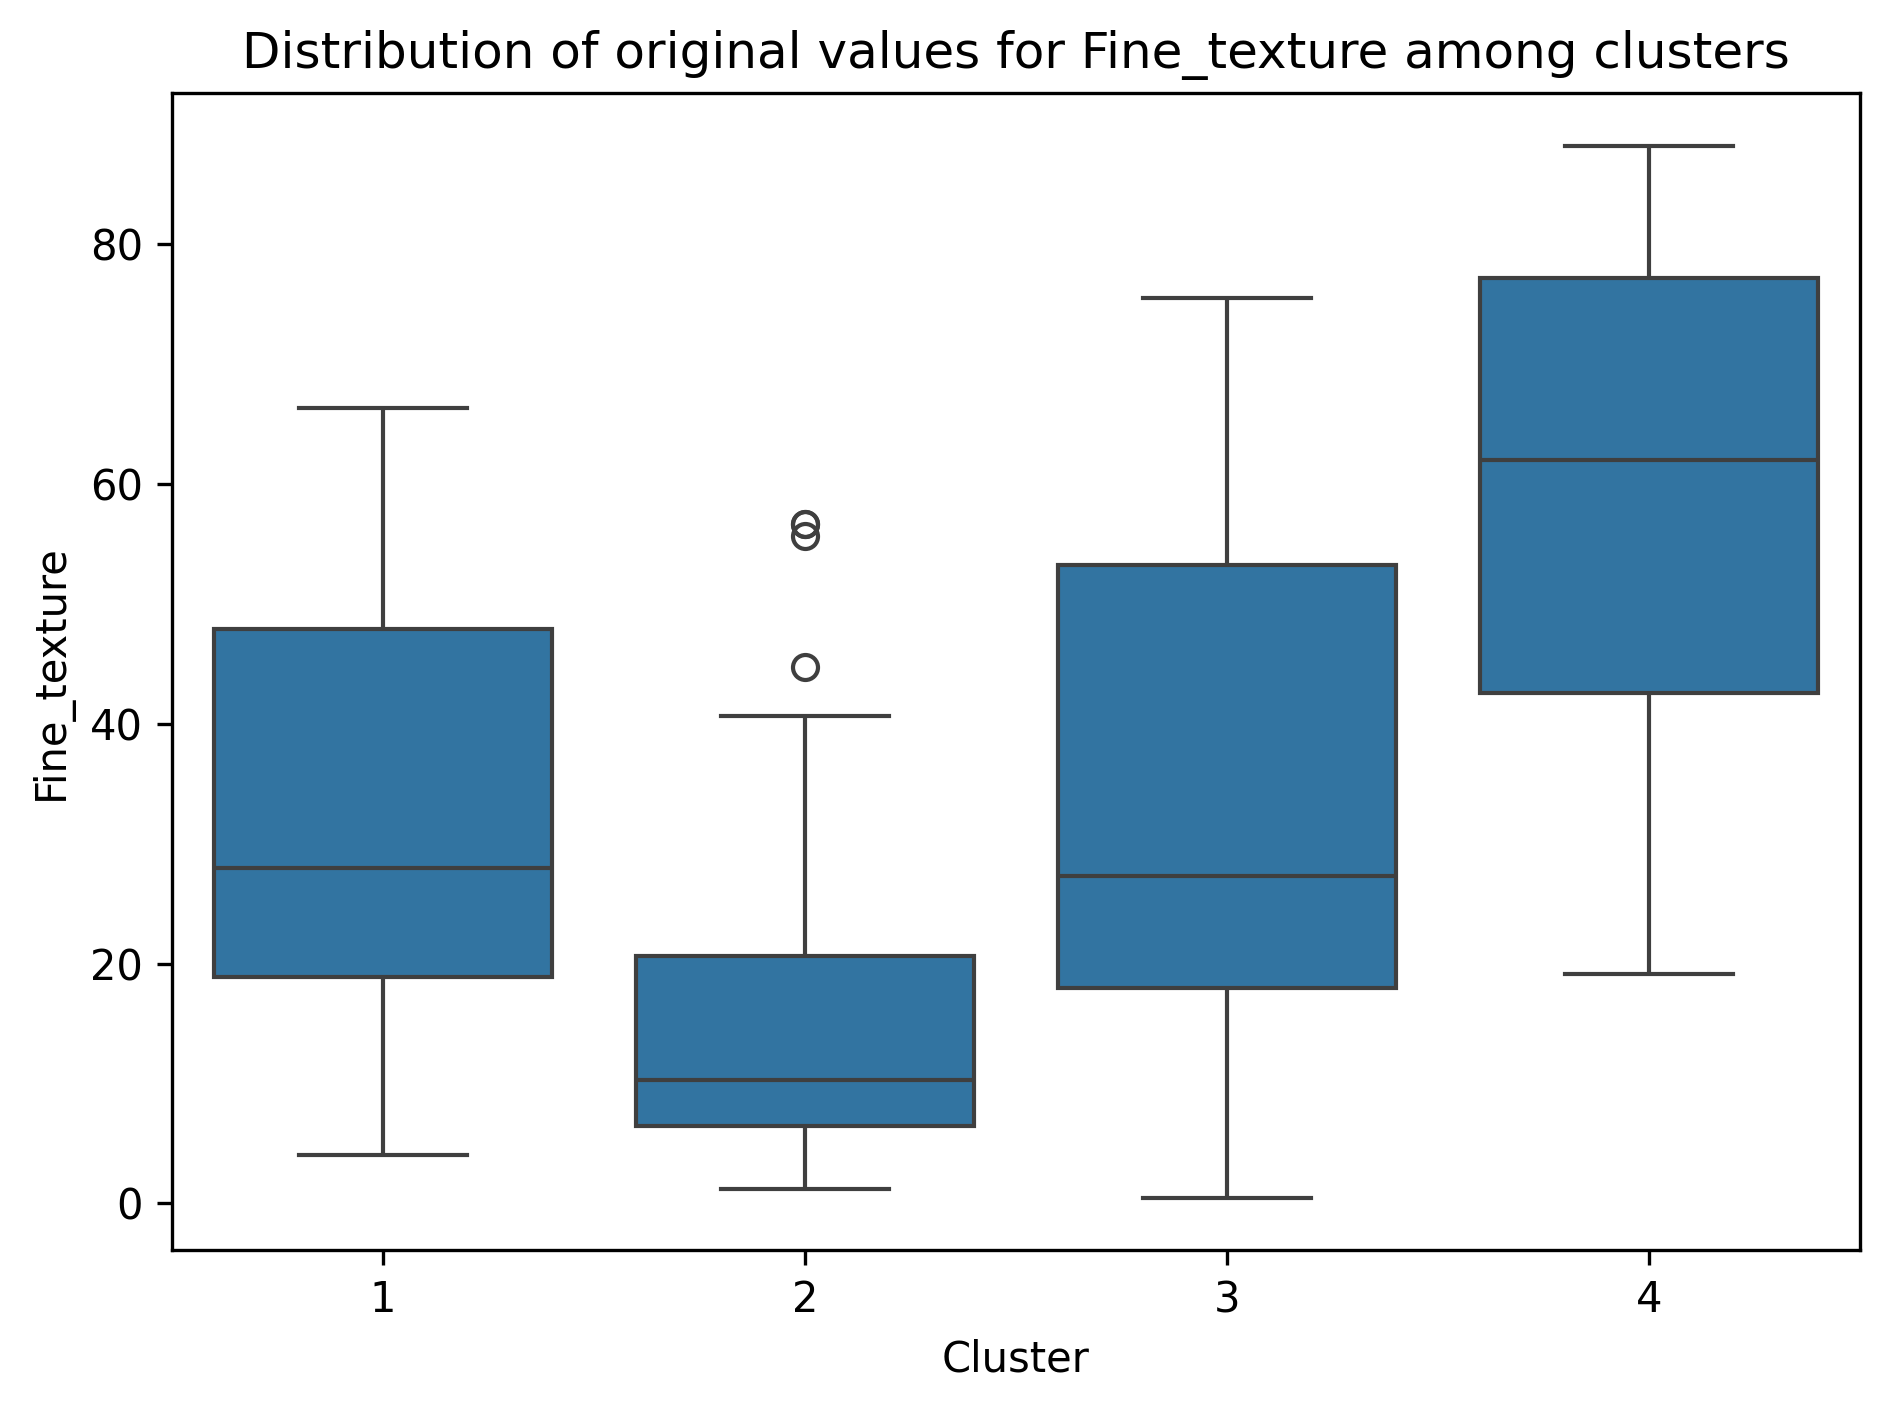

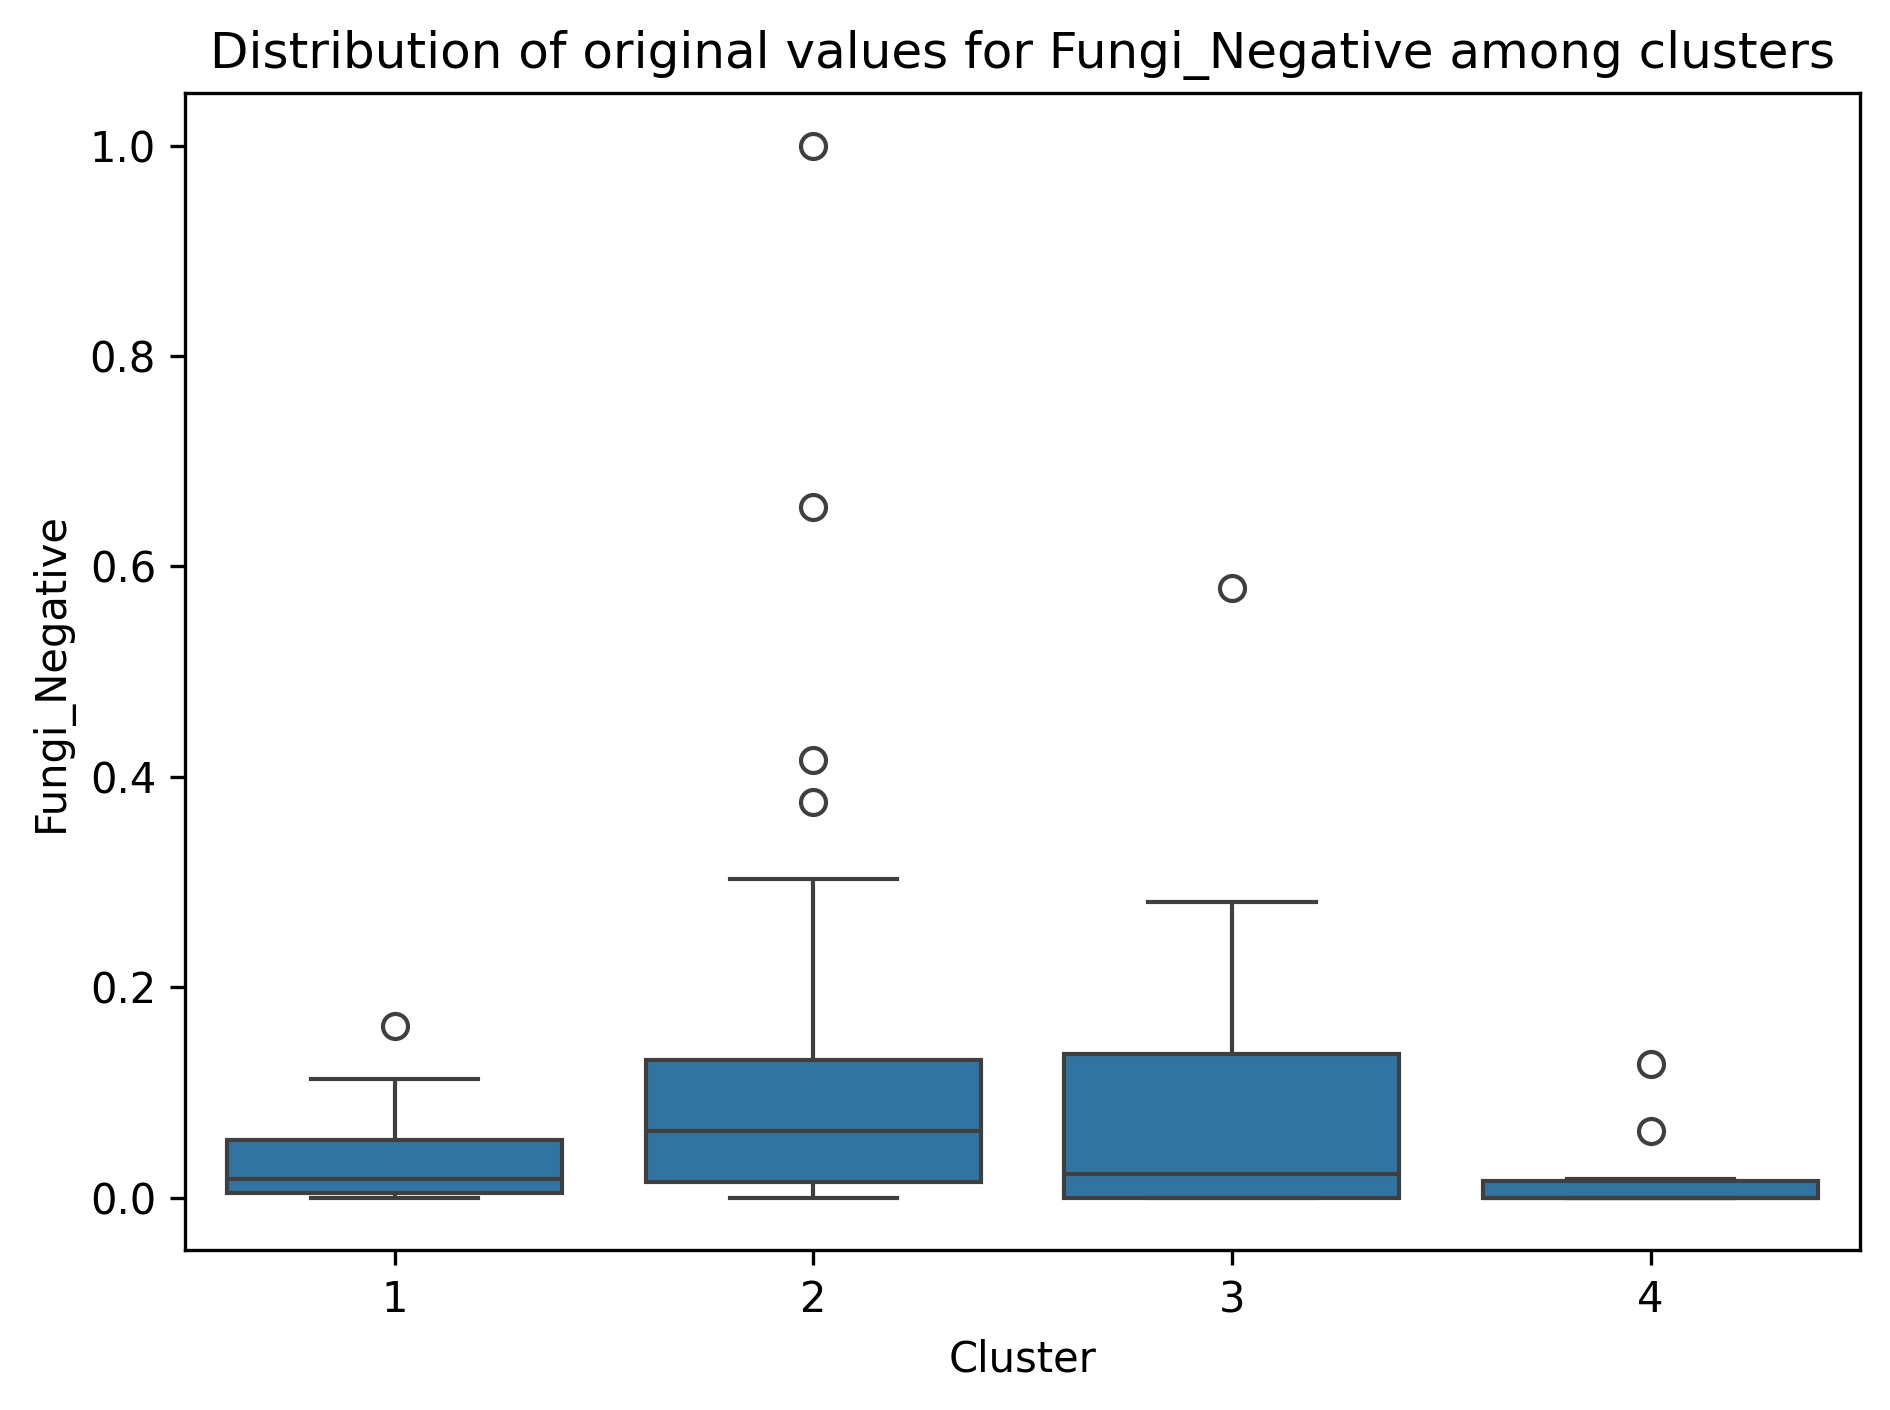

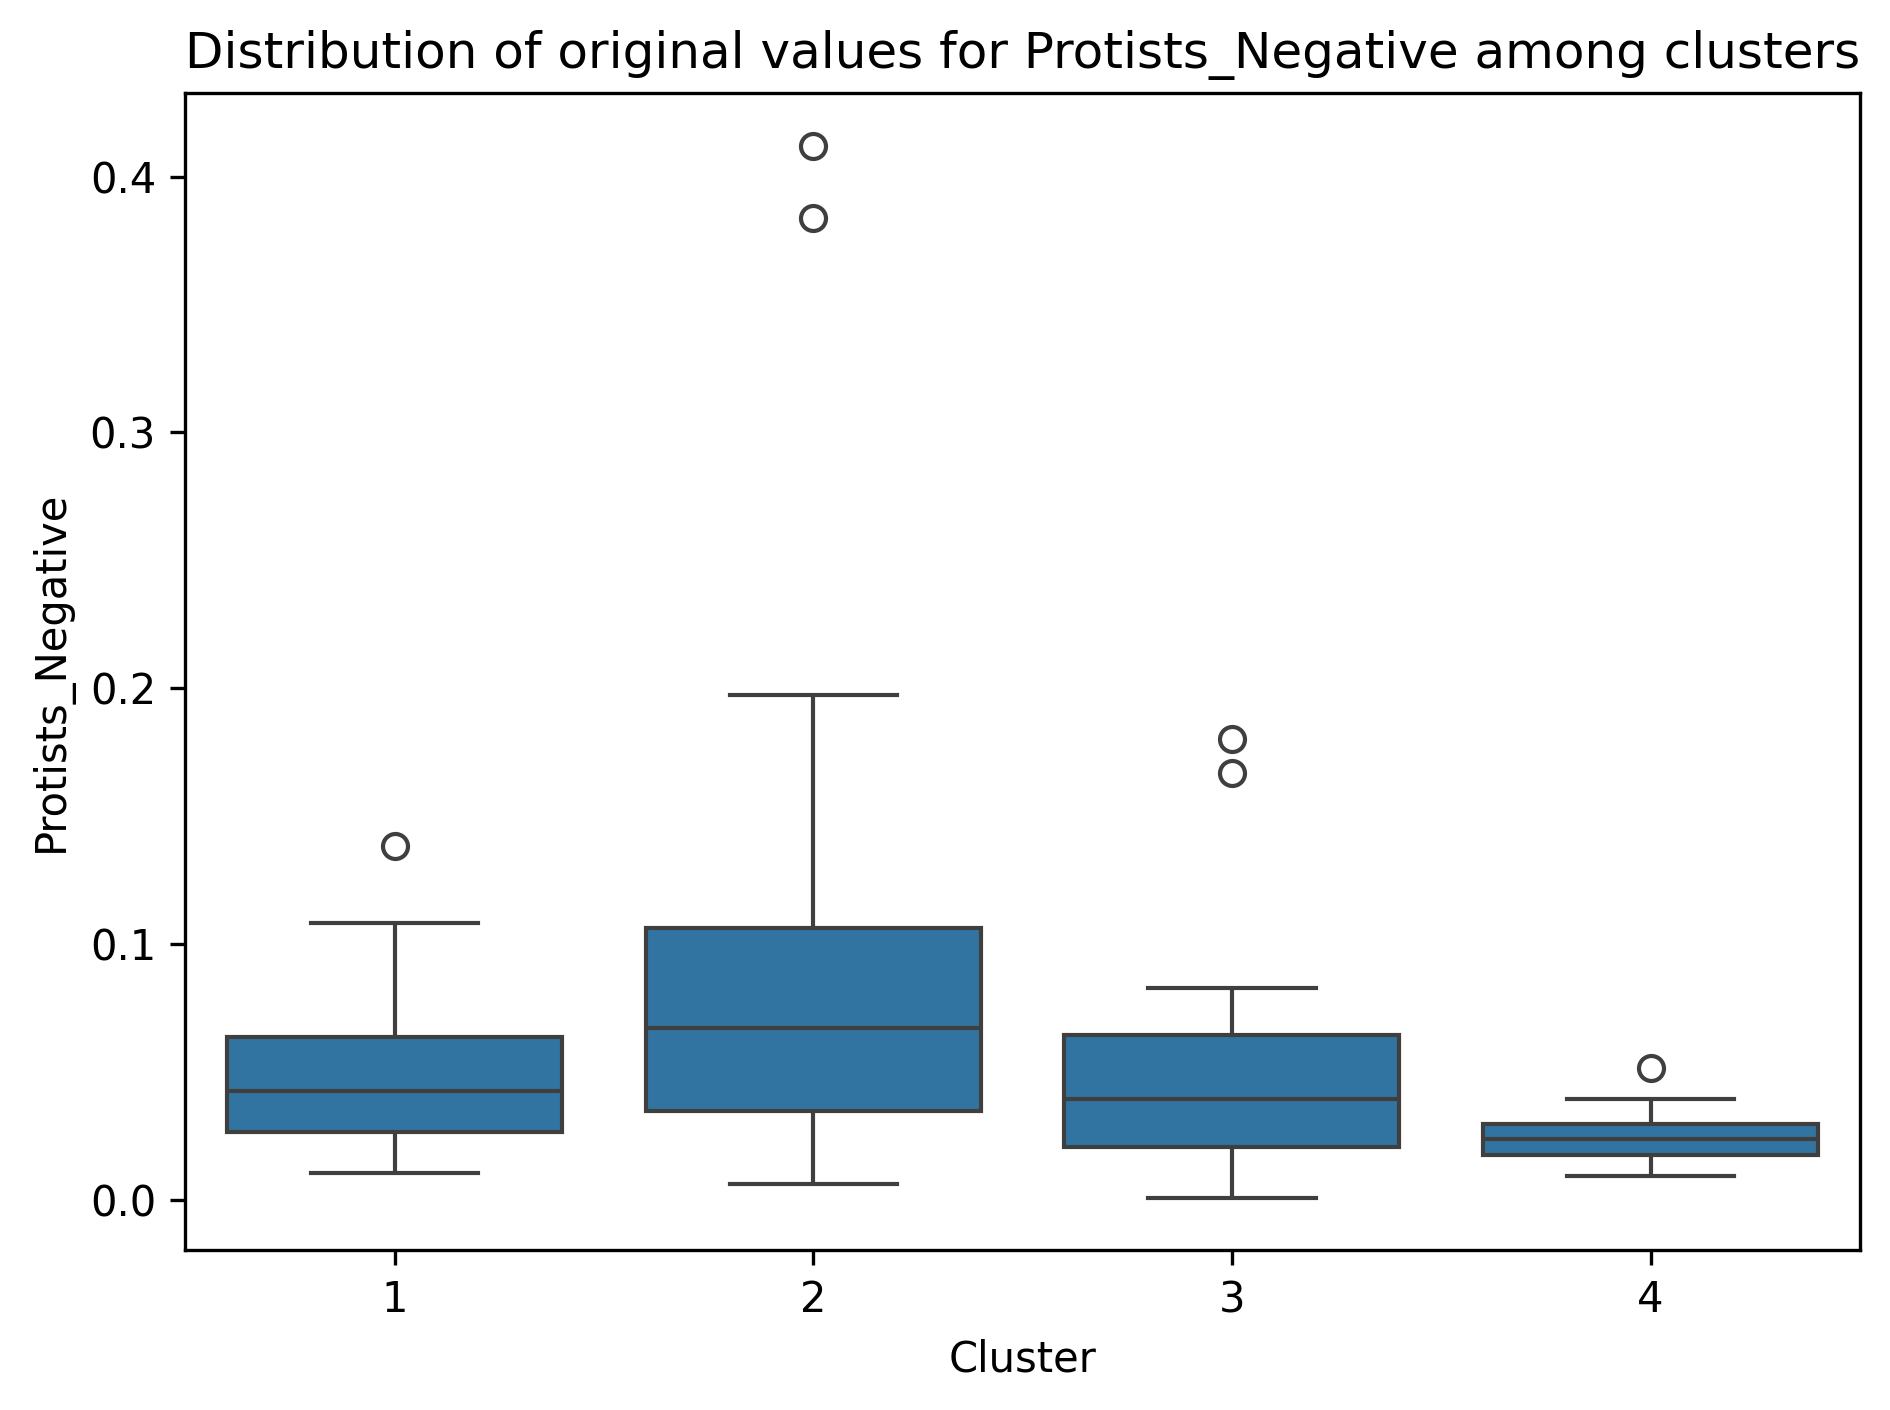

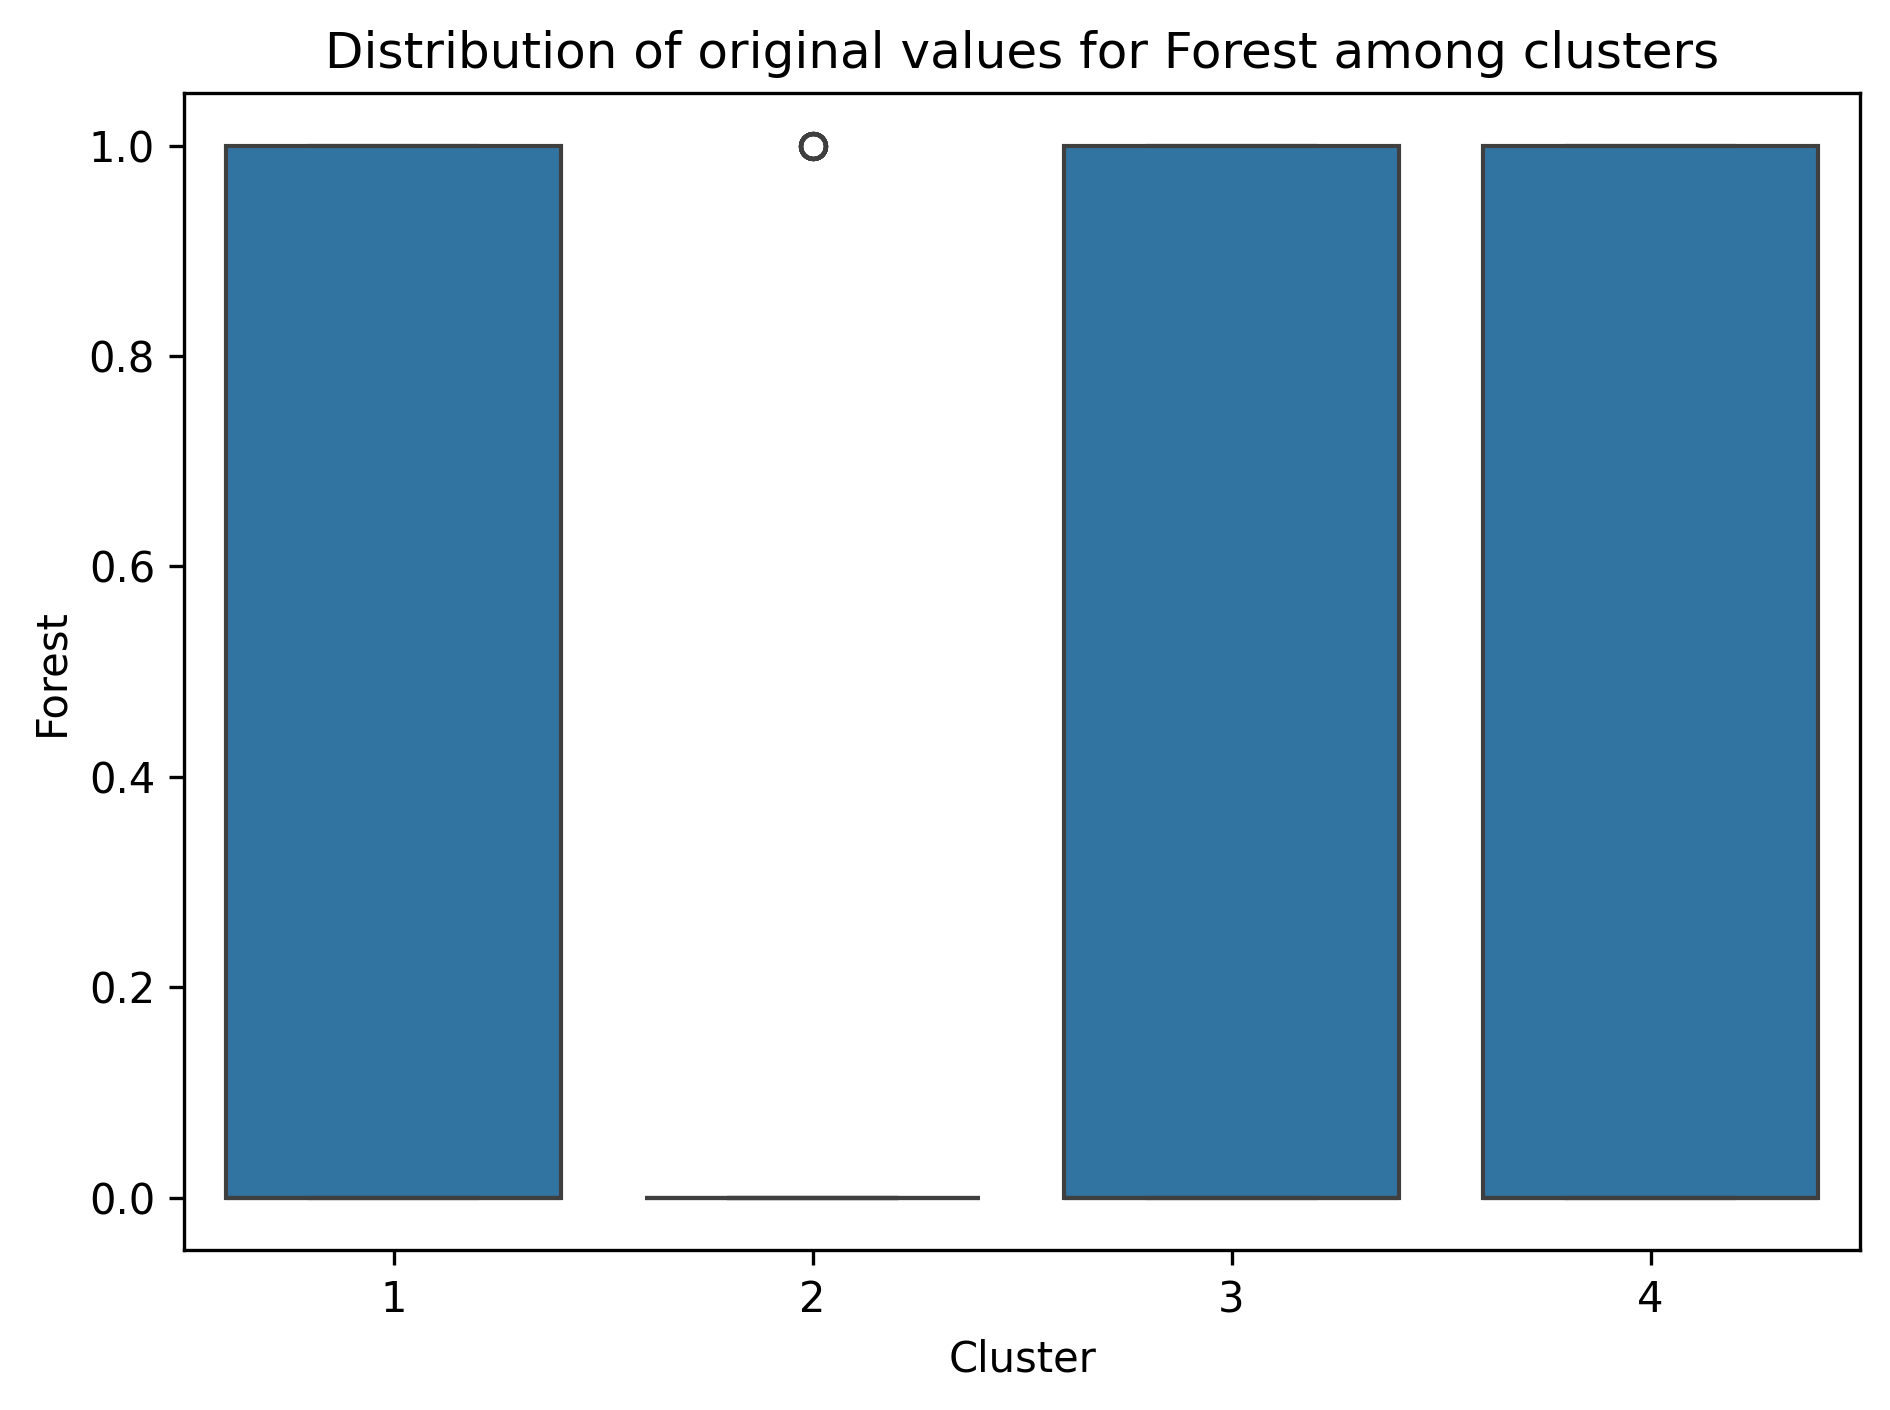

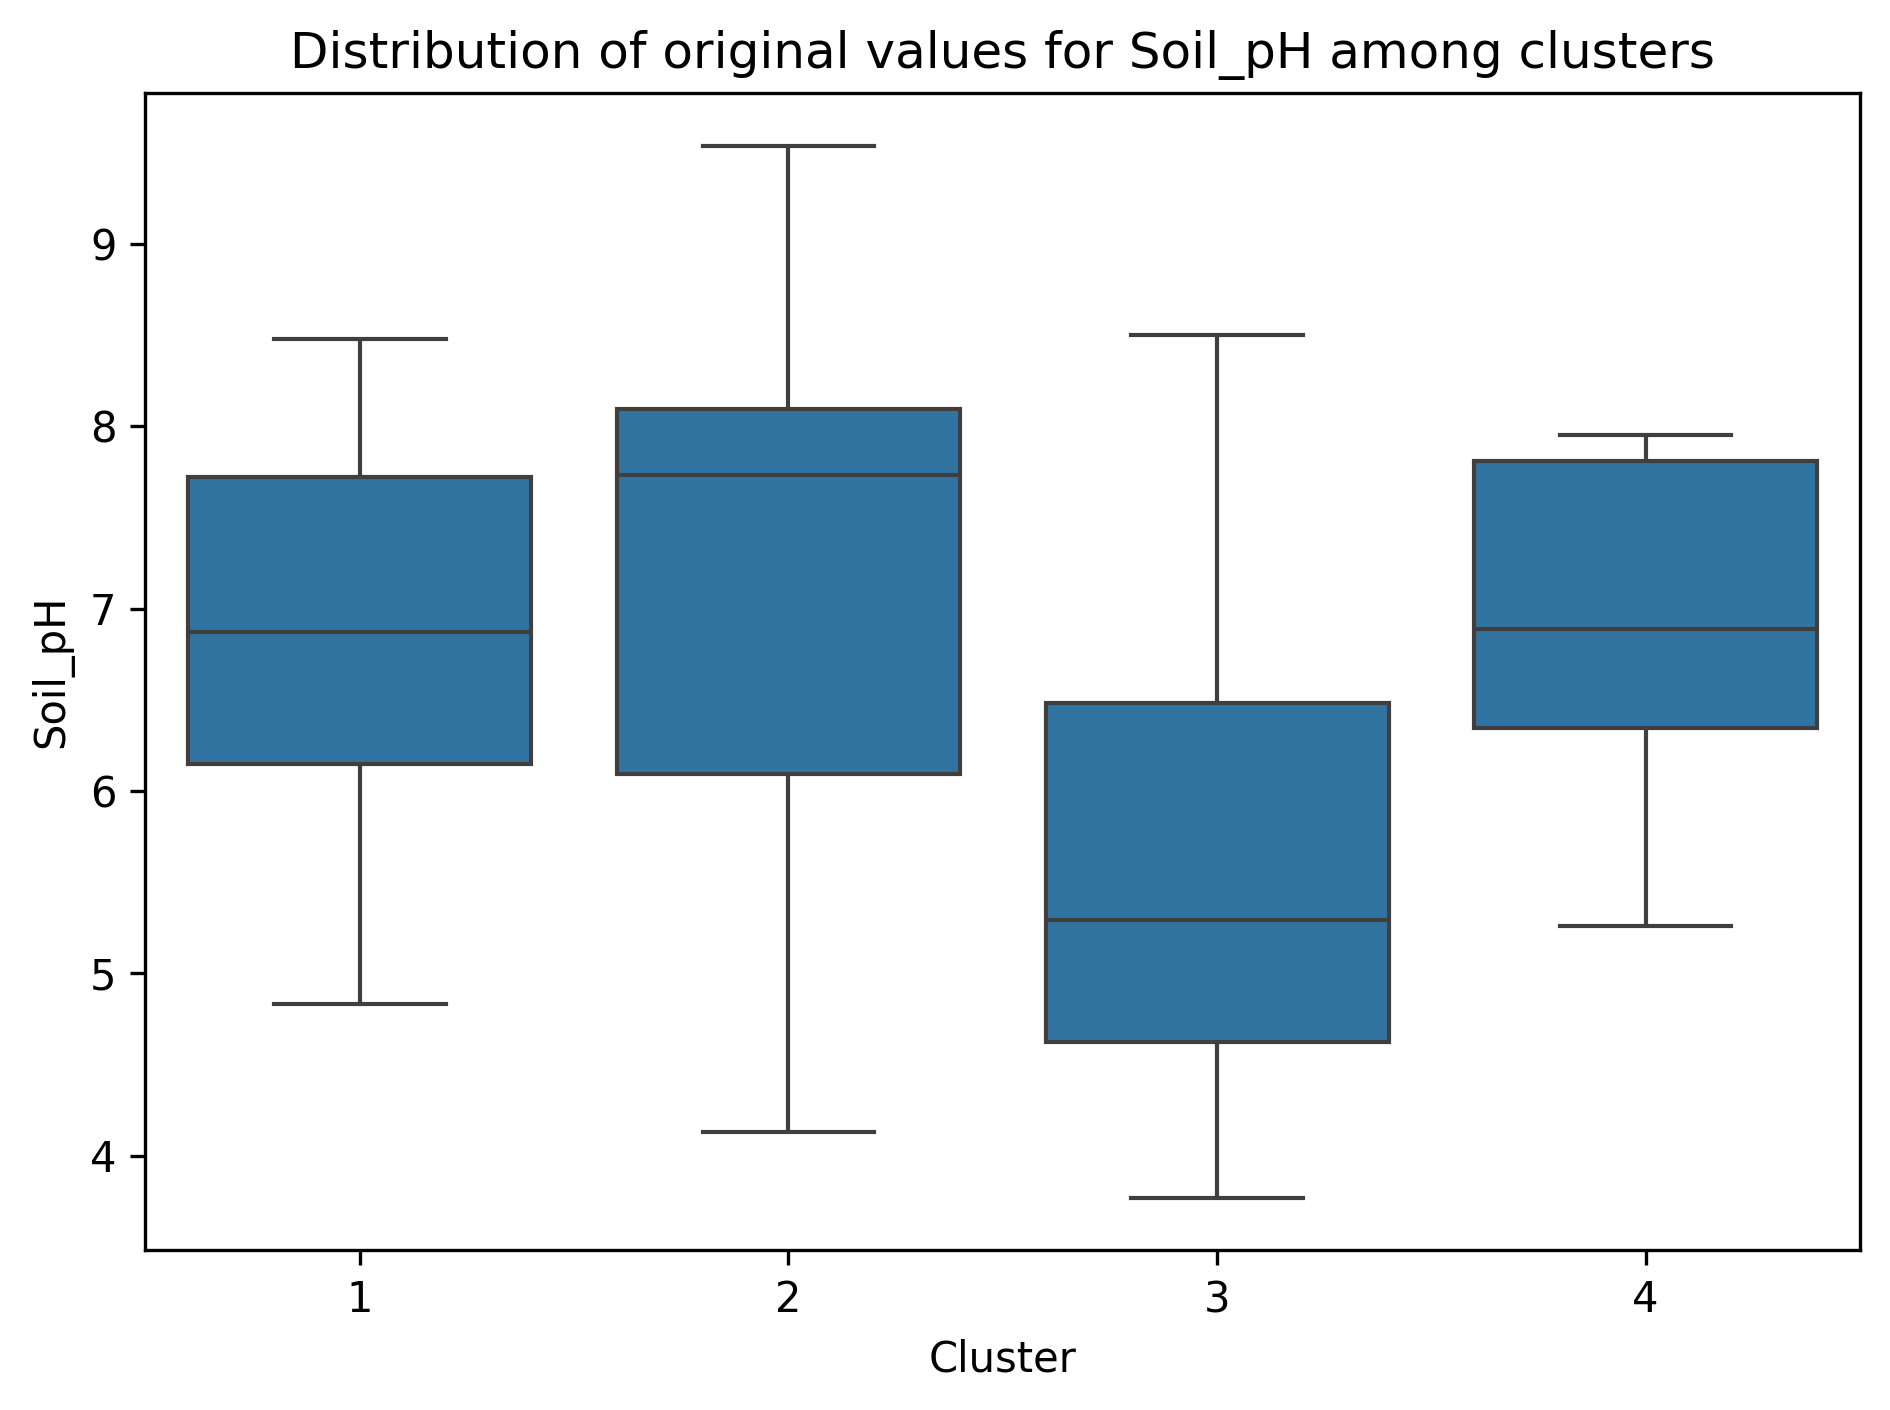

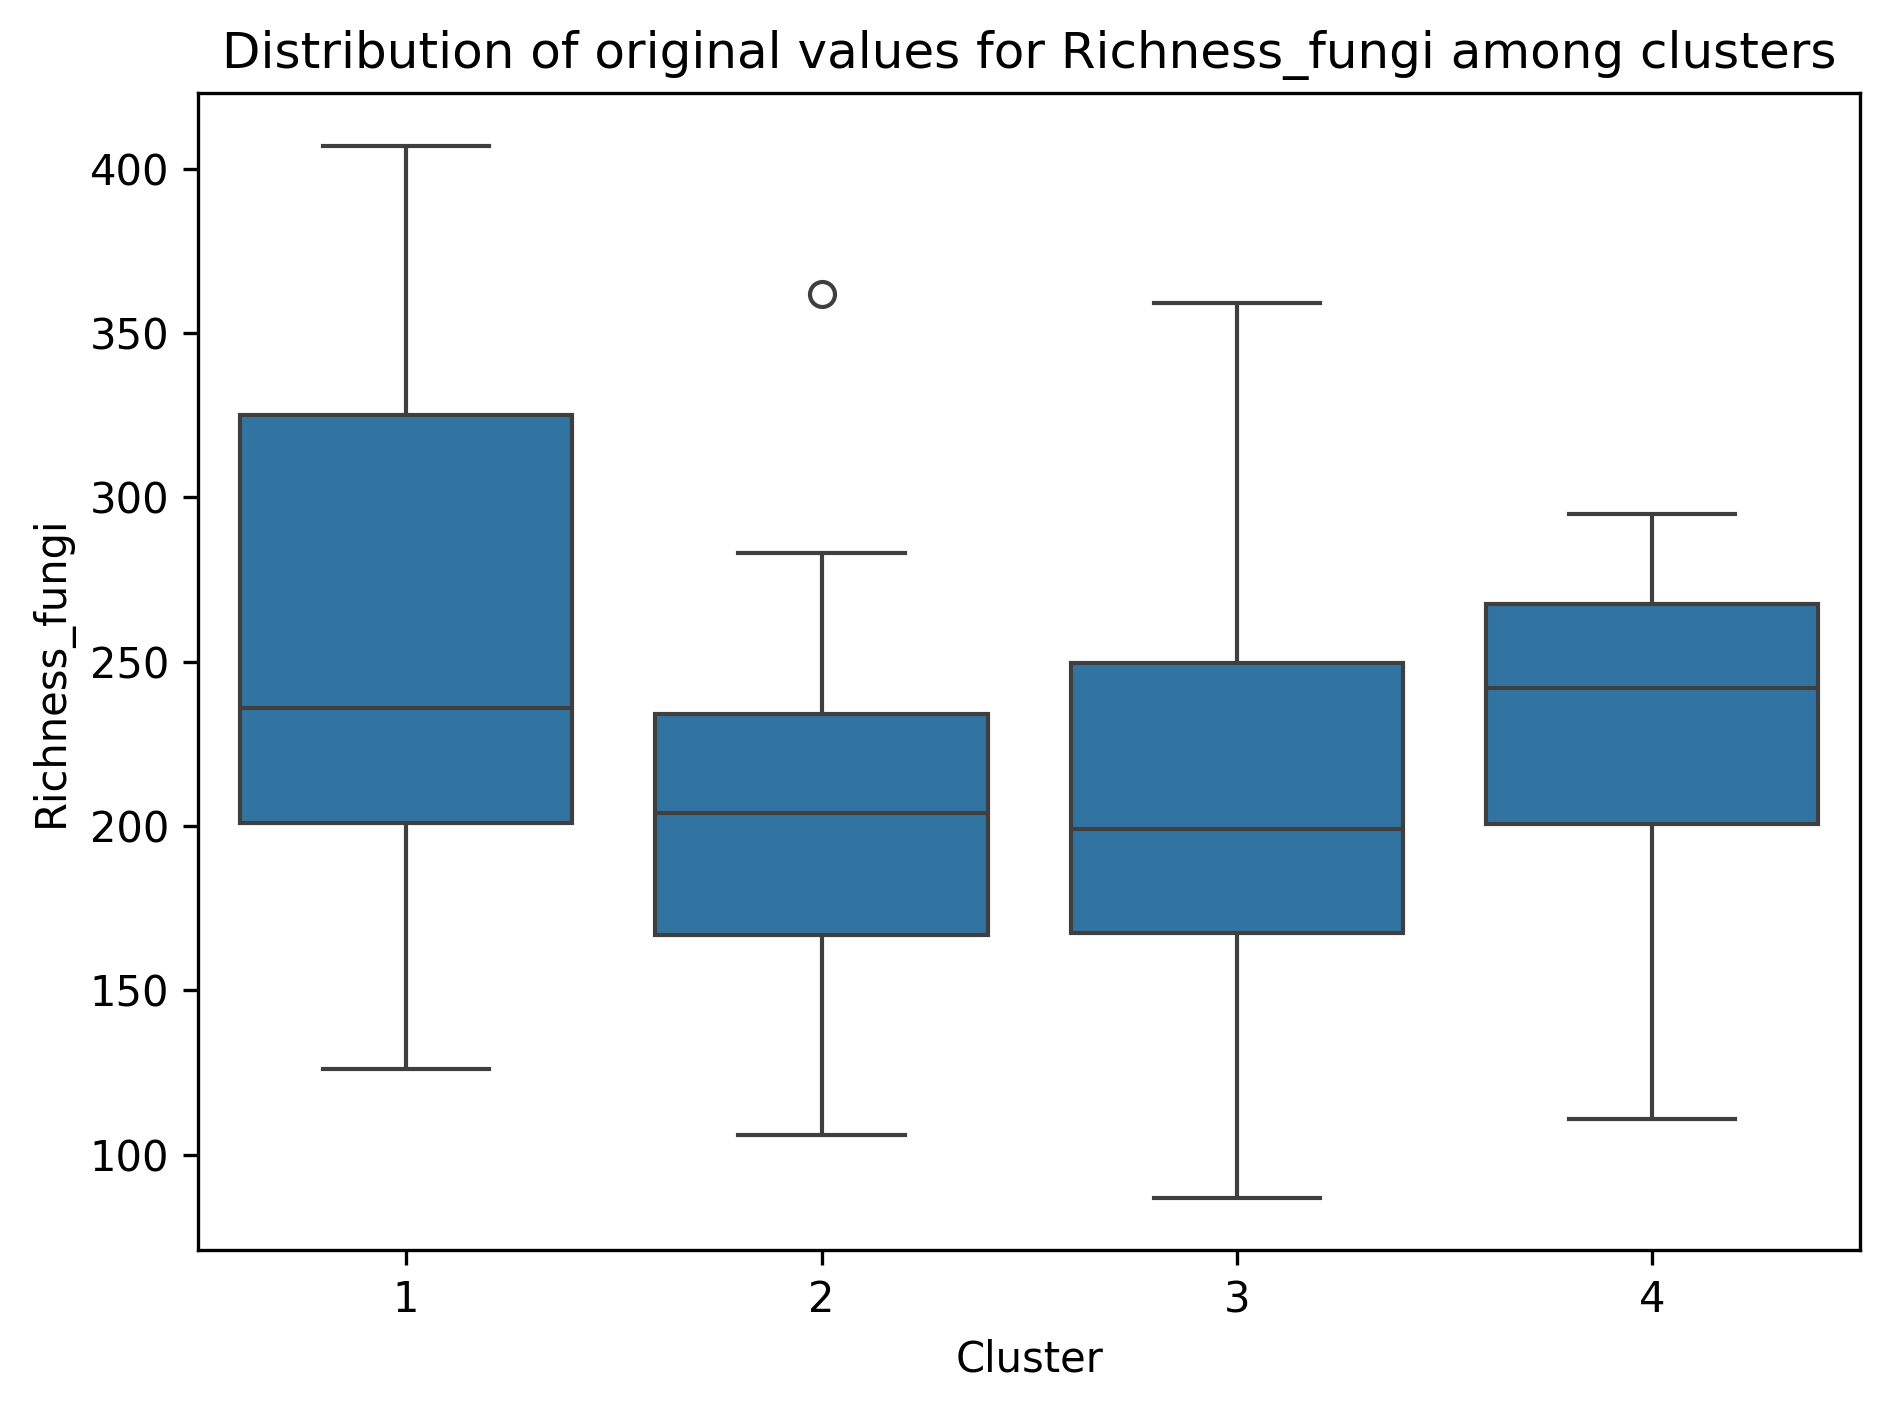

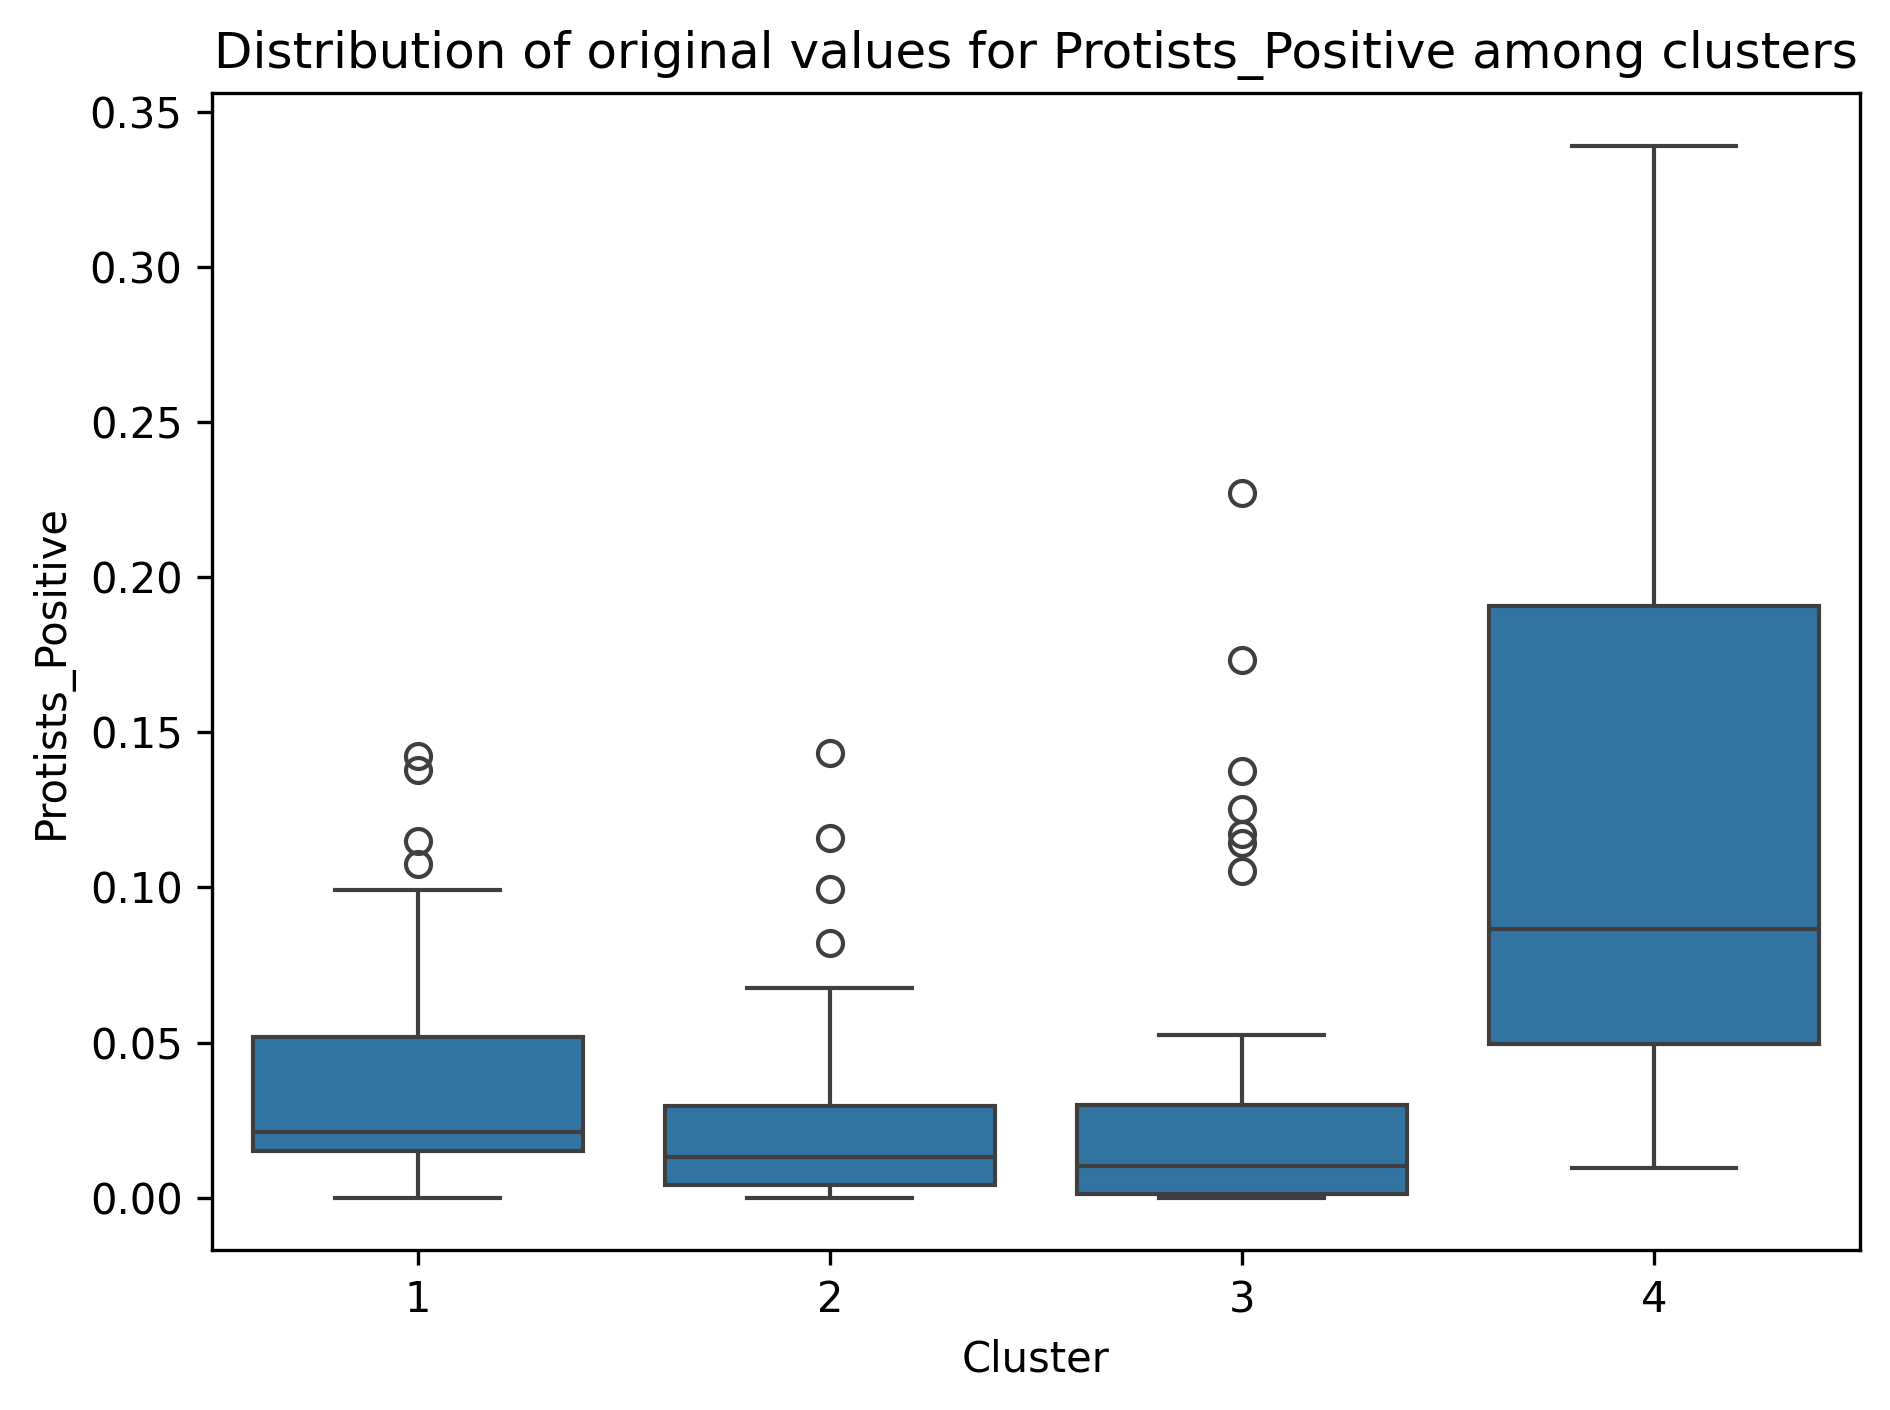

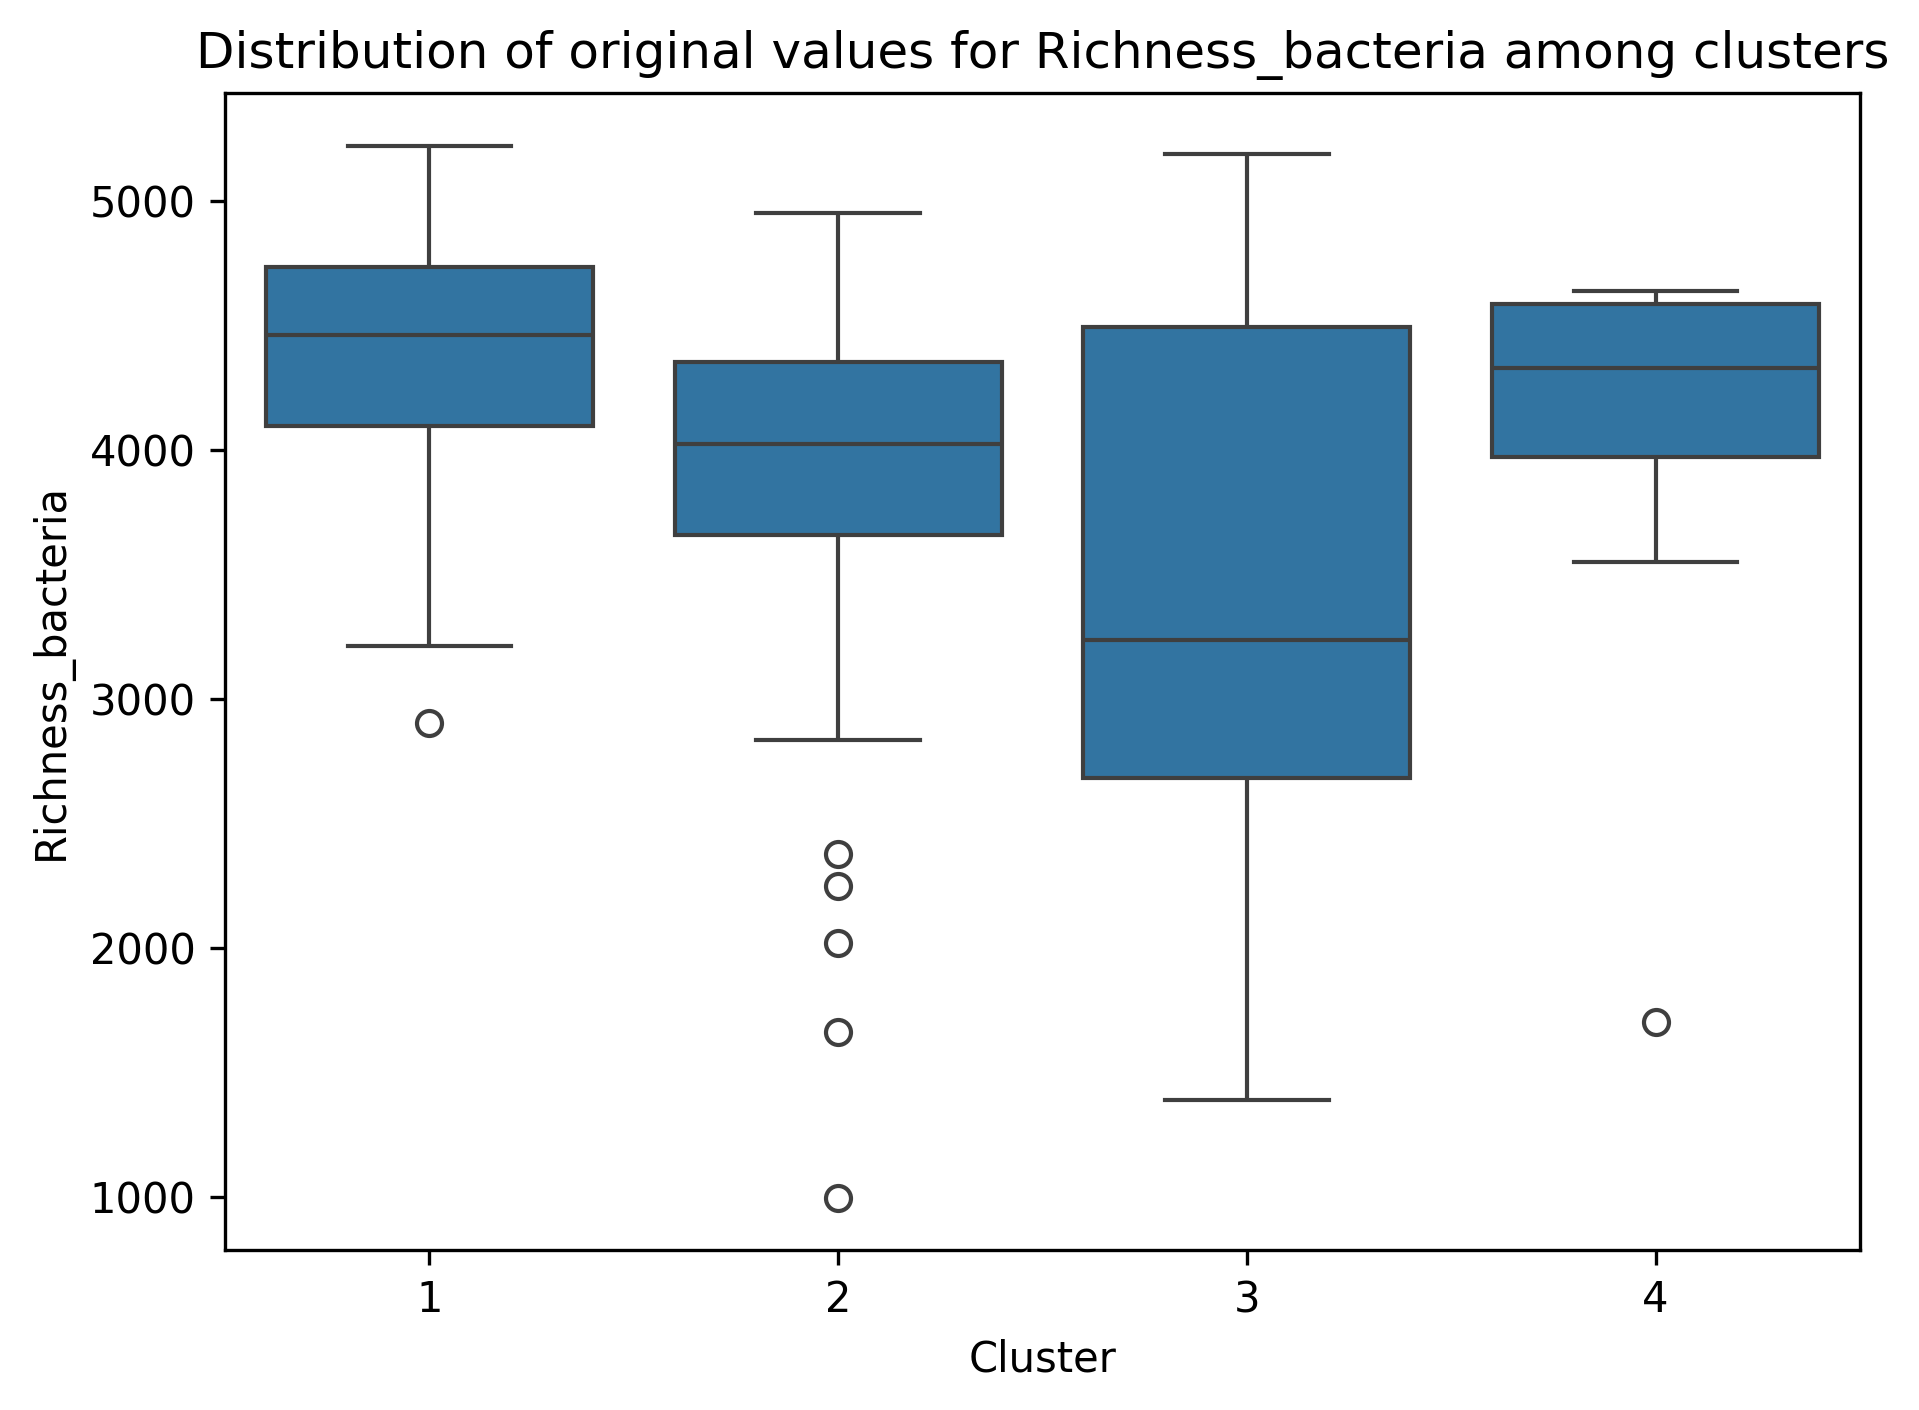

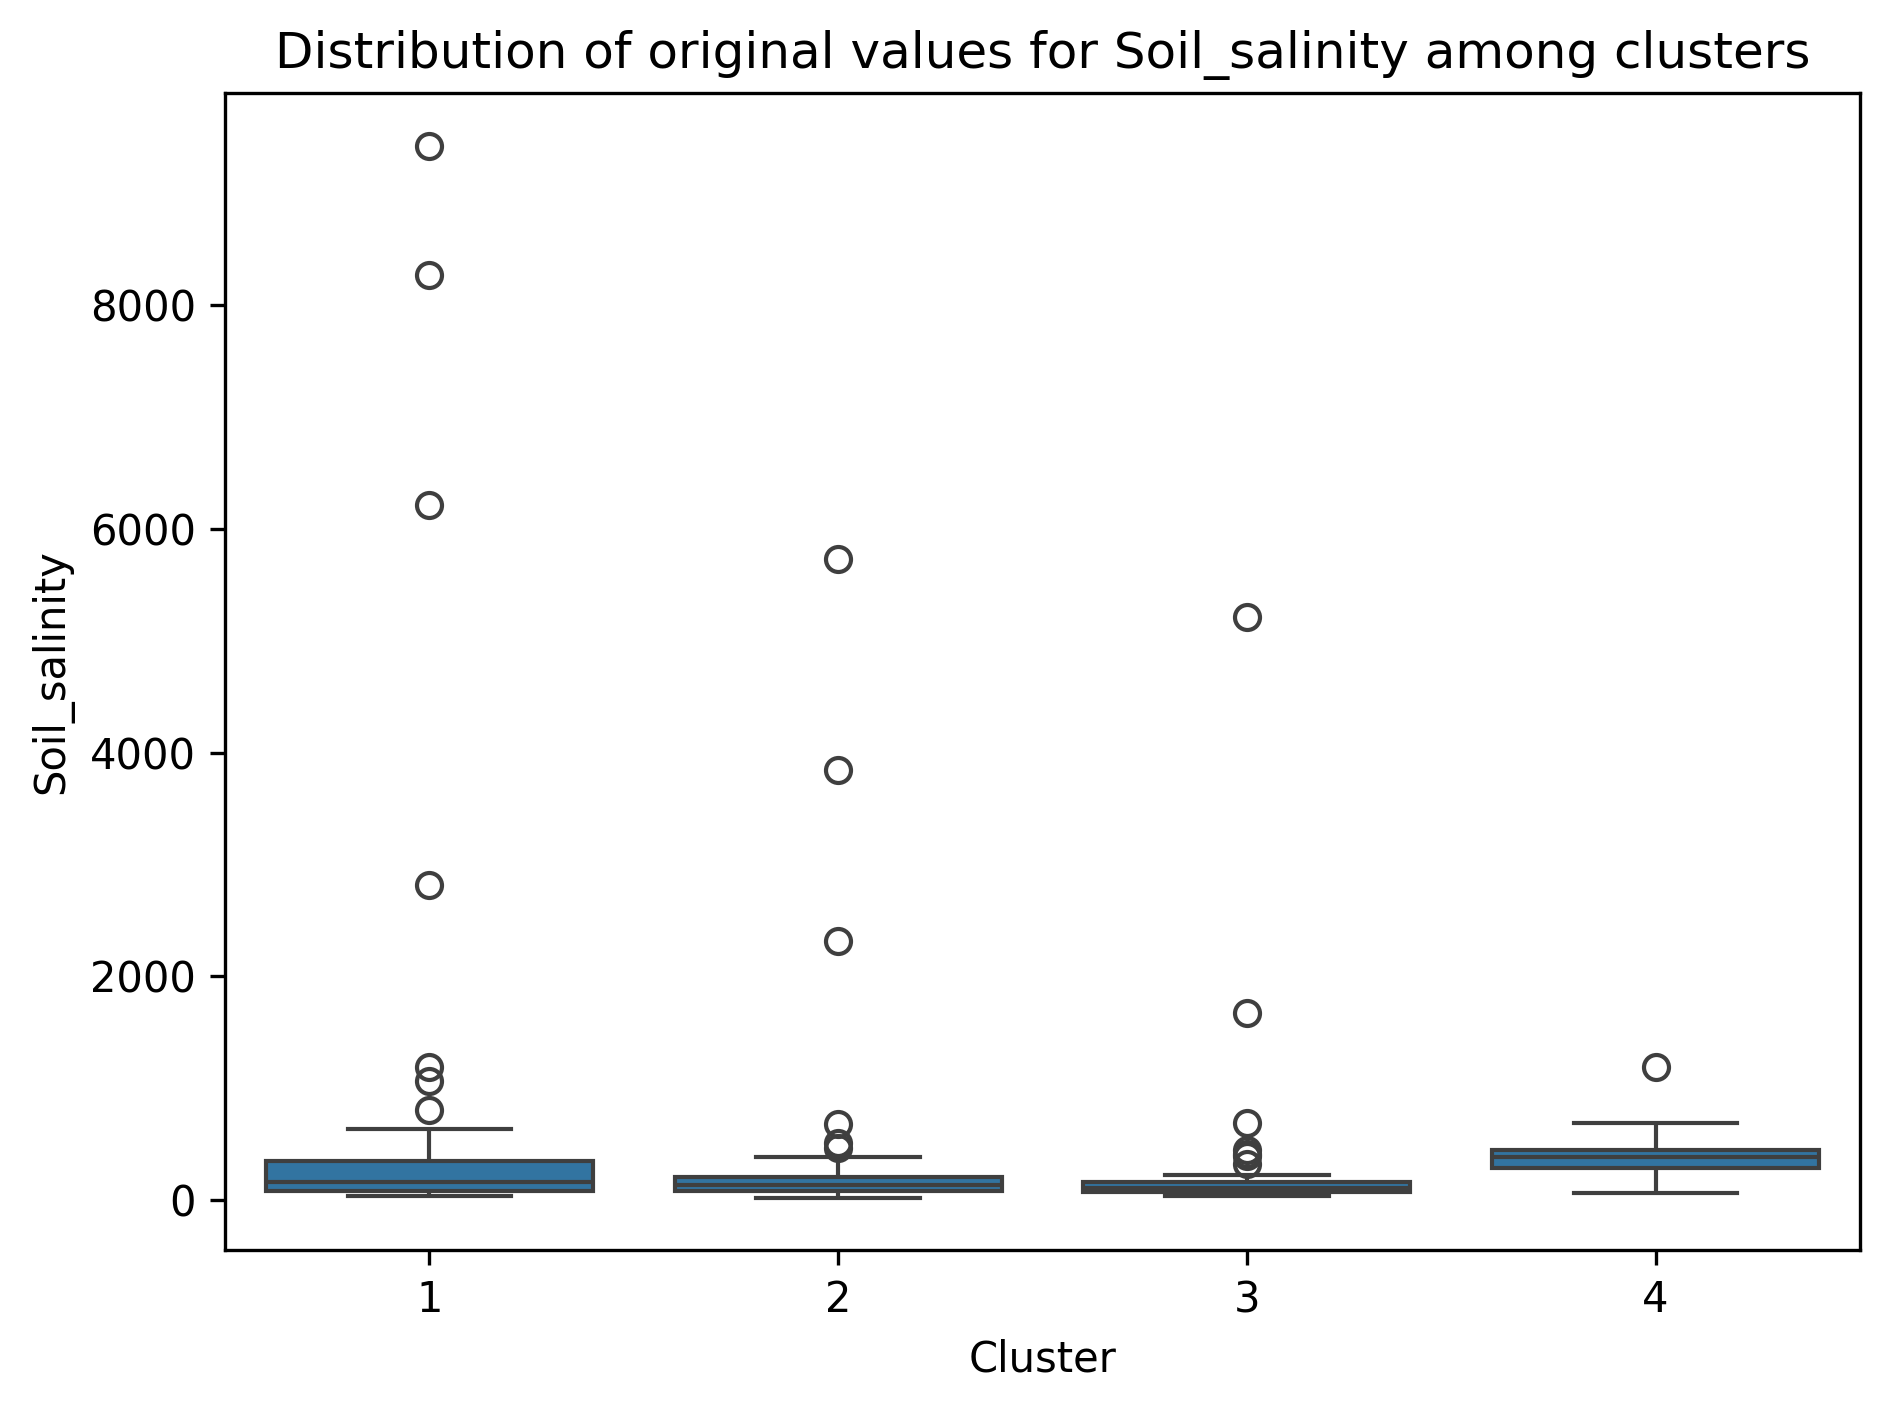

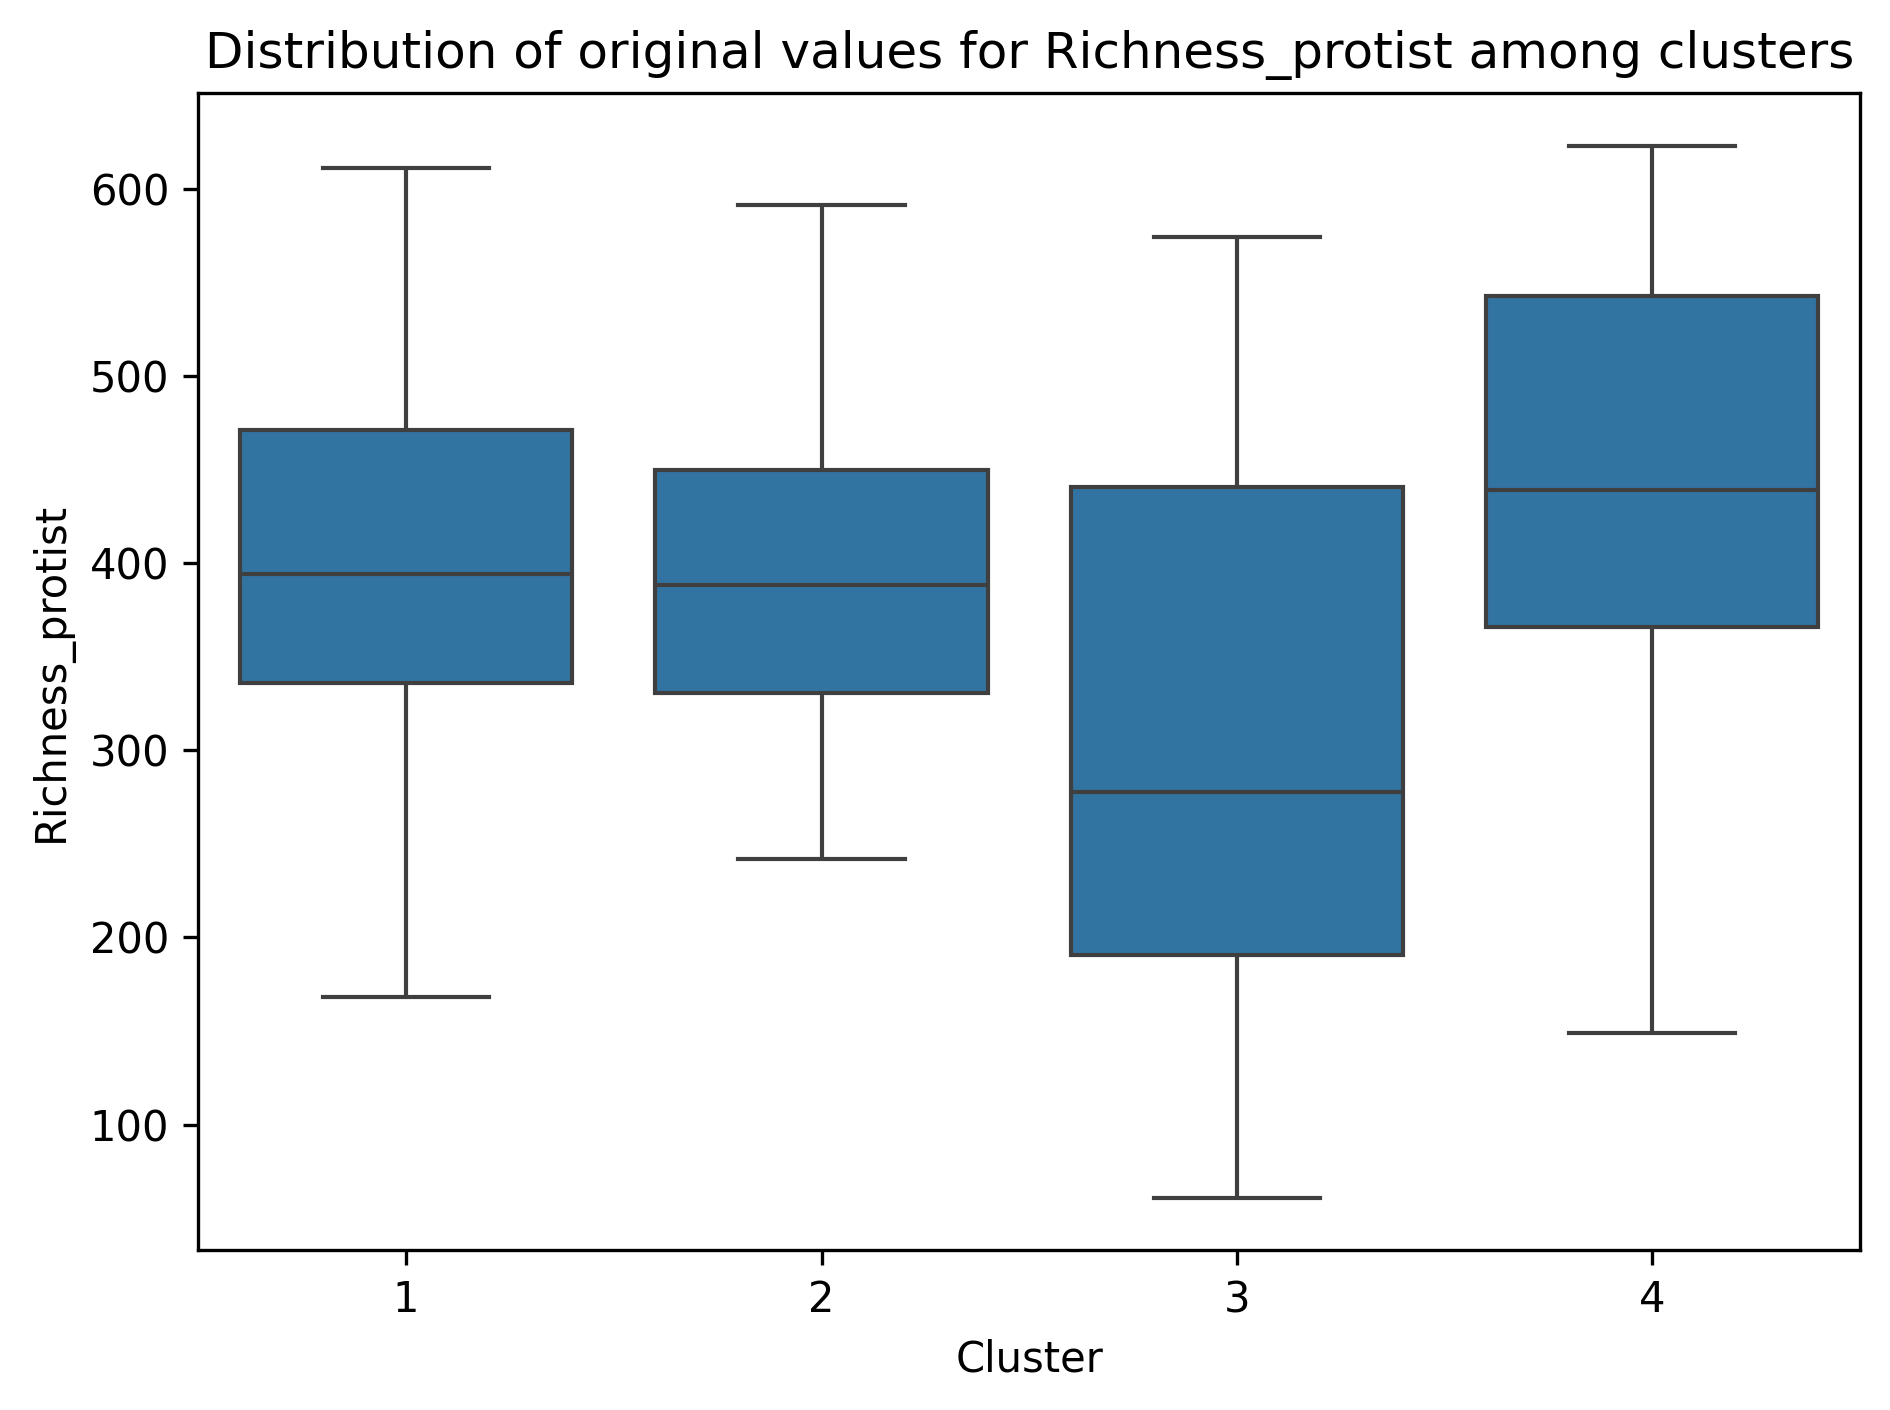

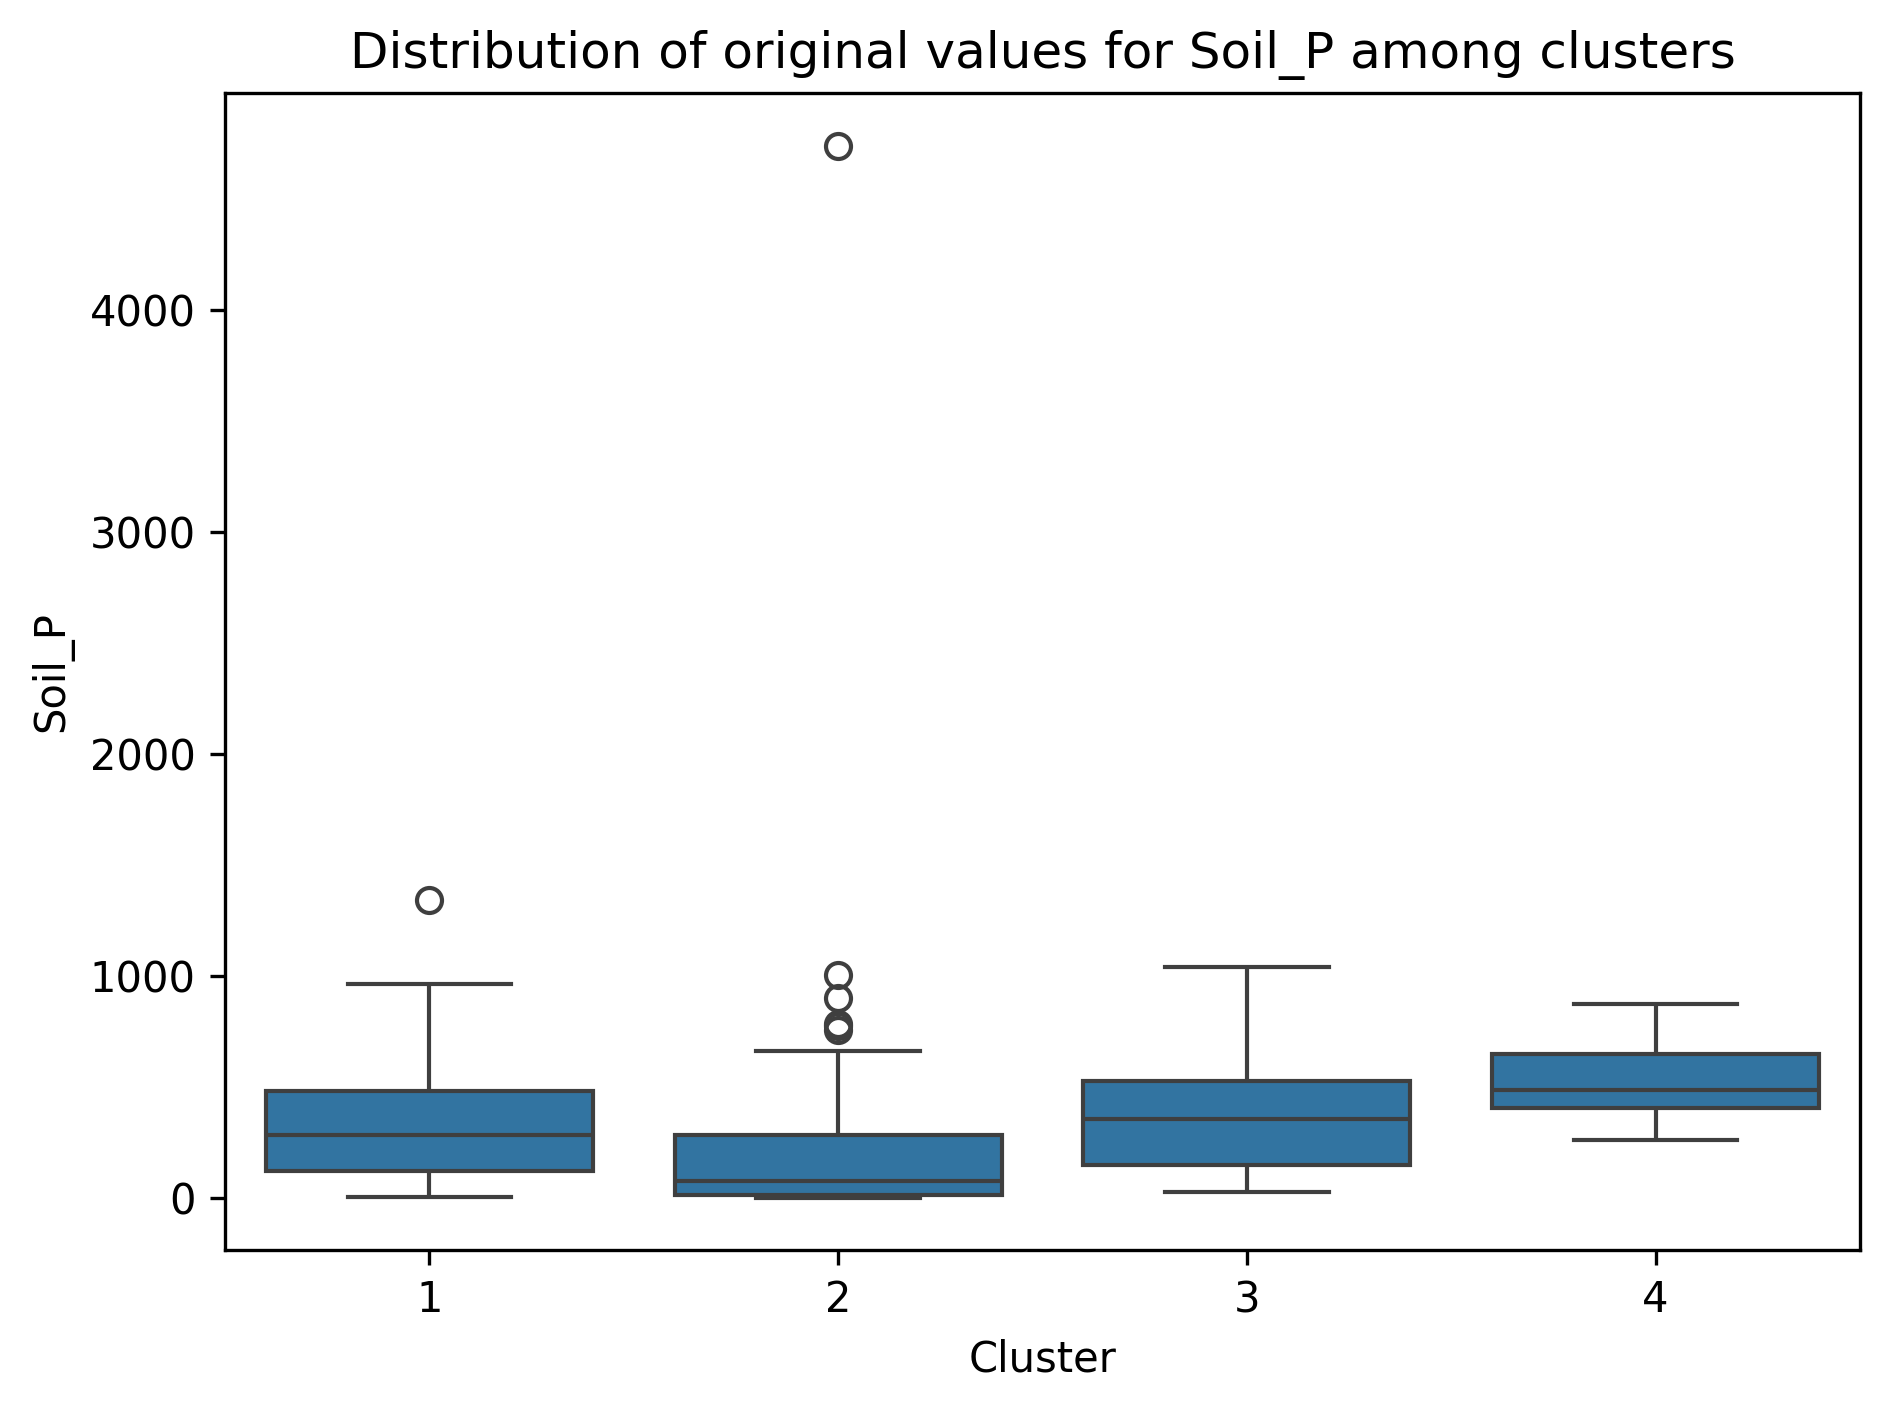

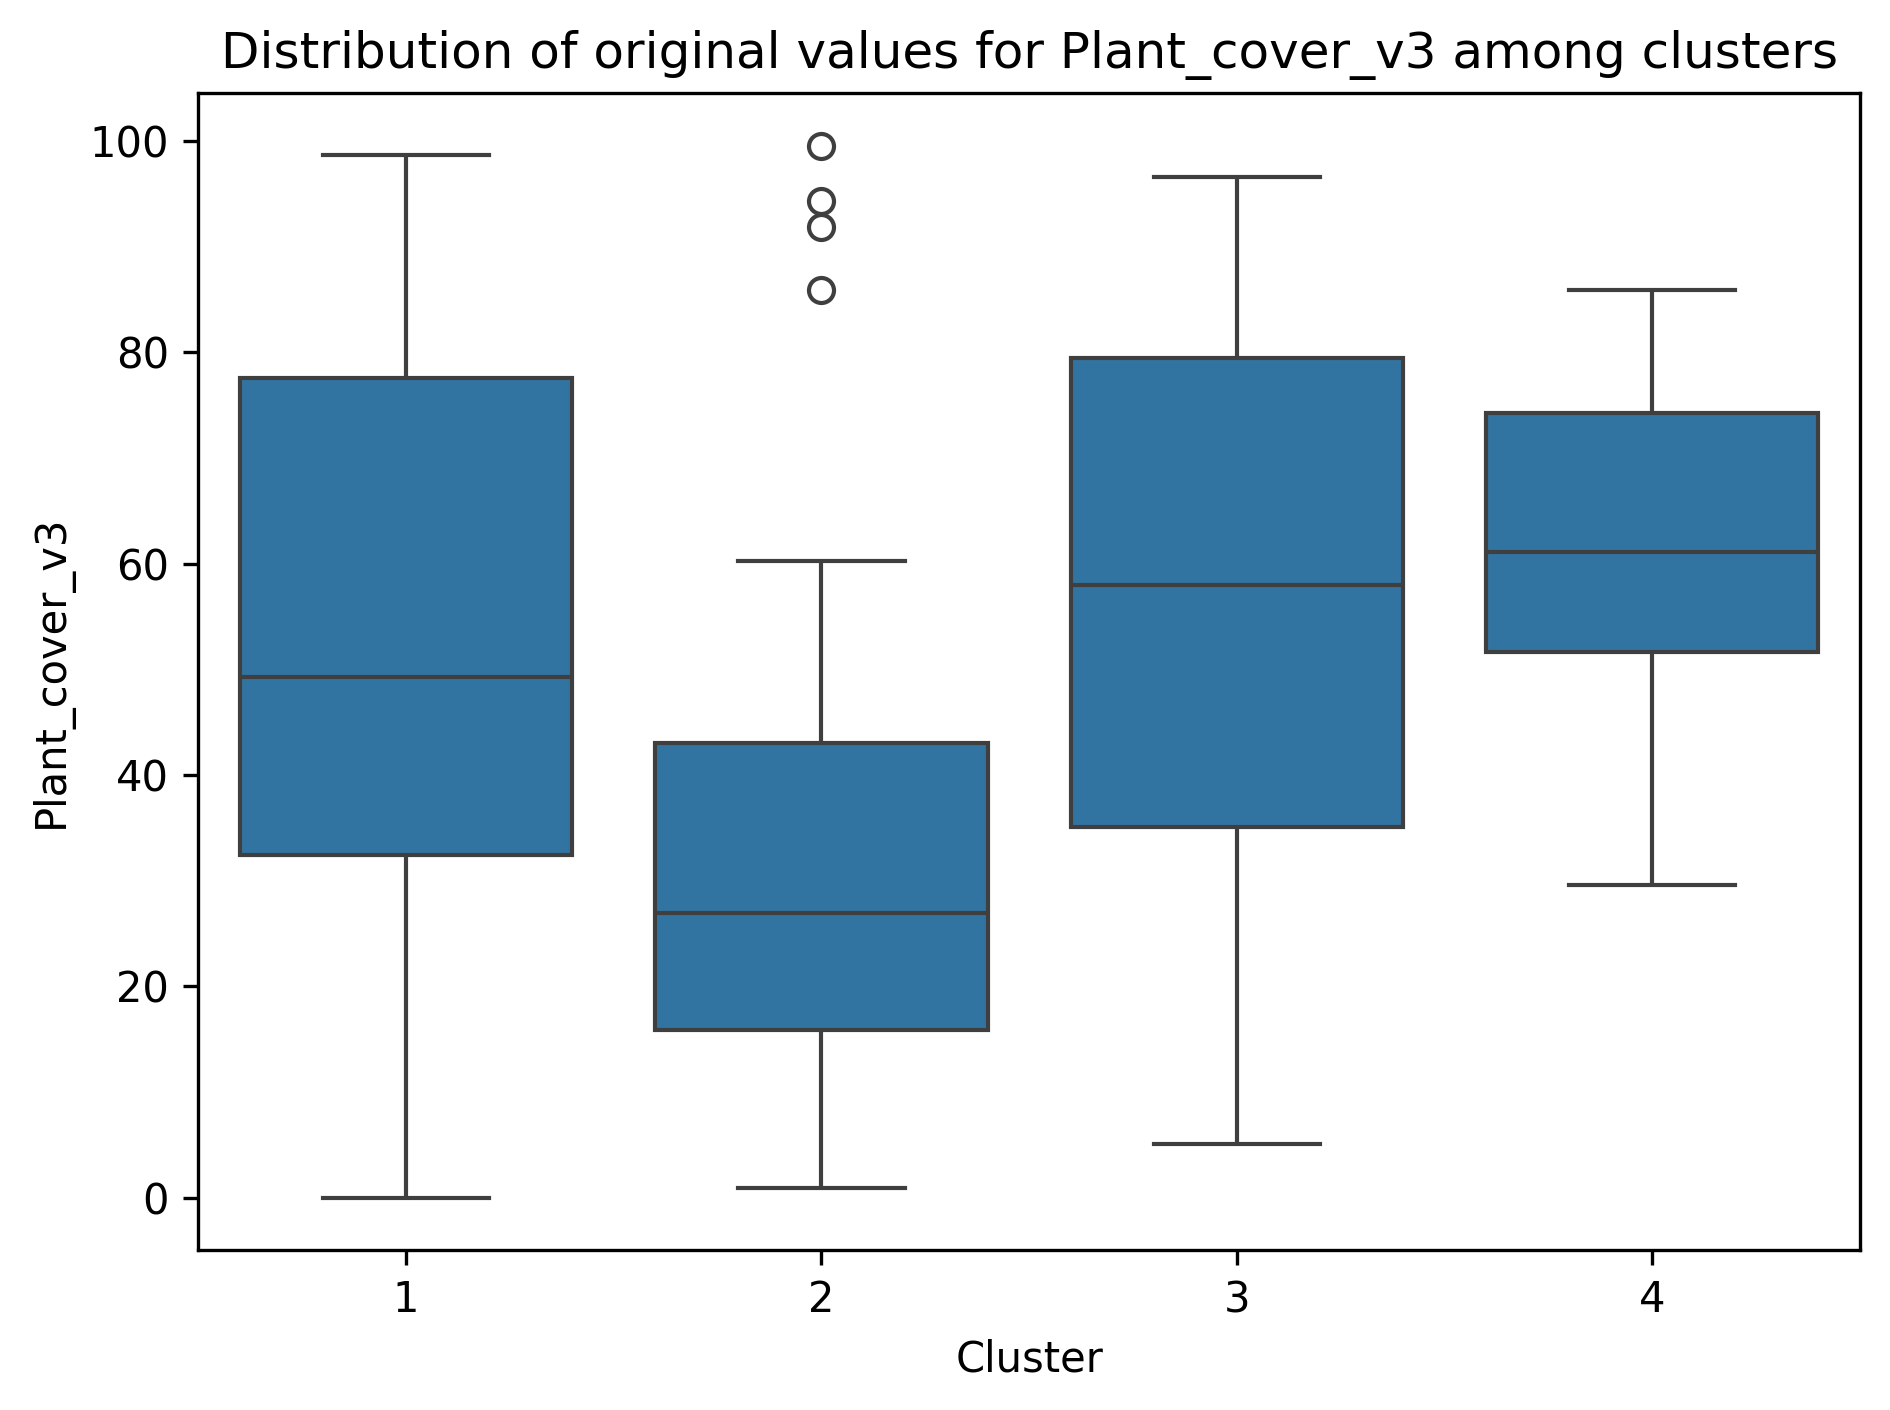

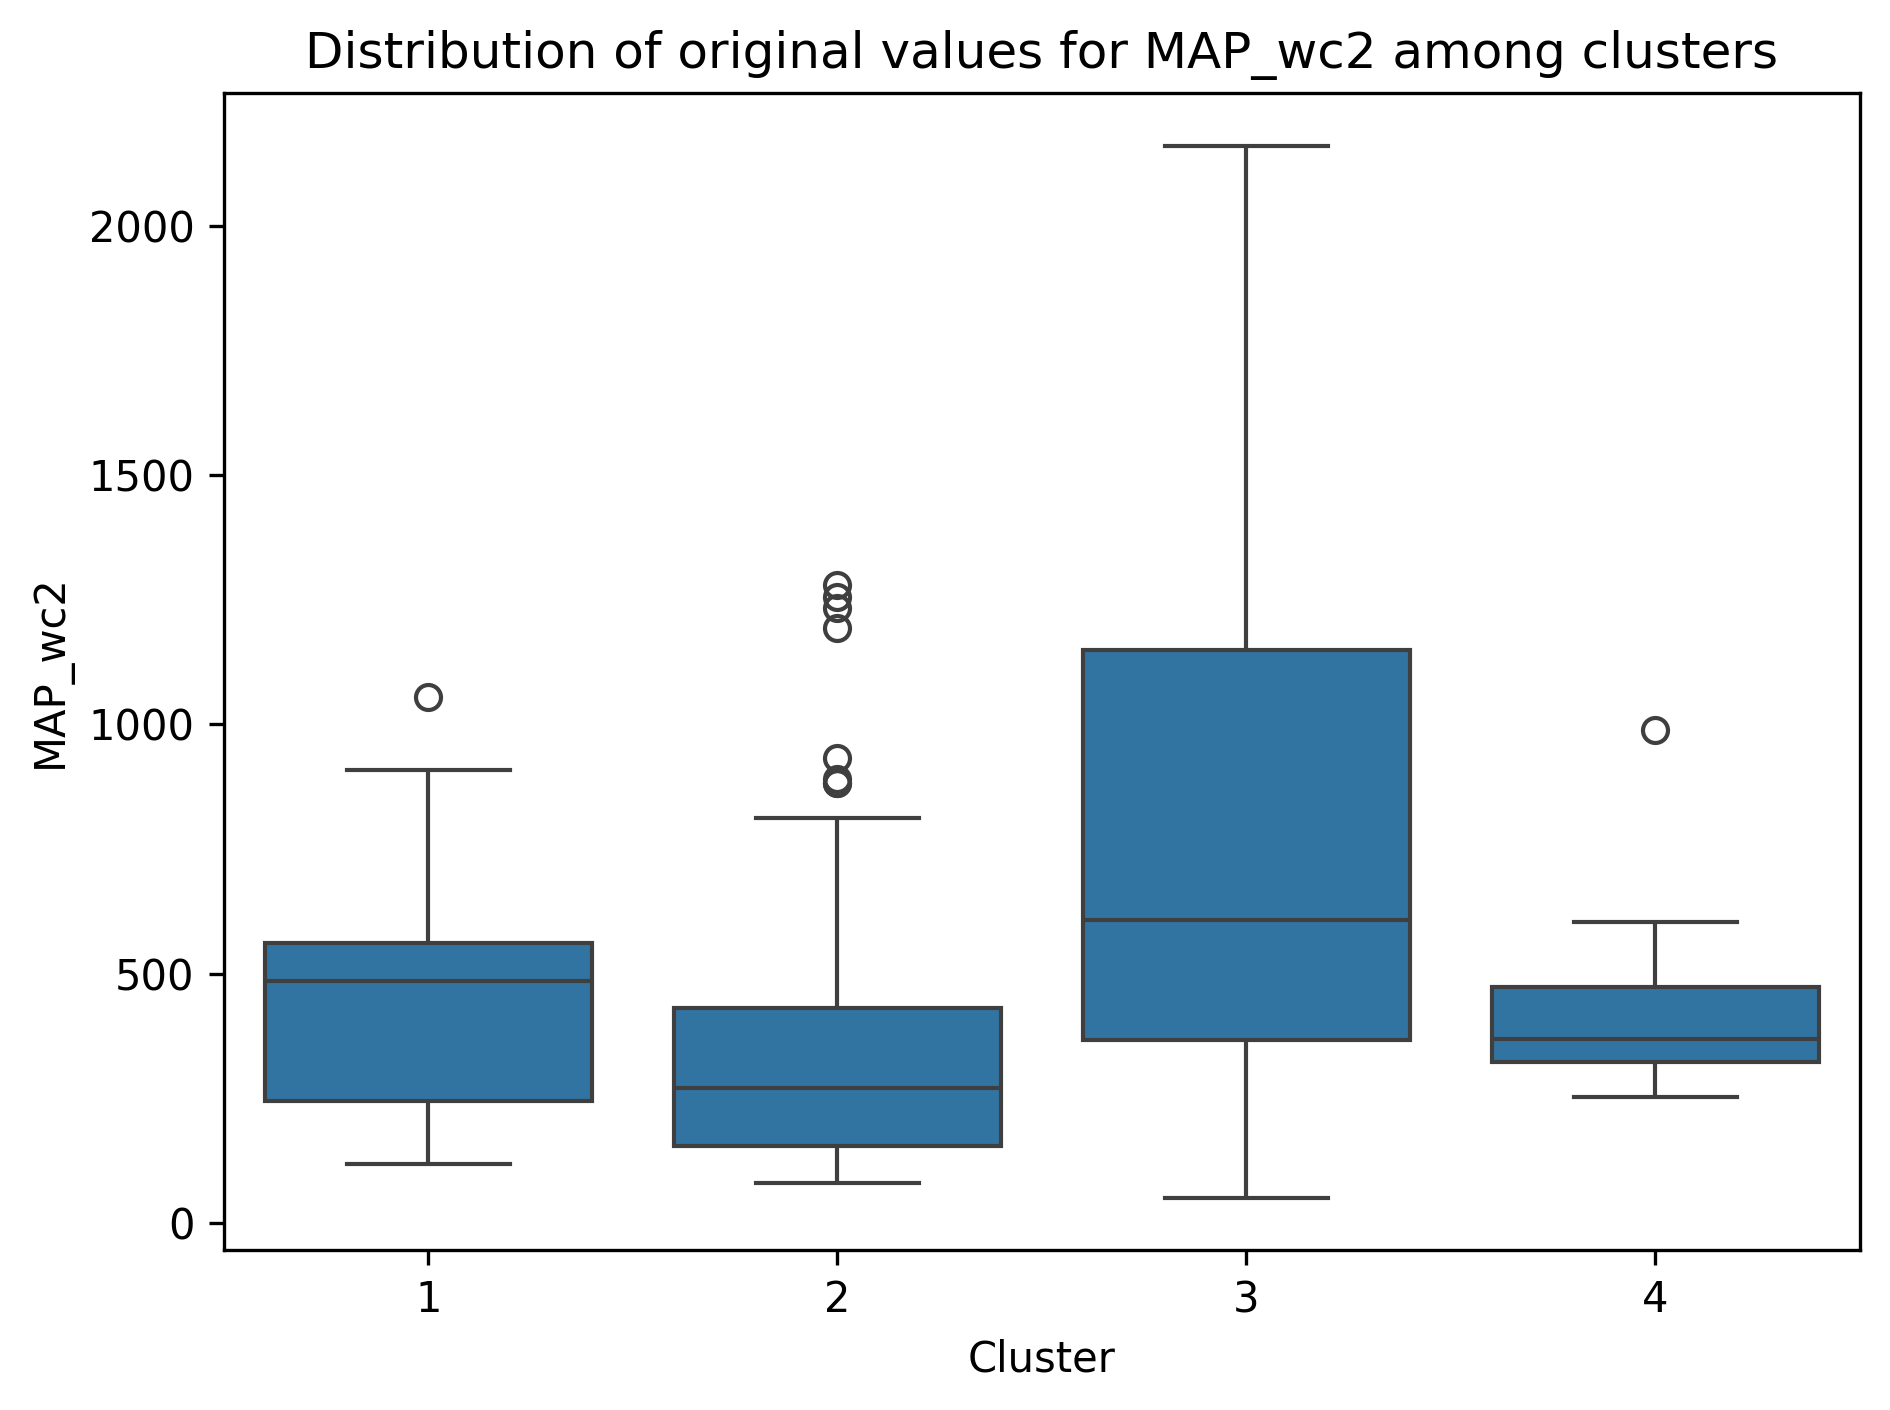

In [26]:
# Prepare the DataFrame for the box plot
df_tsne_shap['Clusters'] = np.nan
df_tsne_shap.loc[df_tsne_shap['Target'] == 'Soils low $Q_{10}$', 'Clusters'] = y_km_2d + 1  # Ensure clusters start from 1

df_low=df.copy()
df_low=df_low.loc[df_low['Q10_Basal_binary']==0]
# Add the clusters to the original DataFrame
df_low['Clusters'] = df_tsne_shap['Clusters']
df_low['Clusters'] = df_low['Clusters'].astype(int)
# List of all features to plot (from SHAP summary plot)
all_features = ["Mean_Glucose", "Bacteria_Positive", "Alkane", "SOC", "Bacteria_Negative", 
                "Fungi_Positive", "Fine_texture", "Fungi_Negative", "Protists_Negative", 
                "Forest", "Soil_pH", "Richness_fungi", "Protists_Positive", "Richness_bacteria", 
                "Soil_salinity", "Richness_protist", "Soil_P", "Plant_cover_v3", "MAP_wc2"]

# Plot box plots for each feature
for feature in all_features:
    plt.figure(dpi=300)
    sns.boxplot(data=df_low, x="Clusters", y=feature)
    plt.xlabel('Cluster')
    plt.ylabel(f'{feature}')
    plt.title(f'Distribution of original values for {feature} among clusters')
    plt.tight_layout()
    plt.show()